In [3]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import torch
from numpy.random import seed
seed_value = 420 
seed(seed_value)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,classification_report,roc_auc_score,roc_curve,recall_score, average_precision_score
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import roc_curve
import itertools
from sklearn.inspection import permutation_importance
import boost_histogram as bh
from sklearn.model_selection import KFold

directory = "/Users/archiebrooks/Documents/Uni/mphys_project/all_matched_data_0312/"
directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/bash/all_matched_data_0312/"

hep.style.use('ATLAS')

## Function Definitions

In [ ]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV', print_peak=False):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
            if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label[i]}: {peak_bin_center:.2f} {x_units}")
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data)
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')
        if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label}: {peak_bin_center:.2f} {x_units}")

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    ax[1].hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    ax[1].hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    ax[1].errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='blue', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    ax[1].errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='orange', label='Signal (test)' ) # Signal (test)
    
    ax[1].set_xlabel(xlabel) # write x-axis label
    ax[1].set_ylabel("Arbitrary units") # write y-axis label
    ax[1].legend() # add legend

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None

mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

def duplicate_cleaner(matched_pairs, truth=None):
    truth_ids = matched_pairs['truth']['id']
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(truth_ids)])
    no_repeats = ak.num(deduped_id_pairs) == ak.num(truth_ids)
    one_repeat = ak.num(deduped_id_pairs) == ak.num(truth_ids) - 1

    duplicate_pairs = matched_pairs[one_repeat]
    clean_pairs = matched_pairs[no_repeats]
    if truth is not None:
        duplicate_truth = truth[one_repeat]
        return clean_pairs, duplicate_pairs, duplicate_truth
    
    return clean_pairs, duplicate_pairs, no_repeats

def duplicate_matcher(repeat, dupe_truth):
    fixable_repeats = repeat[ak.num(repeat)>2]

    repeat_truth, valid_particles, duplicate_particles = [], [], []

    print('going into for loop')

    for i in range(1,len(dupe_truth[0])+1):

        repeat_ids = fixable_repeats['truth']['id']
        repeat_i = fixable_repeats[ak.num(repeat_ids[repeat_ids==i], axis=1)==2]
        repeat_ids_i = repeat_ids[ak.num(repeat_ids[repeat_ids==i], axis=1)==2]
        repeat_truth.append(dupe_truth[ak.num(repeat_ids[repeat_ids==i], axis=1)==2])

        valid_particles.append(repeat_i[repeat_ids_i!=i])
        duplicate_particles.append(repeat_i[repeat_ids_i==i])

    print('out of for loop')

    repeat_truth = ak.concatenate(repeat_truth)
    valid_particles = [ak.concatenate(valid_particles)]
    duplicate_particles = ak.concatenate(duplicate_particles)
    id = np.tile(np.arange(1,len(repeat_truth[0])+1), (len(repeat_truth),1))
    repeat_truth_zip = ak.zip({'truth': repeat_truth, 'id': id})

    duplicate_deltars = duplicate_particles['reco'].deltaR(duplicate_particles['truth']['truth'])
    min_dupdeltars = ak.min(duplicate_deltars, axis=1)

    valid_particles.append(duplicate_particles[duplicate_deltars==min_dupdeltars])
    invalid_particles = duplicate_particles['reco'][duplicate_deltars!=min_dupdeltars]

    second_pass = ak.cartesian({'reco': invalid_particles, 'truth': repeat_truth_zip})
    second_deltars = second_pass['reco'].deltaR(second_pass['truth']['truth'])

    second_smallest_dr = ak.sort(second_deltars)[:,1]
    valid_particles.append(second_pass[(second_deltars==second_smallest_dr)&(second_smallest_dr<0.4)])
    print("pre concat")
    valid_particles = ak.concatenate(valid_particles, axis=1)
    print("post concat")
    return valid_particles

def truth_matching(truth, truth_id, reco_jets, reco_leptons):
    id = np.tile(np.arange(1,len(truth[0])+1), (len(truth),1))
    print(len(truth[0]))

    indexed_truth = ak.zip({'truth': truth, 'id': id})
    
    truth_jets = indexed_truth[truth_id < 10]
    truth_leptons = indexed_truth[(truth_id > 10)&(truth_id<20)]

    jets_3d = ak.cartesian({'reco':reco_jets, 'truth': truth_jets}, axis=1, nested=True)

    deltars = jets_3d['reco'].deltaR(jets_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_jets = ak.flatten(jets_3d[(deltars==min_deltars)&(min_deltars<0.4)], axis=2)


    leptons_3d = ak.cartesian({'truth': truth_leptons, 'reco':reco_leptons}, axis=1, nested=True)

    deltars = leptons_3d['reco'].deltaR(leptons_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_leptons = ak.flatten(leptons_3d[(deltars==min_deltars)&(min_deltars<0.1)], axis=2)

    matched = ak.concatenate((matched_jets, matched_leptons), axis=1)

    matched_pairs, repeat_pairs, matched_bools = duplicate_cleaner(matched)

    print("starting dm")

    #valid_particles = duplicate_matcher(repeat_pairs, repeat_truth)

    print("starting axis=0 concat")

    #matched_events = ak.concatenate((matched_pairs, valid_particles), axis=0)
    matched_events = matched_pairs
    
    return matched_events, matched_bools

def top_identifier(matched_data, process, lepton_channel, lepton_indices=None):
    """
    Takes the matched, duplicate free data and trys to reconstruct any tops it can
    """

    if process=="4t":
        if lepton_channel == "0L":
            truth_tops_1 = matched_data['truth']['truth'][(matched_data['truth']['id']==1)|(matched_data['truth']['id']==5)|(matched_data['truth']['id']==6)]
            truth_tops_2 = matched_data['truth']['truth'][(matched_data['truth']['id']==2)|(matched_data['truth']['id']==7)|(matched_data['truth']['id']==8)]
            truth_tops_3 = matched_data['truth']['truth'][(matched_data['truth']['id']==3)|(matched_data['truth']['id']==9)|(matched_data['truth']['id']==10)]
            truth_tops_4 = matched_data['truth']['truth'][(matched_data['truth']['id']==4)|(matched_data['truth']['id']==11)|(matched_data['truth']['id']==12)]

            reco_tops_1 = matched_data['reco'][(matched_data['truth']['id']==1)|(matched_data['truth']['id']==5)|(matched_data['truth']['id']==6)]
            reco_tops_2 = matched_data['reco'][(matched_data['truth']['id']==2)|(matched_data['truth']['id']==7)|(matched_data['truth']['id']==8)]
            reco_tops_3 = matched_data['reco'][(matched_data['truth']['id']==3)|(matched_data['truth']['id']==9)|(matched_data['truth']['id']==10)]
            reco_tops_4 = matched_data['reco'][(matched_data['truth']['id']==4)|(matched_data['truth']['id']==11)|(matched_data['truth']['id']==12)]

            truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==3)
            truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==3)
            truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)
            truth_tops_4 = ak.mask(truth_tops_4, ak.num(truth_tops_4)==3)

            reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==3)
            reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==3)
            reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)
            reco_tops_4 = ak.mask(reco_tops_4, ak.num(reco_tops_4)==3)

        elif lepton_channel == "2L":

            matched_01 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)]
            truth_tops_1_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==5)]
            truth_tops_2_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==6)]
            truth_tops_3_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==7)|(matched_01['truth']['id']==8)]
            truth_tops_4_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==4)|(matched_01['truth']['id']==9)|(matched_01['truth']['id']==10)]

            reco_tops_1_01 = matched_01['reco'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==5)]
            reco_tops_2_01 = matched_01['reco'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==6)]
            reco_tops_3_01 = matched_01['reco'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==7)|(matched_01['truth']['id']==8)]
            reco_tops_4_01 = matched_01['reco'][(matched_01['truth']['id']==4)|(matched_01['truth']['id']==9)|(matched_01['truth']['id']==10)]

            matched_03 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)]
            truth_tops_1_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==5)]
            truth_tops_3_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==6)|(matched_03['truth']['id']==7)]
            truth_tops_2_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==8)]
            truth_tops_4_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==4)|(matched_03['truth']['id']==9)|(matched_03['truth']['id']==10)]

            reco_tops_1_03 = matched_03['reco'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==5)]
            reco_tops_3_03 = matched_03['reco'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==6)|(matched_03['truth']['id']==7)]
            reco_tops_2_03 = matched_03['reco'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==8)]
            reco_tops_4_03 = matched_03['reco'][(matched_03['truth']['id']==4)|(matched_03['truth']['id']==9)|(matched_03['truth']['id']==10)]

            matched_05 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==5)]
            truth_tops_1_05 = matched_05['truth']['truth'][(matched_05['truth']['id']==1)|(matched_05['truth']['id']==5)]
            truth_tops_3_05 = matched_05['truth']['truth'][(matched_05['truth']['id']==2)|(matched_05['truth']['id']==6)|(matched_05['truth']['id']==7)]
            truth_tops_4_05 = matched_05['truth']['truth'][(matched_05['truth']['id']==3)|(matched_05['truth']['id']==8)|(matched_05['truth']['id']==9)]
            truth_tops_2_05 = matched_05['truth']['truth'][(matched_05['truth']['id']==4)|(matched_05['truth']['id']==10)]

            reco_tops_1_05 = matched_05['reco'][(matched_05['truth']['id']==1)|(matched_05['truth']['id']==5)]
            reco_tops_3_05 = matched_05['reco'][(matched_05['truth']['id']==2)|(matched_05['truth']['id']==6)|(matched_05['truth']['id']==7)]
            reco_tops_4_05 = matched_05['reco'][(matched_05['truth']['id']==3)|(matched_05['truth']['id']==8)|(matched_05['truth']['id']==9)]
            reco_tops_2_05 = matched_05['reco'][(matched_05['truth']['id']==4)|(matched_05['truth']['id']==10)]

            matched_23 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)]
            truth_tops_3_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==5)|(matched_23['truth']['id']==6)]
            truth_tops_1_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==7)]
            truth_tops_2_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==8)]
            truth_tops_4_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==4)|(matched_23['truth']['id']==9)|(matched_23['truth']['id']==10)]

            reco_tops_3_23 = matched_23['reco'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==5)|(matched_23['truth']['id']==6)]
            reco_tops_1_23 = matched_23['reco'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==7)]
            reco_tops_2_23 = matched_23['reco'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==8)]
            reco_tops_4_23 = matched_23['reco'][(matched_23['truth']['id']==4)|(matched_23['truth']['id']==9)|(matched_23['truth']['id']==10)]

            matched_25 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==5)]
            truth_tops_3_25 = matched_25['truth']['truth'][(matched_25['truth']['id']==1)|(matched_25['truth']['id']==5)|(matched_25['truth']['id']==6)]
            truth_tops_1_25 = matched_25['truth']['truth'][(matched_25['truth']['id']==2)|(matched_25['truth']['id']==7)]
            truth_tops_4_25 = matched_25['truth']['truth'][(matched_25['truth']['id']==3)|(matched_25['truth']['id']==8)|(matched_25['truth']['id']==9)]
            truth_tops_2_25 = matched_25['truth']['truth'][(matched_25['truth']['id']==4)|(matched_25['truth']['id']==10)]

            reco_tops_3_25 = matched_25['reco'][(matched_25['truth']['id']==1)|(matched_25['truth']['id']==5)|(matched_25['truth']['id']==6)]
            reco_tops_1_25 = matched_25['reco'][(matched_25['truth']['id']==2)|(matched_25['truth']['id']==7)]
            reco_tops_4_25 = matched_25['reco'][(matched_25['truth']['id']==3)|(matched_25['truth']['id']==8)|(matched_25['truth']['id']==9)]
            reco_tops_2_25 = matched_25['reco'][(matched_25['truth']['id']==4)|(matched_25['truth']['id']==10)]

            matched_45 = matched_data[lepton_indices[:,0]==4]
            truth_tops_3_45 = matched_45['truth']['truth'][(matched_45['truth']['id']==1)|(matched_45['truth']['id']==5)|(matched_45['truth']['id']==6)]
            truth_tops_4_45 = matched_45['truth']['truth'][(matched_45['truth']['id']==2)|(matched_45['truth']['id']==7)|(matched_45['truth']['id']==8)]
            truth_tops_1_45 = matched_45['truth']['truth'][(matched_45['truth']['id']==3)|(matched_45['truth']['id']==9)]
            truth_tops_2_45 = matched_45['truth']['truth'][(matched_45['truth']['id']==4)|(matched_45['truth']['id']==10)]

            reco_tops_3_45 = matched_45['reco'][(matched_45['truth']['id']==1)|(matched_45['truth']['id']==5)|(matched_45['truth']['id']==6)]
            reco_tops_4_45 = matched_45['reco'][(matched_45['truth']['id']==2)|(matched_45['truth']['id']==7)|(matched_45['truth']['id']==8)]
            reco_tops_1_45 = matched_45['reco'][(matched_45['truth']['id']==3)|(matched_45['truth']['id']==9)]
            reco_tops_2_45 = matched_45['reco'][(matched_45['truth']['id']==4)|(matched_45['truth']['id']==10)]

            truth_tops_1 = ak.concatenate((truth_tops_1_01, truth_tops_1_03, truth_tops_1_05, truth_tops_1_23, truth_tops_1_25, truth_tops_1_45))
            truth_tops_2 = ak.concatenate((truth_tops_2_01, truth_tops_2_03, truth_tops_2_05, truth_tops_2_23, truth_tops_2_25, truth_tops_2_45))
            truth_tops_3 = ak.concatenate((truth_tops_3_01, truth_tops_3_03, truth_tops_3_05, truth_tops_3_23, truth_tops_3_25, truth_tops_3_45))
            truth_tops_4 = ak.concatenate((truth_tops_4_01, truth_tops_4_03, truth_tops_4_05, truth_tops_4_23, truth_tops_4_25, truth_tops_4_45))

            reco_tops_1 = ak.concatenate((reco_tops_1_01, reco_tops_1_03, reco_tops_1_05, reco_tops_1_23, reco_tops_1_25, reco_tops_1_45))
            reco_tops_2 = ak.concatenate((reco_tops_2_01, reco_tops_2_03, reco_tops_2_05, reco_tops_2_23, reco_tops_2_25, reco_tops_2_45))
            reco_tops_3 = ak.concatenate((reco_tops_3_01, reco_tops_3_03, reco_tops_3_05, reco_tops_3_23, reco_tops_3_25, reco_tops_3_45))
            reco_tops_4 = ak.concatenate((reco_tops_4_01, reco_tops_4_03, reco_tops_4_05, reco_tops_4_23, reco_tops_4_25, reco_tops_4_45))

            truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==2)
            truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==2)
            truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)
            truth_tops_4 = ak.mask(truth_tops_4, ak.num(truth_tops_4)==3)

            reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==2)
            reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==2)
            reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)
            reco_tops_4 = ak.mask(reco_tops_4, ak.num(reco_tops_4)==3)

        truth_top_1 = ak.unflatten(ak.sum(truth_tops_1, axis=1), 1)
        truth_top_2 = ak.unflatten(ak.sum(truth_tops_2, axis=1), 1)
        truth_top_3 = ak.unflatten(ak.sum(truth_tops_3, axis=1), 1)
        truth_top_4 = ak.unflatten(ak.sum(truth_tops_4, axis=1), 1)

        reco_top_1 = ak.unflatten(ak.sum(reco_tops_1, axis=1), 1)
        reco_top_2 = ak.unflatten(ak.sum(reco_tops_2, axis=1), 1)
        reco_top_3 = ak.unflatten(ak.sum(reco_tops_3, axis=1), 1)
        reco_top_4 = ak.unflatten(ak.sum(reco_tops_4, axis=1), 1)

        all_truth_tops = ak.drop_none(ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4), axis=1))
        all_reco_tops = ak.drop_none(ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4), axis=1))

        sm_mask, dm_mask, tm_mask, fm_mask = (ak.num(all_truth_tops)==1), (ak.num(all_truth_tops)==2), (ak.num(all_truth_tops)==3), (ak.num(all_truth_tops)==4)

        sm_truth_tops, sm_reco_tops = all_truth_tops[sm_mask], all_reco_tops[sm_mask]
        dm_truth_tops, dm_reco_tops = all_truth_tops[dm_mask], all_reco_tops[dm_mask]
        tm_truth_tops, tm_reco_tops = all_truth_tops[tm_mask], all_reco_tops[tm_mask]
        fm_truth_tops, fm_reco_tops = all_truth_tops[fm_mask], all_reco_tops[fm_mask]

        return [sm_truth_tops, sm_reco_tops], [dm_truth_tops, dm_reco_tops], [tm_truth_tops, tm_reco_tops], [fm_truth_tops, fm_reco_tops]
    elif (process=="3tj")|(process=="3tW"):
        if lepton_channel == "0L":
            truth_tops_1 = matched_data['truth']['truth'][(matched_data['truth']['id']==1)|(matched_data['truth']['id']==4)|(matched_data['truth']['id']==5)]
            truth_tops_2 = matched_data['truth']['truth'][(matched_data['truth']['id']==2)|(matched_data['truth']['id']==6)|(matched_data['truth']['id']==7)]
            truth_tops_3 = matched_data['truth']['truth'][(matched_data['truth']['id']==3)|(matched_data['truth']['id']==8)|(matched_data['truth']['id']==9)]

            reco_tops_1 = matched_data['reco'][(matched_data['truth']['id']==1)|(matched_data['truth']['id']==4)|(matched_data['truth']['id']==5)]
            reco_tops_2 = matched_data['reco'][(matched_data['truth']['id']==2)|(matched_data['truth']['id']==6)|(matched_data['truth']['id']==7)]
            reco_tops_3 = matched_data['reco'][(matched_data['truth']['id']==3)|(matched_data['truth']['id']==8)|(matched_data['truth']['id']==9)]

            truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==3)
            truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==3)
            truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)

            reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==3)
            reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==3)
            reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)

        elif lepton_channel == "2L":

            matched_01 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)]
            truth_tops_1_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==4)]
            truth_tops_2_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==5)]
            truth_tops_3_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==6)|(matched_01['truth']['id']==7)]

            reco_tops_1_01 = matched_01['reco'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==4)]
            reco_tops_2_01 = matched_01['reco'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==5)]
            reco_tops_3_01 = matched_01['reco'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==6)|(matched_01['truth']['id']==7)]

            matched_03 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)]
            truth_tops_1_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==4)]
            truth_tops_3_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==5)|(matched_03['truth']['id']==6)]
            truth_tops_2_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==7)]

            reco_tops_1_03 = matched_03['reco'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==4)]
            reco_tops_3_03 = matched_03['reco'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==5)|(matched_03['truth']['id']==6)]
            reco_tops_2_03 = matched_03['reco'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==7)]

            matched_23 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)]
            truth_tops_3_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==4)|(matched_23['truth']['id']==5)]
            truth_tops_1_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==6)]
            truth_tops_2_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==7)]

            reco_tops_3_23 = matched_23['reco'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==4)|(matched_23['truth']['id']==5)]
            reco_tops_1_23 = matched_23['reco'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==6)]
            reco_tops_2_23 = matched_23['reco'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==7)]

            truth_tops_1 = ak.concatenate((truth_tops_1_01, truth_tops_1_03, truth_tops_1_23))
            truth_tops_2 = ak.concatenate((truth_tops_2_01, truth_tops_2_03, truth_tops_2_23))
            truth_tops_3 = ak.concatenate((truth_tops_3_01, truth_tops_3_03, truth_tops_3_23))

            reco_tops_1 = ak.concatenate((reco_tops_1_01, reco_tops_1_03, reco_tops_1_23))
            reco_tops_2 = ak.concatenate((reco_tops_2_01, reco_tops_2_03, reco_tops_2_23))
            reco_tops_3 = ak.concatenate((reco_tops_3_01, reco_tops_3_03, reco_tops_3_23))

            truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==2)
            truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==2)
            truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)

            reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==2)
            reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==2)
            reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)

        truth_top_1 = ak.unflatten(ak.sum(truth_tops_1, axis=1), 1)
        truth_top_2 = ak.unflatten(ak.sum(truth_tops_2, axis=1), 1)
        truth_top_3 = ak.unflatten(ak.sum(truth_tops_3, axis=1), 1)

        reco_top_1 = ak.unflatten(ak.sum(reco_tops_1, axis=1), 1)
        reco_top_2 = ak.unflatten(ak.sum(reco_tops_2, axis=1), 1)
        reco_top_3 = ak.unflatten(ak.sum(reco_tops_3, axis=1), 1)

        all_truth_tops = ak.drop_none(ak.concatenate((truth_top_1,truth_top_2,truth_top_3), axis=1))
        all_reco_tops = ak.drop_none(ak.concatenate((reco_top_1,reco_top_2,reco_top_3), axis=1))

        sm_mask, dm_mask, fm_mask = (ak.num(all_truth_tops)==1), (ak.num(all_truth_tops)==2), (ak.num(all_truth_tops)==3)

        sm_truth_tops, sm_reco_tops = all_truth_tops[sm_mask], all_reco_tops[sm_mask]
        dm_truth_tops, dm_reco_tops = all_truth_tops[dm_mask], all_reco_tops[dm_mask]
        fm_truth_tops, fm_reco_tops = all_truth_tops[fm_mask], all_reco_tops[fm_mask]

        return [sm_truth_tops, sm_reco_tops], [dm_truth_tops, dm_reco_tops], [fm_truth_tops, fm_reco_tops]
    
def top_identifier_neutrino(matched_data, neutrinos, process, lepton_channel, lepton_indices=None):
    """
    Takes the matched, duplicate free data and trys to reconstruct any tops it can
    """

    if process=="4t":

        matched_0 = matched_data[(lepton_indices[:,0]==0)]
        neutrinos_0 = neutrinos[(lepton_indices[:,0]==0)]
        truth_tops_1_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==5)]
        truth_tops_2_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==6)|(matched_0['truth']['id']==7)]
        truth_tops_3_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==8)|(matched_0['truth']['id']==9)]
        truth_tops_4_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==4)|(matched_0['truth']['id']==10)|(matched_0['truth']['id']==11)]

        reco_tops_1_0 = matched_0['reco'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==5)]
        reco_tops_2_0 = matched_0['reco'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==6)|(matched_0['truth']['id']==7)]
        reco_tops_3_0 = matched_0['reco'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==8)|(matched_0['truth']['id']==9)]
        reco_tops_4_0 = matched_0['reco'][(matched_0['truth']['id']==4)|(matched_0['truth']['id']==10)|(matched_0['truth']['id']==11)]

        matched_2 = matched_data[(lepton_indices[:,0]==2)]
        neutrinos_2 = neutrinos[(lepton_indices[:,0]==2)]
        truth_tops_2_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==5)|(matched_2['truth']['id']==6)]
        truth_tops_1_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==7)]
        truth_tops_3_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==8)|(matched_2['truth']['id']==9)]
        truth_tops_4_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==4)|(matched_2['truth']['id']==10)|(matched_2['truth']['id']==11)]

        reco_tops_2_2 = matched_2['reco'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==5)|(matched_2['truth']['id']==6)]
        reco_tops_1_2 = matched_2['reco'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==7)]
        reco_tops_3_2 = matched_2['reco'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==8)|(matched_2['truth']['id']==9)]
        reco_tops_4_2 = matched_2['reco'][(matched_2['truth']['id']==4)|(matched_2['truth']['id']==10)|(matched_2['truth']['id']==11)]

        matched_4 = matched_data[(lepton_indices[:,0]==4)]
        neutrinos_4 = neutrinos[(lepton_indices[:,0]==4)]
        truth_tops_2_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==5)|(matched_4['truth']['id']==6)]
        truth_tops_3_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==7)|(matched_4['truth']['id']==8)]
        truth_tops_1_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==9)]
        truth_tops_4_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==4)|(matched_4['truth']['id']==10)|(matched_4['truth']['id']==11)]

        reco_tops_2_4 = matched_4['reco'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==5)|(matched_4['truth']['id']==6)]
        reco_tops_3_4 = matched_4['reco'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==7)|(matched_4['truth']['id']==8)]
        reco_tops_1_4 = matched_4['reco'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==9)]
        reco_tops_4_4 = matched_4['reco'][(matched_4['truth']['id']==4)|(matched_4['truth']['id']==10)|(matched_4['truth']['id']==11)]

        matched_6 = matched_data[(lepton_indices[:,0]==6)]
        neutrinos_6 = neutrinos[(lepton_indices[:,0]==6)]
        truth_tops_2_6 = matched_6['truth']['truth'][(matched_6['truth']['id']==1)|(matched_6['truth']['id']==5)|(matched_6['truth']['id']==6)]
        truth_tops_3_6 = matched_6['truth']['truth'][(matched_6['truth']['id']==2)|(matched_6['truth']['id']==7)|(matched_6['truth']['id']==8)]
        truth_tops_4_6 = matched_6['truth']['truth'][(matched_6['truth']['id']==3)|(matched_6['truth']['id']==9)|(matched_6['truth']['id']==10)]
        truth_tops_1_6 = matched_6['truth']['truth'][(matched_6['truth']['id']==4)|(matched_6['truth']['id']==11)]

        reco_tops_2_6 = matched_6['reco'][(matched_6['truth']['id']==1)|(matched_6['truth']['id']==5)|(matched_6['truth']['id']==6)]
        reco_tops_3_6 = matched_6['reco'][(matched_6['truth']['id']==2)|(matched_6['truth']['id']==7)|(matched_6['truth']['id']==8)]
        reco_tops_4_6 = matched_6['reco'][(matched_6['truth']['id']==3)|(matched_6['truth']['id']==9)|(matched_6['truth']['id']==10)]
        reco_tops_1_6 = matched_6['reco'][(matched_6['truth']['id']==4)|(matched_6['truth']['id']==11)]

        truth_tops_1 = ak.concatenate((truth_tops_1_0, truth_tops_1_2, truth_tops_1_4, truth_tops_1_6))
        truth_tops_2 = ak.concatenate((truth_tops_2_0, truth_tops_2_2, truth_tops_2_4, truth_tops_2_6))
        truth_tops_3 = ak.concatenate((truth_tops_3_0, truth_tops_3_2, truth_tops_3_4, truth_tops_3_6))
        truth_tops_4 = ak.concatenate((truth_tops_4_0, truth_tops_4_2, truth_tops_4_4, truth_tops_4_6))

        reco_tops_1 = ak.concatenate((reco_tops_1_0, reco_tops_1_2, reco_tops_1_4, reco_tops_1_6))
        reco_tops_2 = ak.concatenate((reco_tops_2_0, reco_tops_2_2, reco_tops_2_4, reco_tops_2_6))
        reco_tops_3 = ak.concatenate((reco_tops_3_0, reco_tops_3_2, reco_tops_3_4, reco_tops_3_6))
        reco_tops_4 = ak.concatenate((reco_tops_4_0, reco_tops_4_2, reco_tops_4_4, reco_tops_4_6))

        top_neutrinos = ak.concatenate((neutrinos_0, neutrinos_2, neutrinos_4, neutrinos_6))

        truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==2)
        truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==3)
        truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)
        truth_tops_4 = ak.mask(truth_tops_4, ak.num(truth_tops_4)==3)

        truth_tops_1 = ak.concatenate((truth_tops_1,top_neutrinos), axis=1)

        reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==2)
        reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==3)
        reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)
        reco_tops_4 = ak.mask(reco_tops_4, ak.num(reco_tops_4)==3)

        reco_tops_1 = ak.concatenate((reco_tops_1,top_neutrinos), axis=1)

        truth_top_1 = ak.unflatten(ak.sum(truth_tops_1, axis=1), 1)
        truth_top_2 = ak.unflatten(ak.sum(truth_tops_2, axis=1), 1)
        truth_top_3 = ak.unflatten(ak.sum(truth_tops_3, axis=1), 1)
        truth_top_4 = ak.unflatten(ak.sum(truth_tops_4, axis=1), 1)

        reco_top_1 = ak.unflatten(ak.sum(reco_tops_1, axis=1), 1)
        reco_top_2 = ak.unflatten(ak.sum(reco_tops_2, axis=1), 1)
        reco_top_3 = ak.unflatten(ak.sum(reco_tops_3, axis=1), 1)
        reco_top_4 = ak.unflatten(ak.sum(reco_tops_4, axis=1), 1)

        all_truth_tops = ak.drop_none(ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4), axis=1))
        all_reco_tops = ak.drop_none(ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4), axis=1))

        sm_mask, dm_mask, tm_mask, fm_mask = (ak.num(all_truth_tops)==1), (ak.num(all_truth_tops)==2), (ak.num(all_truth_tops)==3), (ak.num(all_truth_tops)==4)

        sm_truth_tops, sm_reco_tops = all_truth_tops[sm_mask], all_reco_tops[sm_mask]
        dm_truth_tops, dm_reco_tops = all_truth_tops[dm_mask], all_reco_tops[dm_mask]
        tm_truth_tops, tm_reco_tops = all_truth_tops[tm_mask], all_reco_tops[tm_mask]
        fm_truth_tops, fm_reco_tops = all_truth_tops[fm_mask], all_reco_tops[fm_mask]

        return [sm_truth_tops, sm_reco_tops], [dm_truth_tops, dm_reco_tops], [tm_truth_tops, tm_reco_tops], [fm_truth_tops, fm_reco_tops]
    elif (process=="3tj")|(process=="3tW"):

        matched_0 = matched_data[(lepton_indices[:,0]==0)]
        neutrinos_0 = neutrinos[(lepton_indices[:,0]==0)]
        truth_tops_1_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==4)]
        truth_tops_2_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==5)|(matched_0['truth']['id']==6)]
        truth_tops_3_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==7)|(matched_0['truth']['id']==8)]

        reco_tops_1_0 = matched_0['reco'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==4)]
        reco_tops_2_0 = matched_0['reco'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==5)|(matched_0['truth']['id']==6)]
        reco_tops_3_0 = matched_0['reco'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==7)|(matched_0['truth']['id']==8)]

        matched_2 = matched_data[(lepton_indices[:,0]==2)]
        neutrinos_2 = neutrinos[(lepton_indices[:,0]==2)]
        truth_tops_2_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==4)|(matched_2['truth']['id']==5)]
        truth_tops_1_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==6)]
        truth_tops_3_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==7)|(matched_2['truth']['id']==8)]

        reco_tops_2_2 = matched_2['reco'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==4)|(matched_2['truth']['id']==5)]
        reco_tops_1_2 = matched_2['reco'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==6)]
        reco_tops_3_2 = matched_2['reco'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==7)|(matched_2['truth']['id']==8)]

        matched_4 = matched_data[(lepton_indices[:,0]==4)]
        neutrinos_4 = neutrinos[(lepton_indices[:,0]==4)]
        truth_tops_2_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==4)|(matched_4['truth']['id']==5)]
        truth_tops_3_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==6)|(matched_4['truth']['id']==7)]
        truth_tops_1_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==8)]

        reco_tops_2_4 = matched_4['reco'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==4)|(matched_4['truth']['id']==5)]
        reco_tops_3_4 = matched_4['reco'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==6)|(matched_4['truth']['id']==7)]
        reco_tops_1_4 = matched_4['reco'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==8)]

        truth_tops_1 = ak.concatenate((truth_tops_1_0, truth_tops_1_2, truth_tops_1_4))
        truth_tops_2 = ak.concatenate((truth_tops_2_0, truth_tops_2_2, truth_tops_2_4))
        truth_tops_3 = ak.concatenate((truth_tops_3_0, truth_tops_3_2, truth_tops_3_4))

        reco_tops_1 = ak.concatenate((reco_tops_1_0, reco_tops_1_2, reco_tops_1_4))
        reco_tops_2 = ak.concatenate((reco_tops_2_0, reco_tops_2_2, reco_tops_2_4))
        reco_tops_3 = ak.concatenate((reco_tops_3_0, reco_tops_3_2, reco_tops_3_4))

        top_neutrinos = ak.concatenate((neutrinos_0, neutrinos_2, neutrinos_4))

        truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==2)
        truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==3)
        truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)

        truth_tops_1 = ak.concatenate((truth_tops_1,top_neutrinos), axis=1)

        reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==2)
        reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==3)
        reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)

        reco_tops_1 = ak.concatenate((reco_tops_1,top_neutrinos), axis=1)

        truth_top_1 = ak.unflatten(ak.sum(truth_tops_1, axis=1), 1)
        truth_top_2 = ak.unflatten(ak.sum(truth_tops_2, axis=1), 1)
        truth_top_3 = ak.unflatten(ak.sum(truth_tops_3, axis=1), 1)

        reco_top_1 = ak.unflatten(ak.sum(reco_tops_1, axis=1), 1)
        reco_top_2 = ak.unflatten(ak.sum(reco_tops_2, axis=1), 1)
        reco_top_3 = ak.unflatten(ak.sum(reco_tops_3, axis=1), 1)

        all_truth_tops = ak.drop_none(ak.concatenate((truth_top_1,truth_top_2,truth_top_3), axis=1))
        all_reco_tops = ak.drop_none(ak.concatenate((reco_top_1,reco_top_2,reco_top_3), axis=1))

        sm_mask, dm_mask, fm_mask = (ak.num(all_truth_tops)==1), (ak.num(all_truth_tops)==2), (ak.num(all_truth_tops)==3)

        sm_truth_tops, sm_reco_tops = all_truth_tops[sm_mask], all_reco_tops[sm_mask]
        dm_truth_tops, dm_reco_tops = all_truth_tops[dm_mask], all_reco_tops[dm_mask]
        fm_truth_tops, fm_reco_tops = all_truth_tops[fm_mask], all_reco_tops[fm_mask]

        return [sm_truth_tops, sm_reco_tops], [dm_truth_tops, dm_reco_tops], [fm_truth_tops, fm_reco_tops]

def data_generator(matching_channel, lepton_channel, top_channel):
    
    tree = uproot.open(directory + f"{matching_channel}_{top_channel}_{lepton_channel}_02Dec.root")
    tree_truth = tree['Truth;1']
    tree_reco = tree['Reco;1']
    
    events_truth = tree_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
    events_reco = tree_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge'])
    events_reco['el_mass'] = 0.511e-3 * np.ones_like(events_reco['el_pt'])
    events_reco['mu_mass'] = 0.1057 * np.ones_like(events_reco['mu_pt'])
    events_reco['jet_e'] = np.sqrt(events_reco['jet_mass']**2+(events_reco['jet_pt']**2)*(np.cosh(events_reco['jet_eta']))**2)
    events_reco['el_e'] = np.sqrt(events_reco['el_mass']**2+(events_reco['el_pt']**2)*(np.cosh(events_reco['el_eta']))**2)
    events_reco['mu_e'] = np.sqrt(events_reco['mu_mass']**2+(events_reco['mu_pt']**2)*(np.cosh(events_reco['mu_eta']))**2)
    print(len(events_truth))

    jet_pt = events_reco['jet_pt']
    jet_eta = events_reco['jet_eta']
    jet_phi = events_reco['jet_phi']
    jet_mass = events_reco['jet_mass']
    jet_e = events_reco['jet_e']
    
    electron_pt = events_reco['el_pt']
    electron_eta = events_reco['el_eta']
    electron_phi = events_reco['el_phi']
    electron_mass = events_reco['el_mass']
    electron_e = events_reco['el_e']
    
    muon_pt = events_reco['mu_pt']
    muon_eta = events_reco['mu_eta']
    muon_phi = events_reco['mu_phi']
    muon_mass = events_reco['mu_mass']
    muon_e = events_reco['mu_e']
    
    lepton_pt = ak.concatenate((muon_pt,electron_pt), axis=1)
    lepton_eta = ak.concatenate((muon_eta,electron_eta), axis=1)
    lepton_phi = ak.concatenate((muon_phi,electron_phi), axis=1)
    lepton_mass = ak.concatenate((muon_mass,electron_mass), axis=1)
    lepton_e = ak.concatenate((muon_e,electron_e), axis=1)
    
    reco_pt = ak.concatenate((jet_pt,lepton_pt), axis=1)
    reco_eta = ak.concatenate((jet_eta,lepton_eta), axis=1)
    reco_phi = ak.concatenate((jet_phi,lepton_phi), axis=1)
    reco_mass = ak.concatenate((jet_mass,lepton_mass), axis=1)
    reco_e = ak.concatenate((jet_e,lepton_e), axis=1)
    
    b_pt = events_truth['b_pt']
    b_eta = events_truth['b_eta']
    b_phi = events_truth['b_phi']
    b_mass = events_truth['b_mass']
    b_e = events_truth['b_e']
    b_id = events_truth['b_id']
    
    w_decay_pt = events_truth['W_decay_pt']
    w_decay_eta = events_truth['W_decay_eta']
    w_decay_phi = events_truth['W_decay_phi']
    w_decay_mass = events_truth['W_decay_mass']
    w_decay_e = events_truth['W_decay_e']
    w_decay_id = events_truth['W_decay_id']
    
    truth_pt = ak.concatenate((b_pt,w_decay_pt), axis=1)
    truth_eta = ak.concatenate((b_eta,w_decay_eta), axis=1)
    truth_phi = ak.concatenate((b_phi,w_decay_phi), axis=1)
    truth_mass = ak.concatenate((b_mass,w_decay_mass), axis=1)
    truth_e = ak.concatenate((b_e,w_decay_e), axis=1)
    truth_id = ak.concatenate((b_id,w_decay_id), axis=1)
    
    reco = vector.zip({'pt':reco_pt,'eta':reco_eta,'phi':reco_phi,'energy':reco_e})
    truth = vector.zip({'pt':truth_pt,'eta':truth_eta,'phi':truth_phi,'energy':truth_e})
    
    reco_leptons = vector.zip({'pt':lepton_pt,'eta':lepton_eta,'phi':lepton_phi,'energy':lepton_e})
    reco_jets = vector.zip({'pt':jet_pt,'eta':jet_eta,'phi':jet_phi,'energy':jet_e})
    
    truth = truth[(ak.num(reco)!=0)]
    reco = reco[(ak.num(reco)!=0)]
    reco_leptons = reco_leptons[(ak.num(reco)!=0)]
    reco_jets = reco_jets[(ak.num(reco)!=0)]

    lepton_count = ak.num(events_truth['W_decay_id'][(abs(events_truth['W_decay_id'])>10)&(abs(events_truth['W_decay_id'])<19)])

    mask = lepton_count == int(lepton_channel[0])
    events_truth = events_truth[mask]
    truth, truth_id = truth[mask], truth_id[mask]
    reco, reco_leptons, reco_jets = reco[mask], reco_leptons[mask], reco_jets[mask]
    
    matched_events, matched_bool = truth_matching(truth, truth_id, reco_jets, reco_leptons)
    matched = ak.zip({'reco': matched_events['reco'], 'truth': matched_events['truth']})

    lepton_indices = ak.sort(ak.argsort(abs(events_truth['W_decay_id']), axis = 1, ascending=False)[:,:int(lepton_channel[0])], axis=1)

    if lepton_channel == "1L":
        tree_truth_neutrino = tree['Truth;Neutrino']
        events_truth_neutrino = tree_truth_neutrino.arrays(['W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
        truth_neutrino_pt = events_truth_neutrino['W_decay_pt']
        truth_neutrino_eta = events_truth_neutrino['W_decay_eta']
        truth_neutrino_phi = events_truth_neutrino['W_decay_phi']
        truth_neutrino_e = events_truth_neutrino['W_decay_e']
        
        tree_reco_neutrino = tree['Reco;Neutrino']
        events_reco_neutrino = tree_reco_neutrino.arrays(['met_met', 'met_eta', 'met_phi', 'met_e'])
        reco_neutrino_pt = events_reco_neutrino['met_met']
        reco_neutrino_eta = events_reco_neutrino['met_eta']
        reco_neutrino_phi = events_reco_neutrino['met_phi']
        reco_neutrino_e = events_reco_neutrino['met_e']

        truth_neutrinos = vector.zip({'pt':truth_neutrino_pt,'eta':truth_neutrino_eta,'phi':truth_neutrino_phi,'energy':truth_neutrino_e})
        reco_neutrinos = vector.zip({'pt':reco_neutrino_pt,'eta':reco_neutrino_eta,'phi':reco_neutrino_phi,'energy':reco_neutrino_e})
        array = top_identifier_neutrino(matched, truth_neutrinos, top_channel, lepton_channel, lepton_indices=lepton_indices)

    else:
        array = top_identifier(matched,top_channel,lepton_channel, lepton_indices=lepton_indices)

    if matching_channel == "fm":
        truth_tops, reco_tops = array[-1]
    elif matching_channel == "tm":
        truth_tops, reco_tops = array[2]
    elif matching_channel == "dm":
        truth_tops, reco_tops = array[1]
    elif matching_channel == "sm":
        truth_tops, reco_tops = array[0]

    print(len(truth_tops))

    full_reco_tops = ak.flatten(reco_tops)
    full_truth_tops = ak.flatten(truth_tops)

    return truth_tops, reco_tops, full_reco_tops, full_truth_tops

ratio = 2.85        
def adjust_dataset_lengths(events_3tj, events_3tW, ratio):

    num_3tj = len(events_3tj)
    num_3tW = len(events_3tW)

    target_3tW = int(num_3tj * ratio)
    target_3tj = int(num_3tW/ratio)
    
    if num_3tW > target_3tW:
        indices_3tW = np.random.choice(num_3tW, size=target_3tW, replace=False)
        events_3tW = events_3tW[indices_3tW]
    elif num_3tW < target_3tW:
        indices_3tj = np.random.choice(num_3tj, size=target_3tj, replace=False)
        events_3tj = events_3tj[indices_3tj]

    return events_3tj, events_3tW

def centrality(particle, reference_1, reference_2):
    return np.abs(particle.rapidity - 0.5*(reference_1.rapidity + reference_2.rapidity))/np.abs(reference_1.rapidity-reference_2.rapidity)

class Classifier_MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, dropout_rate, out_dim):
        super().__init__()
        self.h1 = nn.Linear(in_dim, hidden_dim1)
        self.h2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.h3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_dim2, out_dim)
        self.out_dim = out_dim        
    
    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.h3(x)
        x = self.out(x)
        return x, F.softmax(x,dim=1)

    def fit(self, train_loader, valid_loader, optimiser, verbose=True):
        _results = []  # Store training and validation metrics
        for epoch in range(epochs):
            # Training loop
            self.train()  # Set the model to training mode
            with torch.enable_grad():
                train_loss = 0.0
                for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
                    self.zero_grad()  # Zero gradients
                    out, prob = self(x_train_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_train_batch)  # Compute loss
                    loss.backward()  # Backpropagation
                    optimiser.step()  # Update weights
                    train_loss += loss.item() * x_train_batch.size(0)

            train_loss /= len(train_loader.dataset)  # Average training loss

            if verbose:
                print("Epoch: {}, Train Loss: {:4f}".format(epoch+1, train_loss))

            # Validation loop
            self.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct = 0
                valid_loss = 0.0

                for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):
                    out, prob = self(x_valid_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_valid_batch)  # Compute loss
                    valid_loss += loss.item() * x_valid_batch.size(0)
                    preds = prob.argmax(dim=1, keepdim=True)  # Get predictions
                    correct += preds.eq(y_valid_batch.view_as(preds)).sum().item()  # Count correct

                valid_loss /= len(valid_loader.dataset)  # Average validation loss
                accuracy = correct / len(valid_loader.dataset)  # Calculate accuracy

            if verbose:
                print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

            # Store results
            _results.append([epoch, train_loss, valid_loss, accuracy])

        results = np.array(_results)  # Make array of results
        print("Finished Training")
        print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    def score(self,X_test_tensor,y_test_tensor):
        self.eval()
        with torch.no_grad():
            if isinstance(X_test_tensor, np.ndarray) or isinstance(y_test_tensor, np.ndarray):
                if isinstance(X_test_tensor, np.ndarray):
                    X_test_tensor = torch.from_numpy(X_test_tensor).float()
                if isinstance(y_test_tensor, np.ndarray):
                    y_test_tensor = torch.from_numpy(y_test_tensor).long()
                out, prob = self(X_test_tensor)
                y_pred_NN_partonic = (prob.cpu().detach().numpy().argmax(axis=1))
                return accuracy_score(y_test_tensor,y_pred_NN_partonic)    

def AMS(TPR,FPR,b_r):
    AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
    return AMS
b_reg = 0.001

## Data Extraction

### 4 top

In [5]:
fm_truth_tops_4t_0L, fm_reco_tops_4t_0L, fm_full_reco_tops_4t_0L, fm_full_truth_tops_4t_0L = data_generator("fm", "0L", "4t")
tm_truth_tops_4t_0L, tm_reco_tops_4t_0L, tm_full_reco_tops_4t_0L, tm_full_truth_tops_4t_0L = data_generator("tm", "0L", "4t")
dm_truth_tops_4t_0L, dm_reco_tops_4t_0L, dm_full_reco_tops_4t_0L, dm_full_truth_tops_4t_0L = data_generator("dm", "0L", "4t")
sm_truth_tops_4t_0L, sm_reco_tops_4t_0L, sm_full_reco_tops_4t_0L, sm_full_truth_tops_4t_0L = data_generator("sm", "0L", "4t")

fm_truth_tops_4t_0L = vector.zip({'pt':fm_truth_tops_4t_0L.pt, 'eta':fm_truth_tops_4t_0L.eta, 'phi':fm_truth_tops_4t_0L.phi, 'energy': fm_truth_tops_4t_0L.E})
fm_reco_tops_4t_0L = vector.zip({'pt':fm_reco_tops_4t_0L.pt, 'eta':fm_reco_tops_4t_0L.eta, 'phi':fm_reco_tops_4t_0L.phi, 'energy': fm_reco_tops_4t_0L.E})

tm_truth_tops_4t_0L = vector.zip({'pt':tm_truth_tops_4t_0L.pt, 'eta':tm_truth_tops_4t_0L.eta, 'phi':tm_truth_tops_4t_0L.phi, 'energy': tm_truth_tops_4t_0L.E})
tm_reco_tops_4t_0L = vector.zip({'pt':tm_reco_tops_4t_0L.pt, 'eta':tm_reco_tops_4t_0L.eta, 'phi':tm_reco_tops_4t_0L.phi, 'energy': tm_reco_tops_4t_0L.E})

dm_truth_tops_4t_0L = vector.zip({'pt':dm_truth_tops_4t_0L.pt, 'eta':dm_truth_tops_4t_0L.eta, 'phi':dm_truth_tops_4t_0L.phi, 'energy': dm_truth_tops_4t_0L.E})
dm_reco_tops_4t_0L = vector.zip({'pt':dm_reco_tops_4t_0L.pt, 'eta':dm_reco_tops_4t_0L.eta, 'phi':dm_reco_tops_4t_0L.phi, 'energy': dm_reco_tops_4t_0L.E})

sm_truth_tops_4t_0L = vector.zip({'pt':sm_truth_tops_4t_0L.pt, 'eta':sm_truth_tops_4t_0L.eta, 'phi':sm_truth_tops_4t_0L.phi, 'energy': sm_truth_tops_4t_0L.E})
sm_reco_tops_4t_0L = vector.zip({'pt':sm_reco_tops_4t_0L.pt, 'eta':sm_reco_tops_4t_0L.eta, 'phi':sm_reco_tops_4t_0L.phi, 'energy': sm_reco_tops_4t_0L.E})

print('\n\n End of 0L 4t \n\n')

fm_truth_tops_4t_1L, fm_reco_tops_4t_1L, fm_full_reco_tops_4t_1L, fm_full_truth_tops_4t_1L = data_generator("fm", "1L", "4t")
tm_truth_tops_4t_1L, tm_reco_tops_4t_1L, tm_full_reco_tops_4t_1L, tm_full_truth_tops_4t_1L = data_generator("tm", "1L", "4t")
dm_truth_tops_4t_1L, dm_reco_tops_4t_1L, dm_full_reco_tops_4t_1L, dm_full_truth_tops_4t_1L = data_generator("dm", "1L", "4t")
sm_truth_tops_4t_1L, sm_reco_tops_4t_1L, sm_full_reco_tops_4t_1L, sm_full_truth_tops_4t_1L = data_generator("sm", "1L", "4t")

fm_truth_tops_4t_1L = vector.zip({'pt':fm_truth_tops_4t_1L.pt, 'eta':fm_truth_tops_4t_1L.eta, 'phi':fm_truth_tops_4t_1L.phi, 'energy': fm_truth_tops_4t_1L.E})
fm_reco_tops_4t_1L = vector.zip({'pt':fm_reco_tops_4t_1L.pt, 'eta':fm_reco_tops_4t_1L.eta, 'phi':fm_reco_tops_4t_1L.phi, 'energy': fm_reco_tops_4t_1L.E})

tm_truth_tops_4t_1L = vector.zip({'pt':tm_truth_tops_4t_1L.pt, 'eta':tm_truth_tops_4t_1L.eta, 'phi':tm_truth_tops_4t_1L.phi, 'energy': tm_truth_tops_4t_1L.E})
tm_reco_tops_4t_1L = vector.zip({'pt':tm_reco_tops_4t_1L.pt, 'eta':tm_reco_tops_4t_1L.eta, 'phi':tm_reco_tops_4t_1L.phi, 'energy': tm_reco_tops_4t_1L.E})

dm_truth_tops_4t_1L = vector.zip({'pt':dm_truth_tops_4t_1L.pt, 'eta':dm_truth_tops_4t_1L.eta, 'phi':dm_truth_tops_4t_1L.phi, 'energy': dm_truth_tops_4t_1L.E})
dm_reco_tops_4t_1L = vector.zip({'pt':dm_reco_tops_4t_1L.pt, 'eta':dm_reco_tops_4t_1L.eta, 'phi':dm_reco_tops_4t_1L.phi, 'energy': dm_reco_tops_4t_1L.E})

sm_truth_tops_4t_1L = vector.zip({'pt':sm_truth_tops_4t_1L.pt, 'eta':sm_truth_tops_4t_1L.eta, 'phi':sm_truth_tops_4t_1L.phi, 'energy': sm_truth_tops_4t_1L.E})
sm_reco_tops_4t_1L = vector.zip({'pt':sm_reco_tops_4t_1L.pt, 'eta':sm_reco_tops_4t_1L.eta, 'phi':sm_reco_tops_4t_1L.phi, 'energy': sm_reco_tops_4t_1L.E})

print('\n\n End of 1L 4t \n\n')

fm_truth_tops_4t_2L, fm_reco_tops_4t_2L, fm_full_reco_tops_4t_2L, fm_full_truth_tops_4t_2L = data_generator("fm", "2L", "4t")
tm_truth_tops_4t_2L, tm_reco_tops_4t_2L, tm_full_reco_tops_4t_2L, tm_full_truth_tops_4t_2L = data_generator("tm", "2L", "4t")
dm_truth_tops_4t_2L, dm_reco_tops_4t_2L, dm_full_reco_tops_4t_2L, dm_full_truth_tops_4t_2L = data_generator("dm", "2L", "4t")
sm_truth_tops_4t_2L, sm_reco_tops_4t_2L, sm_full_reco_tops_4t_2L, sm_full_truth_tops_4t_2L = data_generator("sm", "2L", "4t")

fm_truth_tops_4t_2L = vector.zip({'pt':fm_truth_tops_4t_2L.pt, 'eta':fm_truth_tops_4t_2L.eta, 'phi':fm_truth_tops_4t_2L.phi, 'energy': fm_truth_tops_4t_2L.E})
fm_reco_tops_4t_2L = vector.zip({'pt':fm_reco_tops_4t_2L.pt, 'eta':fm_reco_tops_4t_2L.eta, 'phi':fm_reco_tops_4t_2L.phi, 'energy': fm_reco_tops_4t_2L.E})

tm_truth_tops_4t_2L = vector.zip({'pt':tm_truth_tops_4t_2L.pt, 'eta':tm_truth_tops_4t_2L.eta, 'phi':tm_truth_tops_4t_2L.phi, 'energy': tm_truth_tops_4t_2L.E})
tm_reco_tops_4t_2L = vector.zip({'pt':tm_reco_tops_4t_2L.pt, 'eta':tm_reco_tops_4t_2L.eta, 'phi':tm_reco_tops_4t_2L.phi, 'energy': tm_reco_tops_4t_2L.E})

dm_truth_tops_4t_2L = vector.zip({'pt':dm_truth_tops_4t_2L.pt, 'eta':dm_truth_tops_4t_2L.eta, 'phi':dm_truth_tops_4t_2L.phi, 'energy': dm_truth_tops_4t_2L.E})
dm_reco_tops_4t_2L = vector.zip({'pt':dm_reco_tops_4t_2L.pt, 'eta':dm_reco_tops_4t_2L.eta, 'phi':dm_reco_tops_4t_2L.phi, 'energy': dm_reco_tops_4t_2L.E})

sm_truth_tops_4t_2L = vector.zip({'pt':sm_truth_tops_4t_2L.pt, 'eta':sm_truth_tops_4t_2L.eta, 'phi':sm_truth_tops_4t_2L.phi, 'energy': sm_truth_tops_4t_2L.E})
sm_reco_tops_4t_2L = vector.zip({'pt':sm_reco_tops_4t_2L.pt, 'eta':sm_reco_tops_4t_2L.eta, 'phi':sm_reco_tops_4t_2L.phi, 'energy': sm_reco_tops_4t_2L.E})

print('\n\n End of 2L 4t \n\n')



10847
12
starting dm
starting axis=0 concat
10847
126065
12
starting dm
starting axis=0 concat
126065
511621
12
starting dm
starting axis=0 concat
511621
830762
12
starting dm
starting axis=0 concat
830762


 End of 0L 4t 


14685
11
starting dm
starting axis=0 concat
14685
169256
11
starting dm
starting axis=0 concat
125985
667968
11
starting dm
starting axis=0 concat
327902
1064346
11
starting dm
starting axis=0 concat
259835


 End of 1L 4t 


7377
10
starting dm
starting axis=0 concat
7377
83847
10
starting dm
starting axis=0 concat
83847
326422
10
starting dm
starting axis=0 concat
326422
512162
10
starting dm
starting axis=0 concat
512162


 End of 2L 4t 




In [56]:
pad_sm_truth_tops_4t_0L = ak.pad_none(sm_truth_tops_4t_0L,4,axis=1)
filled_sm_truth_tops_4t_0L = ak.fill_none(pad_sm_truth_tops_4t_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))
pad_sm_reco_tops_4t_0L = ak.pad_none(sm_reco_tops_4t_0L,4,axis=1)
filled_sm_reco_tops_4t_0L = ak.fill_none(pad_sm_reco_tops_4t_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))

pad_dm_truth_tops_4t_0L = ak.pad_none(dm_truth_tops_4t_0L,4,axis=1)
filled_dm_truth_tops_4t_0L = ak.fill_none(pad_dm_truth_tops_4t_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))
pad_dm_reco_tops_4t_0L = ak.pad_none(dm_reco_tops_4t_0L,4,axis=1)
filled_dm_reco_tops_4t_0L = ak.fill_none(pad_dm_reco_tops_4t_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))

pad_tm_truth_tops_4t_0L = ak.pad_none(tm_truth_tops_4t_0L,4,axis=1)
filled_tm_truth_tops_4t_0L = ak.fill_none(pad_tm_truth_tops_4t_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))
pad_tm_reco_tops_4t_0L = ak.pad_none(tm_reco_tops_4t_0L,4,axis=1)
filled_tm_reco_tops_4t_0L = ak.fill_none(pad_tm_reco_tops_4t_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))

al_sm_truth_tops_4t_0L = ak.concatenate((filled_sm_truth_tops_4t_0L,filled_dm_truth_tops_4t_0L,filled_tm_truth_tops_4t_0L,fm_truth_tops_4t_0L))
al_dm_truth_tops_4t_0L = ak.concatenate((filled_dm_truth_tops_4t_0L,filled_tm_truth_tops_4t_0L,fm_truth_tops_4t_0L))
al_tm_truth_tops_4t_0L = ak.concatenate((filled_tm_truth_tops_4t_0L,fm_truth_tops_4t_0L))
al_sm_reco_tops_4t_0L = ak.concatenate((filled_sm_reco_tops_4t_0L,filled_dm_reco_tops_4t_0L,filled_tm_reco_tops_4t_0L,fm_reco_tops_4t_0L))
al_dm_reco_tops_4t_0L = ak.concatenate((filled_dm_reco_tops_4t_0L,filled_tm_reco_tops_4t_0L,fm_reco_tops_4t_0L))
al_tm_reco_tops_4t_0L = ak.concatenate((filled_tm_reco_tops_4t_0L,fm_reco_tops_4t_0L))

### 3tW

In [7]:
fm_truth_tops_3tW_0L, fm_reco_tops_3tW_0L, fm_full_reco_tops_3tW_0L, fm_full_truth_tops_3tW_0L = data_generator("fm", "0L", "3tW")
dm_truth_tops_3tW_0L, dm_reco_tops_3tW_0L, dm_full_reco_tops_3tW_0L, dm_full_truth_tops_3tW_0L = data_generator("dm", "0L", "3tW")
sm_truth_tops_3tW_0L, sm_reco_tops_3tW_0L, sm_full_reco_tops_3tW_0L, sm_full_truth_tops_3tW_0L = data_generator("sm", "0L", "3tW")

fm_truth_tops_3tW_0L = vector.zip({'pt':fm_truth_tops_3tW_0L.pt, 'eta':fm_truth_tops_3tW_0L.eta, 'phi':fm_truth_tops_3tW_0L.phi, 'energy': fm_truth_tops_3tW_0L.E})
fm_reco_tops_3tW_0L = vector.zip({'pt':fm_reco_tops_3tW_0L.pt, 'eta':fm_reco_tops_3tW_0L.eta, 'phi':fm_reco_tops_3tW_0L.phi, 'energy': fm_reco_tops_3tW_0L.E})

dm_truth_tops_3tW_0L = vector.zip({'pt':dm_truth_tops_3tW_0L.pt, 'eta':dm_truth_tops_3tW_0L.eta, 'phi':dm_truth_tops_3tW_0L.phi, 'energy': dm_truth_tops_3tW_0L.E})
dm_reco_tops_3tW_0L = vector.zip({'pt':dm_reco_tops_3tW_0L.pt, 'eta':dm_reco_tops_3tW_0L.eta, 'phi':dm_reco_tops_3tW_0L.phi, 'energy': dm_reco_tops_3tW_0L.E})

sm_truth_tops_3tW_0L = vector.zip({'pt':sm_truth_tops_3tW_0L.pt, 'eta':sm_truth_tops_3tW_0L.eta, 'phi':sm_truth_tops_3tW_0L.phi, 'energy': sm_truth_tops_3tW_0L.E})
sm_reco_tops_3tW_0L = vector.zip({'pt':sm_reco_tops_3tW_0L.pt, 'eta':sm_reco_tops_3tW_0L.eta, 'phi':sm_reco_tops_3tW_0L.phi, 'energy': sm_reco_tops_3tW_0L.E})

print('\n\n End of 0L 3tW \n\n')

fm_truth_tops_3tW_1L, fm_reco_tops_3tW_1L, fm_full_reco_tops_3tW_1L, fm_full_truth_tops_3tW_1L = data_generator("fm", "1L", "3tW")
dm_truth_tops_3tW_1L, dm_reco_tops_3tW_1L, dm_full_reco_tops_3tW_1L, dm_full_truth_tops_3tW_1L = data_generator("dm", "1L", "3tW")
sm_truth_tops_3tW_1L, sm_reco_tops_3tW_1L, sm_full_reco_tops_3tW_1L, sm_full_truth_tops_3tW_1L = data_generator("sm", "1L", "3tW")

fm_truth_tops_3tW_1L = vector.zip({'pt':fm_truth_tops_3tW_1L.pt, 'eta':fm_truth_tops_3tW_1L.eta, 'phi':fm_truth_tops_3tW_1L.phi, 'energy': fm_truth_tops_3tW_1L.E})
fm_reco_tops_3tW_1L = vector.zip({'pt':fm_reco_tops_3tW_1L.pt, 'eta':fm_reco_tops_3tW_1L.eta, 'phi':fm_reco_tops_3tW_1L.phi, 'energy': fm_reco_tops_3tW_1L.E})

dm_truth_tops_3tW_1L = vector.zip({'pt':dm_truth_tops_3tW_1L.pt, 'eta':dm_truth_tops_3tW_1L.eta, 'phi':dm_truth_tops_3tW_1L.phi, 'energy': dm_truth_tops_3tW_1L.E})
dm_reco_tops_3tW_1L = vector.zip({'pt':dm_reco_tops_3tW_1L.pt, 'eta':dm_reco_tops_3tW_1L.eta, 'phi':dm_reco_tops_3tW_1L.phi, 'energy': dm_reco_tops_3tW_1L.E})

sm_truth_tops_3tW_1L = vector.zip({'pt':sm_truth_tops_3tW_1L.pt, 'eta':sm_truth_tops_3tW_1L.eta, 'phi':sm_truth_tops_3tW_1L.phi, 'energy': sm_truth_tops_3tW_1L.E})
sm_reco_tops_3tW_1L = vector.zip({'pt':sm_reco_tops_3tW_1L.pt, 'eta':sm_reco_tops_3tW_1L.eta, 'phi':sm_reco_tops_3tW_1L.phi, 'energy': sm_reco_tops_3tW_1L.E})

print('\n\n End of 1L 3tW \n\n')

fm_truth_tops_3tW_2L, fm_reco_tops_3tW_2L, fm_full_reco_tops_3tW_2L, fm_full_truth_tops_3tW_2L = data_generator("fm", "2L", "3tW")
dm_truth_tops_3tW_2L, dm_reco_tops_3tW_2L, dm_full_reco_tops_3tW_2L, dm_full_truth_tops_3tW_2L = data_generator("dm", "2L", "3tW")
sm_truth_tops_3tW_2L, sm_reco_tops_3tW_2L, sm_full_reco_tops_3tW_2L, sm_full_truth_tops_3tW_2L = data_generator("sm", "2L", "3tW")

fm_truth_tops_3tW_2L = vector.zip({'pt':fm_truth_tops_3tW_2L.pt, 'eta':fm_truth_tops_3tW_2L.eta, 'phi':fm_truth_tops_3tW_2L.phi, 'energy': fm_truth_tops_3tW_2L.E})
fm_reco_tops_3tW_2L = vector.zip({'pt':fm_reco_tops_3tW_2L.pt, 'eta':fm_reco_tops_3tW_2L.eta, 'phi':fm_reco_tops_3tW_2L.phi, 'energy': fm_reco_tops_3tW_2L.E})

dm_truth_tops_3tW_2L = vector.zip({'pt':dm_truth_tops_3tW_2L.pt, 'eta':dm_truth_tops_3tW_2L.eta, 'phi':dm_truth_tops_3tW_2L.phi, 'energy': dm_truth_tops_3tW_2L.E})
dm_reco_tops_3tW_2L = vector.zip({'pt':dm_reco_tops_3tW_2L.pt, 'eta':dm_reco_tops_3tW_2L.eta, 'phi':dm_reco_tops_3tW_2L.phi, 'energy': dm_reco_tops_3tW_2L.E})

sm_truth_tops_3tW_2L = vector.zip({'pt':sm_truth_tops_3tW_2L.pt, 'eta':sm_truth_tops_3tW_2L.eta, 'phi':sm_truth_tops_3tW_2L.phi, 'energy': sm_truth_tops_3tW_2L.E})
sm_reco_tops_3tW_2L = vector.zip({'pt':sm_reco_tops_3tW_2L.pt, 'eta':sm_reco_tops_3tW_2L.eta, 'phi':sm_reco_tops_3tW_2L.phi, 'energy': sm_reco_tops_3tW_2L.E})

print('\n\n End of 2L 3tW \n\n')

29604
11
starting dm
starting axis=0 concat
29604
243424
11
starting dm
starting axis=0 concat
243424
608733
11
starting dm
starting axis=0 concat
608733


 End of 0L 3tW 


30667
10
starting dm
starting axis=0 concat
30667
242744
10
starting dm
starting axis=0 concat
161473
593434
10
starting dm
starting axis=0 concat
197931


 End of 1L 3tW 


9638
9
starting dm
starting axis=0 concat
9638
79108
9
starting dm
starting axis=0 concat
79108
190805
9
starting dm
starting axis=0 concat
190805


 End of 2L 3tW 




In [57]:
pad_sm_truth_tops_3tW_0L = ak.pad_none(sm_truth_tops_3tW_0L,4,axis=1)
filled_sm_truth_tops_3tW_0L = ak.fill_none(pad_sm_truth_tops_3tW_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))
pad_sm_reco_tops_3tW_0L = ak.pad_none(sm_reco_tops_3tW_0L,4,axis=1)
filled_sm_reco_tops_3tW_0L = ak.fill_none(pad_sm_reco_tops_3tW_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))

pad_dm_truth_tops_3tW_0L = ak.pad_none(dm_truth_tops_3tW_0L,4,axis=1)
filled_dm_truth_tops_3tW_0L = ak.fill_none(pad_dm_truth_tops_3tW_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))
pad_dm_reco_tops_3tW_0L = ak.pad_none(dm_reco_tops_3tW_0L,4,axis=1)
filled_dm_reco_tops_3tW_0L = ak.fill_none(pad_dm_reco_tops_3tW_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))

pad_fm_truth_tops_3tW_0L = ak.pad_none(fm_truth_tops_3tW_0L,4,axis=1)
filled_fm_truth_tops_3tW_0L = ak.fill_none(pad_fm_truth_tops_3tW_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))
pad_fm_reco_tops_3tW_0L = ak.pad_none(fm_reco_tops_3tW_0L,4,axis=1)
filled_fm_reco_tops_3tW_0L = ak.fill_none(pad_fm_reco_tops_3tW_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))

at_least_dm_truth_tops_3tW_0L = ak.concatenate((filled_dm_truth_tops_3tW_0L,filled_fm_truth_tops_3tW_0L))
at_least_dm_reco_tops_3tW_0L = ak.concatenate((filled_dm_reco_tops_3tW_0L,filled_fm_reco_tops_3tW_0L))

### 3tj

In [9]:
fm_truth_tops_3tj_0L, fm_reco_tops_3tj_0L, fm_full_reco_tops_3tj_0L, fm_full_truth_tops_3tj_0L = data_generator("fm", "0L", "3tj")
dm_truth_tops_3tj_0L, dm_reco_tops_3tj_0L, dm_full_reco_tops_3tj_0L, dm_full_truth_tops_3tj_0L = data_generator("dm", "0L", "3tj")
sm_truth_tops_3tj_0L, sm_reco_tops_3tj_0L, sm_full_reco_tops_3tj_0L, sm_full_truth_tops_3tj_0L = data_generator("sm", "0L", "3tj")

fm_truth_tops_3tj_0L = vector.zip({'pt':fm_truth_tops_3tj_0L.pt, 'eta':fm_truth_tops_3tj_0L.eta, 'phi':fm_truth_tops_3tj_0L.phi, 'energy': fm_truth_tops_3tj_0L.E})
fm_reco_tops_3tj_0L = vector.zip({'pt':fm_reco_tops_3tj_0L.pt, 'eta':fm_reco_tops_3tj_0L.eta, 'phi':fm_reco_tops_3tj_0L.phi, 'energy': fm_reco_tops_3tj_0L.E})

dm_truth_tops_3tj_0L = vector.zip({'pt':dm_truth_tops_3tj_0L.pt, 'eta':dm_truth_tops_3tj_0L.eta, 'phi':dm_truth_tops_3tj_0L.phi, 'energy': dm_truth_tops_3tj_0L.E})
dm_reco_tops_3tj_0L = vector.zip({'pt':dm_reco_tops_3tj_0L.pt, 'eta':dm_reco_tops_3tj_0L.eta, 'phi':dm_reco_tops_3tj_0L.phi, 'energy': dm_reco_tops_3tj_0L.E})

sm_truth_tops_3tj_0L = vector.zip({'pt':sm_truth_tops_3tj_0L.pt, 'eta':sm_truth_tops_3tj_0L.eta, 'phi':sm_truth_tops_3tj_0L.phi, 'energy': sm_truth_tops_3tj_0L.E})
sm_reco_tops_3tj_0L = vector.zip({'pt':sm_reco_tops_3tj_0L.pt, 'eta':sm_reco_tops_3tj_0L.eta, 'phi':sm_reco_tops_3tj_0L.phi, 'energy': sm_reco_tops_3tj_0L.E})

print('\n\n End of 0L 3tj \n\n')

fm_truth_tops_3tj_1L, fm_reco_tops_3tj_1L, fm_full_reco_tops_3tj_1L, fm_full_truth_tops_3tj_1L = data_generator("fm", "1L", "3tj")
dm_truth_tops_3tj_1L, dm_reco_tops_3tj_1L, dm_full_reco_tops_3tj_1L, dm_full_truth_tops_3tj_1L = data_generator("dm", "1L", "3tj")
sm_truth_tops_3tj_1L, sm_reco_tops_3tj_1L, sm_full_reco_tops_3tj_1L, sm_full_truth_tops_3tj_1L = data_generator("sm", "1L", "3tj")

fm_truth_tops_3tj_1L = vector.zip({'pt':fm_truth_tops_3tj_1L.pt, 'eta':fm_truth_tops_3tj_1L.eta, 'phi':fm_truth_tops_3tj_1L.phi, 'energy': fm_truth_tops_3tj_1L.E})
fm_reco_tops_3tj_1L = vector.zip({'pt':fm_reco_tops_3tj_1L.pt, 'eta':fm_reco_tops_3tj_1L.eta, 'phi':fm_reco_tops_3tj_1L.phi, 'energy': fm_reco_tops_3tj_1L.E})

dm_truth_tops_3tj_1L = vector.zip({'pt':dm_truth_tops_3tj_1L.pt, 'eta':dm_truth_tops_3tj_1L.eta, 'phi':dm_truth_tops_3tj_1L.phi, 'energy': dm_truth_tops_3tj_1L.E})
dm_reco_tops_3tj_1L = vector.zip({'pt':dm_reco_tops_3tj_1L.pt, 'eta':dm_reco_tops_3tj_1L.eta, 'phi':dm_reco_tops_3tj_1L.phi, 'energy': dm_reco_tops_3tj_1L.E})

sm_truth_tops_3tj_1L = vector.zip({'pt':sm_truth_tops_3tj_1L.pt, 'eta':sm_truth_tops_3tj_1L.eta, 'phi':sm_truth_tops_3tj_1L.phi, 'energy': sm_truth_tops_3tj_1L.E})
sm_reco_tops_3tj_1L = vector.zip({'pt':sm_reco_tops_3tj_1L.pt, 'eta':sm_reco_tops_3tj_1L.eta, 'phi':sm_reco_tops_3tj_1L.phi, 'energy': sm_reco_tops_3tj_1L.E})

print('\n\n End of 1L 3tj \n\n')

fm_truth_tops_3tj_2L, fm_reco_tops_3tj_2L, fm_full_reco_tops_3tj_2L, fm_full_truth_tops_3tj_2L = data_generator("fm", "2L", "3tj")
dm_truth_tops_3tj_2L, dm_reco_tops_3tj_2L, dm_full_reco_tops_3tj_2L, dm_full_truth_tops_3tj_2L = data_generator("dm", "2L", "3tj")
sm_truth_tops_3tj_2L, sm_reco_tops_3tj_2L, sm_full_reco_tops_3tj_2L, sm_full_truth_tops_3tj_2L = data_generator("sm", "2L", "3tj")

fm_truth_tops_3tj_2L = vector.zip({'pt':fm_truth_tops_3tj_2L.pt, 'eta':fm_truth_tops_3tj_2L.eta, 'phi':fm_truth_tops_3tj_2L.phi, 'energy': fm_truth_tops_3tj_2L.E})
fm_reco_tops_3tj_2L = vector.zip({'pt':fm_reco_tops_3tj_2L.pt, 'eta':fm_reco_tops_3tj_2L.eta, 'phi':fm_reco_tops_3tj_2L.phi, 'energy': fm_reco_tops_3tj_2L.E})

dm_truth_tops_3tj_2L = vector.zip({'pt':dm_truth_tops_3tj_2L.pt, 'eta':dm_truth_tops_3tj_2L.eta, 'phi':dm_truth_tops_3tj_2L.phi, 'energy': dm_truth_tops_3tj_2L.E})
dm_reco_tops_3tj_2L = vector.zip({'pt':dm_reco_tops_3tj_2L.pt, 'eta':dm_reco_tops_3tj_2L.eta, 'phi':dm_reco_tops_3tj_2L.phi, 'energy': dm_reco_tops_3tj_2L.E})

sm_truth_tops_3tj_2L = vector.zip({'pt':sm_truth_tops_3tj_2L.pt, 'eta':sm_truth_tops_3tj_2L.eta, 'phi':sm_truth_tops_3tj_2L.phi, 'energy': sm_truth_tops_3tj_2L.E})
sm_reco_tops_3tj_2L = vector.zip({'pt':sm_reco_tops_3tj_2L.pt, 'eta':sm_reco_tops_3tj_2L.eta, 'phi':sm_reco_tops_3tj_2L.phi, 'energy': sm_reco_tops_3tj_2L.E})

print('\n\n End of 2L 3tj \n\n')

20823
9
starting dm
starting axis=0 concat
20823
170124
9
starting dm
starting axis=0 concat
170124
420142
9
starting dm
starting axis=0 concat
420142


 End of 0L 3tj 


19899
8
starting dm
starting axis=0 concat
19899
164246
8
starting dm
starting axis=0 concat
106867
405685
8
starting dm
starting axis=0 concat
129484


 End of 1L 3tj 


5977
7
starting dm
starting axis=0 concat
5977
52862
7
starting dm
starting axis=0 concat
52862
135176
7
starting dm
starting axis=0 concat
135176


 End of 2L 3tj 




In [10]:
pad_sm_truth_tops_3tj_0L = ak.pad_none(sm_truth_tops_3tj_0L,4,axis=1)
filled_sm_truth_tops_3tj_0L = ak.fill_none(pad_sm_truth_tops_3tj_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))
pad_sm_reco_tops_3tj_0L = ak.pad_none(sm_reco_tops_3tj_0L,4,axis=1)
filled_sm_reco_tops_3tj_0L = ak.fill_none(pad_sm_reco_tops_3tj_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))

pad_dm_truth_tops_3tj_0L = ak.pad_none(dm_truth_tops_3tj_0L,4,axis=1)
filled_dm_truth_tops_3tj_0L = ak.fill_none(pad_dm_truth_tops_3tj_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))
pad_dm_reco_tops_3tj_0L = ak.pad_none(dm_reco_tops_3tj_0L,4,axis=1)
filled_dm_reco_tops_3tj_0L = ak.fill_none(pad_dm_reco_tops_3tj_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))

pad_fm_truth_tops_3tj_0L = ak.pad_none(fm_truth_tops_3tj_0L,4,axis=1)
filled_fm_truth_tops_3tj_0L = ak.fill_none(pad_fm_truth_tops_3tj_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))
pad_fm_reco_tops_3tj_0L = ak.pad_none(fm_reco_tops_3tj_0L,4,axis=1)
filled_fm_reco_tops_3tj_0L = ak.fill_none(pad_fm_reco_tops_3tj_0L,vector.zip({'pt':0,'eta':0,'phi':0,'energy':0}))

at_least_dm_truth_tops_3tj_0L = ak.concatenate((filled_dm_truth_tops_3tj_0L,filled_fm_truth_tops_3tj_0L))
at_least_dm_reco_tops_3tj_0L = ak.concatenate((filled_dm_reco_tops_3tj_0L,filled_fm_reco_tops_3tj_0L))

## Cross-Section Reduction

In [11]:
adjusted_fm_reco_tops_3tj_0L, adjusted_fm_reco_tops_3tW_0L = adjust_dataset_lengths(fm_reco_tops_3tj_0L, fm_reco_tops_3tW_0L, ratio)
adjusted_dm_reco_tops_3tj_0L, adjusted_dm_reco_tops_3tW_0L = adjust_dataset_lengths(dm_reco_tops_3tj_0L, dm_reco_tops_3tW_0L, ratio)
adjusted_sm_reco_tops_3tj_0L, adjusted_sm_reco_tops_3tW_0L = adjust_dataset_lengths(sm_reco_tops_3tj_0L, sm_reco_tops_3tW_0L, ratio)

adjusted_al_dm_reco_tops_3tj_0L, adjusted_al_dm_reco_tops_3tW_0L = adjust_dataset_lengths(at_least_dm_reco_tops_3tj_0L, at_least_dm_reco_tops_3tW_0L, ratio)

fm_reco_tops_3t_0L = ak.concatenate((adjusted_fm_reco_tops_3tj_0L,adjusted_fm_reco_tops_3tW_0L),axis=0)
tm_reco_tops_3t_0L = fm_reco_tops_3t_0L
dm_reco_tops_3t_0L = ak.concatenate((adjusted_dm_reco_tops_3tj_0L,adjusted_dm_reco_tops_3tW_0L),axis=0)
sm_reco_tops_3t_0L = ak.concatenate((adjusted_sm_reco_tops_3tj_0L,adjusted_sm_reco_tops_3tW_0L),axis=0)

al_dm_reco_tops_3t_0L = ak.concatenate((adjusted_al_dm_reco_tops_3tj_0L,adjusted_al_dm_reco_tops_3tW_0L),axis=0)
al_tm_reco_tops_3t_0L = fm_reco_tops_3t_0L

In [12]:
print(len(adjusted_al_dm_reco_tops_3tj_0L))
print(len(adjusted_al_dm_reco_tops_3tW_0L))

95799
273028


In [13]:
len(al_dm_reco_tops_3t_0L)

368827

## Partonic Data Sorting

### FM 0L

In [14]:
sorted_4t_fm_0L = fm_reco_tops_4t_0L[np.argsort(fm_reco_tops_4t_0L.pt)]
highest_pt_4t_fm_0L = sorted_4t_fm_0L[:,-1]
second_highest_pt_4t_fm_0L = sorted_4t_fm_0L[:,-2]
third_highest_pt_4t_fm_0L = sorted_4t_fm_0L[:,-3]
lowest_pt_4t_fm_0L = sorted_4t_fm_0L[:,0]

sorted_4t_fm_0L = fm_reco_tops_4t_0L[np.argsort(fm_reco_tops_4t_0L.eta)]
highest_eta_4t_fm_0L = sorted_4t_fm_0L[:,-1]
second_highest_eta_4t_fm_0L = sorted_4t_fm_0L[:,-2]
third_highest_eta_4t_fm_0L = sorted_4t_fm_0L[:,-3]
lowest_eta_4t_fm_0L = sorted_4t_fm_0L[:,0]

sorted_4t_fm_0L = fm_reco_tops_4t_0L[np.argsort(fm_reco_tops_4t_0L.phi)]
highest_phi_4t_fm_0L = sorted_4t_fm_0L[:,-1]
second_highest_phi_4t_fm_0L = sorted_4t_fm_0L[:,-2]
third_highest_phi_4t_fm_0L = sorted_4t_fm_0L[:,-3]
lowest_phi_4t_fm_0L = sorted_4t_fm_0L[:,0]

sorted_4t_fm_0L = fm_reco_tops_4t_0L[np.argsort(fm_reco_tops_4t_0L.E)]
highest_e_4t_fm_0L = sorted_4t_fm_0L[:,-1]
second_highest_e_4t_fm_0L = sorted_4t_fm_0L[:,-2]
third_highest_e_4t_fm_0L = sorted_4t_fm_0L[:,-3]
lowest_e_4t_fm_0L = sorted_4t_fm_0L[:,0]

sorted_3t_fm_0L = fm_reco_tops_3t_0L[np.argsort(fm_reco_tops_3t_0L.pt)]
highest_pt_3t_fm_0L = sorted_3t_fm_0L[:,-1]
middle_pt_3t_fm_0L = sorted_3t_fm_0L[:,-2]
lowest_pt_3t_fm_0L = sorted_3t_fm_0L[:,0]

sorted_3t_fm_0L = fm_reco_tops_3t_0L[np.argsort(fm_reco_tops_3t_0L.eta)]
highest_eta_3t_fm_0L = sorted_3t_fm_0L[:,-1]
middle_eta_3t_fm_0L = sorted_3t_fm_0L[:,-2]
lowest_eta_3t_fm_0L = sorted_3t_fm_0L[:,0]

sorted_3t_fm_0L = fm_reco_tops_3t_0L[np.argsort(fm_reco_tops_3t_0L.phi)]
highest_phi_3t_fm_0L = sorted_3t_fm_0L[:,-1]
middle_phi_3t_fm_0L = sorted_3t_fm_0L[:,-2]
lowest_phi_3t_fm_0L = sorted_3t_fm_0L[:,0]

sorted_3t_fm_0L = fm_reco_tops_3t_0L[np.argsort(fm_reco_tops_3t_0L.E)]
highest_e_3t_fm_0L = sorted_3t_fm_0L[:,-1]
middle_e_3t_fm_0L = sorted_3t_fm_0L[:,-2]
lowest_e_3t_fm_0L = sorted_3t_fm_0L[:,0]


In [15]:
duos_4t = ak.combinations(fm_reco_tops_4t_0L, 2, axis=1)
duos_3t = ak.combinations(fm_reco_tops_3t_0L, 2, axis=1)

duo_masses_4t_fm_0L = np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t_fm_0L = np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t_fm_0L = np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t_fm_0L = np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t_fm_0L = np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t_fm_0L = np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t_fm_0L = np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t_fm_0L = np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t_fm_0L = np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t_fm_0L = np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

In [16]:
#deltaR
pt_deltaR_4t_fm_0L = highest_pt_4t_fm_0L.deltaR(second_highest_pt_4t_fm_0L)
pt_deltaR_3t_fm_0L = highest_pt_3t_fm_0L.deltaR(middle_pt_3t_fm_0L)

#centrality
centrality_4t_fm_0L = centrality(highest_pt_4t_fm_0L,second_highest_pt_4t_fm_0L,third_highest_pt_4t_fm_0L)
centrality_3t_fm_0L = centrality(highest_pt_3t_fm_0L,middle_pt_3t_fm_0L,lowest_pt_3t_fm_0L)

#Transverse Sphericity
sum_pt_3t = np.sum(fm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t = np.zeros((len(fm_reco_tops_3t_0L),2,2))

S_xy_3t[:,0,0] = np.sum(fm_reco_tops_3t_0L.px**2/ fm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((fm_reco_tops_3t_0L.px*fm_reco_tops_3t_0L.py)/ fm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(fm_reco_tops_3t_0L.py**2/ fm_reco_tops_3t_0L.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t_fm_0L = np.linalg.eigvalsh(S_xy_3t)
sphericity_3t_fm_0L = 2*np.min(eigenvalues_3t_fm_0L, axis=1)/np.sum(eigenvalues_3t_fm_0L, axis=1)

sum_pt_4t = np.sum(fm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t = np.zeros((len(fm_reco_tops_4t_0L),2,2))

S_xy_4t[:,0,0] = np.sum(fm_reco_tops_4t_0L.px**2/ fm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((fm_reco_tops_4t_0L.px*fm_reco_tops_4t_0L.py)/ fm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(fm_reco_tops_4t_0L.py**2/ fm_reco_tops_4t_0L.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t_fm_0L = np.linalg.eigvalsh(S_xy_4t)
sphericity_4t_fm_0L = 2*np.min(eigenvalues_4t_fm_0L, axis=1)/np.sum(eigenvalues_4t_fm_0L, axis=1)

fm_reco_tops_4t_0L_total_4 = np.sum(fm_reco_tops_4t_0L,axis=1)

fm_reco_tops_4t_0L_H_t = np.sum(fm_reco_tops_4t_0L.pt,axis=1)
fm_reco_tops_4t_0L_invariant_mass = np.sum(fm_reco_tops_4t_0L.m,axis=1)
fm_reco_tops_4t_0L_sum_inv_mass = fm_reco_tops_4t_0L_total_4.m
fm_reco_tops_4t_0L_sphericity = sphericity_4t_fm_0L
fm_reco_tops_4t_0L_sum_pt = fm_reco_tops_4t_0L_total_4.pt
fm_reco_tops_4t_0L_delta_R = pt_deltaR_4t_fm_0L

fm_reco_tops_3t_0L_total_3 = np.sum(fm_reco_tops_3t_0L,axis=1)

fm_reco_tops_3t_0L_H_t = np.sum(fm_reco_tops_3t_0L.pt,axis=1)
fm_reco_tops_3t_0L_invariant_mass = np.sum(fm_reco_tops_3t_0L.m,axis=1)
fm_reco_tops_3t_0L_sum_inv_mass = fm_reco_tops_3t_0L_total_3.m
fm_reco_tops_3t_0L_sphericity = sphericity_3t_fm_0L
fm_reco_tops_3t_0L_sum_pt = fm_reco_tops_3t_0L_total_3.pt
fm_reco_tops_3t_0L_delta_R = pt_deltaR_3t_fm_0L

### TM 0L

In [17]:
sorted_4t_tm_0L = tm_reco_tops_4t_0L[np.argsort(tm_reco_tops_4t_0L.pt)]
highest_pt_4t_tm_0L = sorted_4t_tm_0L[:,-1]
middle_pt_4t_tm_0L = sorted_4t_tm_0L[:,-2]
lowest_pt_4t_tm_0L = sorted_4t_tm_0L[:,0]

sorted_4t_tm_0L = tm_reco_tops_4t_0L[np.argsort(tm_reco_tops_4t_0L.eta)]
highest_eta_4t_tm_0L = sorted_4t_tm_0L[:,-1]
middle_eta_4t_tm_0L = sorted_4t_tm_0L[:,-2]
lowest_eta_4t_tm_0L = sorted_4t_tm_0L[:,0]

sorted_4t_tm_0L = tm_reco_tops_4t_0L[np.argsort(tm_reco_tops_4t_0L.phi)]
highest_phi_4t_tm_0L = sorted_4t_tm_0L[:,-1]
middle_phi_4t_tm_0L = sorted_4t_tm_0L[:,-2]
lowest_phi_4t_tm_0L = sorted_4t_tm_0L[:,0]

sorted_4t_tm_0L = tm_reco_tops_4t_0L[np.argsort(tm_reco_tops_4t_0L.E)]
highest_e_4t_tm_0L = sorted_4t_tm_0L[:,-1]
middle_e_4t_tm_0L = sorted_4t_tm_0L[:,-2]
lowest_e_4t_tm_0L = sorted_4t_tm_0L[:,0]

sorted_3t_tm_0L = tm_reco_tops_3t_0L[np.argsort(tm_reco_tops_3t_0L.pt)]
highest_pt_3t_tm_0L = sorted_3t_tm_0L[:,-1]
middle_pt_3t_tm_0L = sorted_3t_tm_0L[:,-2]
lowest_pt_3t_tm_0L = sorted_3t_tm_0L[:,0]

sorted_3t_tm_0L = tm_reco_tops_3t_0L[np.argsort(tm_reco_tops_3t_0L.eta)]
highest_eta_3t_tm_0L = sorted_3t_tm_0L[:,-1]
middle_eta_3t_tm_0L = sorted_3t_tm_0L[:,-2]
lowest_eta_3t_tm_0L = sorted_3t_tm_0L[:,0]

sorted_3t_tm_0L = tm_reco_tops_3t_0L[np.argsort(tm_reco_tops_3t_0L.phi)]
highest_phi_3t_tm_0L = sorted_3t_tm_0L[:,-1]
middle_phi_3t_tm_0L = sorted_3t_tm_0L[:,-2]
lowest_phi_3t_tm_0L = sorted_3t_tm_0L[:,0]

sorted_3t_tm_0L = tm_reco_tops_3t_0L[np.argsort(tm_reco_tops_3t_0L.E)]
highest_e_3t_tm_0L = sorted_3t_tm_0L[:,-1]
middle_e_3t_tm_0L = sorted_3t_tm_0L[:,-2]
lowest_e_3t_tm_0L = sorted_3t_tm_0L[:,0]


In [18]:
duos_4t = ak.combinations(tm_reco_tops_4t_0L, 2, axis=1)
duos_3t = ak.combinations(tm_reco_tops_3t_0L, 2, axis=1)

duo_masses_4t_tm_0L= np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t_tm_0L= np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t_tm_0L= np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t_tm_0L= np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t_tm_0L= np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t_tm_0L= np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t_tm_0L= np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t_tm_0L= np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t_tm_0L= np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t_tm_0L= np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

In [ ]:
#deltaR
pt_deltaR_4t_tm_0L = highest_pt_4t_tm_0L.deltaR(middle_pt_4t_tm_0L)
pt_deltaR_3t_tm_0L = highest_pt_3t_tm_0L.deltaR(middle_pt_3t_tm_0L)

#centrality
centrality_4t_tm_0L = centrality(highest_pt_4t_tm_0L,middle_pt_4t_tm_0L,lowest_pt_4t_tm_0L)
centrality_3t_tm_0L = centrality(highest_pt_3t_tm_0L,middle_pt_3t_tm_0L,lowest_pt_3t_tm_0L)

#Transverse Sphericity
sum_pt_3t = np.sum(tm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t = np.zeros((len(tm_reco_tops_3t_0L),2,2))

S_xy_3t[:,0,0] = np.sum(tm_reco_tops_3t_0L.px**2/ tm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tm_reco_tops_3t_0L.px*tm_reco_tops_3t_0L.py)/ tm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tm_reco_tops_3t_0L.py**2/ tm_reco_tops_3t_0L.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t_tm_0L = np.linalg.eigvalsh(S_xy_3t)
sphericity_3t_tm_0L = 2*np.min(eigenvalues_3t_tm_0L, axis=1)/np.sum(eigenvalues_3t_tm_0L, axis=1)

sum_pt_4t = np.sum(tm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t = np.zeros((len(tm_reco_tops_4t_0L),2,2))

S_xy_4t[:,0,0] = np.sum(tm_reco_tops_4t_0L.px**2/ tm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tm_reco_tops_4t_0L.px*tm_reco_tops_4t_0L.py)/ tm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tm_reco_tops_4t_0L.py**2/ tm_reco_tops_4t_0L.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t_tm_0L = np.linalg.eigvalsh(S_xy_4t)
sphericity_4t_tm_0L = 2*np.min(eigenvalues_4t_tm_0L, axis=1)/np.sum(eigenvalues_4t_tm_0L, axis=1)

tm_reco_tops_4t_0L_total_4 = np.sum(tm_reco_tops_4t_0L,axis=1)

tm_reco_tops_4t_0L_H_t = np.sum(tm_reco_tops_4t_0L.pt,axis=1)
tm_reco_tops_4t_0L_invariant_mass = np.sum(tm_reco_tops_4t_0L.m,axis=1)
tm_reco_tops_4t_0L_sum_inv_mass = tm_reco_tops_4t_0L_total_4.m
tm_reco_tops_4t_0L_sphericity = sphericity_4t_tm_0L
tm_reco_tops_4t_0L_sum_pt = tm_reco_tops_4t_0L_total_4.pt
tm_reco_tops_4t_0L_delta_R = pt_deltaR_4t_tm_0L

tm_reco_tops_3t_0L_total_3 = np.sum(tm_reco_tops_3t_0L,axis=1)

tm_reco_tops_3t_0L_H_t = np.sum(tm_reco_tops_3t_0L.pt,axis=1)
tm_reco_tops_3t_0L_invariant_mass = np.sum(tm_reco_tops_3t_0L.m,axis=1)
tm_reco_tops_3t_0L_sum_inv_mass = tm_reco_tops_3t_0L_total_3.m
tm_reco_tops_3t_0L_sphericity = sphericity_3t_tm_0L
tm_reco_tops_3t_0L_sum_pt = tm_reco_tops_3t_0L_total_3.pt
tm_reco_tops_3t_0L_delta_R = pt_deltaR_3t_tm_0L

### DM 0L

In [20]:
sorted_4t_dm_0L = dm_reco_tops_4t_0L[np.argsort(dm_reco_tops_4t_0L.pt)]
highest_pt_4t_dm_0L = sorted_4t_dm_0L[:,-1]
lowest_pt_4t_dm_0L = sorted_4t_dm_0L[:,0]

sorted_4t_dm_0L = dm_reco_tops_4t_0L[np.argsort(dm_reco_tops_4t_0L.eta)]
highest_eta_4t_dm_0L = sorted_4t_dm_0L[:,-1]
lowest_eta_4t_dm_0L = sorted_4t_dm_0L[:,0]

sorted_4t_dm_0L = dm_reco_tops_4t_0L[np.argsort(dm_reco_tops_4t_0L.phi)]
highest_phi_4t_dm_0L = sorted_4t_dm_0L[:,-1]
lowest_phi_4t_dm_0L = sorted_4t_dm_0L[:,0]

sorted_4t_dm_0L = dm_reco_tops_4t_0L[np.argsort(dm_reco_tops_4t_0L.E)]
highest_e_4t_dm_0L = sorted_4t_dm_0L[:,-1]
lowest_e_4t_dm_0L = sorted_4t_dm_0L[:,0]

sorted_3t_dm_0L = dm_reco_tops_3t_0L[np.argsort(dm_reco_tops_3t_0L.pt)]
highest_pt_3t_dm_0L = sorted_3t_dm_0L[:,-1]
lowest_pt_3t_dm_0L = sorted_3t_dm_0L[:,0]

sorted_3t_dm_0L = dm_reco_tops_3t_0L[np.argsort(dm_reco_tops_3t_0L.eta)]
highest_eta_3t_dm_0L = sorted_3t_dm_0L[:,-1]
lowest_eta_3t_dm_0L = sorted_3t_dm_0L[:,0]

sorted_3t_dm_0L = dm_reco_tops_3t_0L[np.argsort(dm_reco_tops_3t_0L.phi)]
highest_phi_3t_dm_0L = sorted_3t_dm_0L[:,-1]
lowest_phi_3t_dm_0L = sorted_3t_dm_0L[:,0]

sorted_3t_dm_0L = dm_reco_tops_3t_0L[np.argsort(dm_reco_tops_3t_0L.E)]
highest_e_3t_dm_0L = sorted_3t_dm_0L[:,-1]
lowest_e_3t_dm_0L = sorted_3t_dm_0L[:,0]


In [21]:
#deltaR
pt_deltaR_4t_dm_0L = highest_pt_4t_dm_0L.deltaR(lowest_pt_4t_dm_0L)
pt_deltaR_3t_dm_0L = highest_pt_3t_dm_0L.deltaR(lowest_pt_3t_dm_0L)

#Transverse Sphericity
sum_pt_3t = np.sum(dm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t = np.zeros((len(dm_reco_tops_3t_0L),2,2))

S_xy_3t[:,0,0] = np.sum(dm_reco_tops_3t_0L.px**2/ dm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((dm_reco_tops_3t_0L.px*dm_reco_tops_3t_0L.py)/ dm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(dm_reco_tops_3t_0L.py**2/ dm_reco_tops_3t_0L.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t_dm_0L = np.linalg.eigvalsh(S_xy_3t)
sphericity_3t_dm_0L = 2*np.min(eigenvalues_3t_dm_0L, axis=1)/np.sum(eigenvalues_3t_dm_0L, axis=1)

sum_pt_4t = np.sum(dm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t = np.zeros((len(dm_reco_tops_4t_0L),2,2))

S_xy_4t[:,0,0] = np.sum(dm_reco_tops_4t_0L.px**2/ dm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((dm_reco_tops_4t_0L.px*dm_reco_tops_4t_0L.py)/ dm_reco_tops_4t_0L.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(dm_reco_tops_4t_0L.py**2/ dm_reco_tops_4t_0L.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t_dm_0L = np.linalg.eigvalsh(S_xy_4t)
sphericity_4t_dm_0L = 2*np.min(eigenvalues_4t_dm_0L, axis=1)/np.sum(eigenvalues_4t_dm_0L, axis=1)

dm_reco_tops_4t_0L_total_4 = np.sum(dm_reco_tops_4t_0L,axis=1)

dm_reco_tops_4t_0L_H_t = np.sum(dm_reco_tops_4t_0L.pt,axis=1)
dm_reco_tops_4t_0L_invariant_mass = np.sum(dm_reco_tops_4t_0L.m,axis=1)
dm_reco_tops_4t_0L_sum_inv_mass = dm_reco_tops_4t_0L_total_4.m
dm_reco_tops_4t_0L_sphericity = sphericity_4t_dm_0L
dm_reco_tops_4t_0L_sum_pt = dm_reco_tops_4t_0L_total_4.pt
dm_reco_tops_4t_0L_delta_R = pt_deltaR_4t_dm_0L

dm_reco_tops_3t_0L_total_3 = np.sum(dm_reco_tops_3t_0L,axis=1)

dm_reco_tops_3t_0L_H_t = np.sum(dm_reco_tops_3t_0L.pt,axis=1)
dm_reco_tops_3t_0L_invariant_mass = np.sum(dm_reco_tops_3t_0L.m,axis=1)
dm_reco_tops_3t_0L_sum_inv_mass = dm_reco_tops_3t_0L_total_3.m
dm_reco_tops_3t_0L_sphericity = sphericity_3t_dm_0L
dm_reco_tops_3t_0L_sum_pt = dm_reco_tops_3t_0L_total_3.pt
dm_reco_tops_3t_0L_delta_R = pt_deltaR_3t_dm_0L

In [22]:
print(len(sphericity_3t_dm_0L))
print(len(sphericity_3t_fm_0L))
print(len(sphericity_3t_dm_0L)+len(sphericity_3t_fm_0L))
print(len(tm_reco_tops_3t_0L))

328835
39991
368826
39991


### At least TM 0L

In [23]:
sorted_4t_al_tm_0L = al_tm_reco_tops_4t_0L[np.argsort(al_tm_reco_tops_4t_0L.pt)]
highest_pt_4t_al_tm_0L = sorted_4t_al_tm_0L[:,-1]
second_highest_pt_4t_al_tm_0L = sorted_4t_al_tm_0L[:,-2]
lowest_pt_4t_al_tm_0L = sorted_4t_al_tm_0L[:,0]

sorted_4t_al_tm_0L = al_tm_reco_tops_4t_0L[np.argsort(al_tm_reco_tops_4t_0L.eta)]
highest_eta_4t_al_tm_0L = sorted_4t_al_tm_0L[:,-1]
second_highest_eta_4t_al_tm_0L = sorted_4t_al_tm_0L[:,-2]
lowest_eta_4t_al_tm_0L = sorted_4t_al_tm_0L[:,0]

sorted_4t_al_tm_0L = al_tm_reco_tops_4t_0L[np.argsort(al_tm_reco_tops_4t_0L.phi)]
highest_phi_4t_al_tm_0L = sorted_4t_al_tm_0L[:,-1]
second_highest_phi_4t_al_tm_0L = sorted_4t_al_tm_0L[:,-2]
lowest_phi_4t_al_tm_0L = sorted_4t_al_tm_0L[:,0]

sorted_4t_al_tm_0L = al_tm_reco_tops_4t_0L[np.argsort(al_tm_reco_tops_4t_0L.E)]
highest_e_4t_al_tm_0L = sorted_4t_al_tm_0L[:,-1]
second_highest_e_4t_al_tm_0L = sorted_4t_al_tm_0L[:,-2]
lowest_e_4t_al_tm_0L = sorted_4t_al_tm_0L[:,0]

sorted_3t_al_tm_0L = al_tm_reco_tops_3t_0L[np.argsort(al_tm_reco_tops_3t_0L.pt)]
highest_pt_3t_al_tm_0L = sorted_3t_al_tm_0L[:,-1]
middle_pt_3t_al_tm_0L = sorted_3t_al_tm_0L[:,-2]
lowest_pt_3t_al_tm_0L = sorted_3t_al_tm_0L[:,0]

sorted_3t_al_tm_0L = al_tm_reco_tops_3t_0L[np.argsort(al_tm_reco_tops_3t_0L.eta)]
highest_eta_3t_al_tm_0L = sorted_3t_al_tm_0L[:,-1]
middle_eta_3t_al_tm_0L = sorted_3t_al_tm_0L[:,-2]
lowest_eta_3t_al_tm_0L = sorted_3t_al_tm_0L[:,0]

sorted_3t_al_tm_0L = al_tm_reco_tops_3t_0L[np.argsort(al_tm_reco_tops_3t_0L.phi)]
highest_phi_3t_al_tm_0L = sorted_3t_al_tm_0L[:,-1]
middle_phi_3t_al_tm_0L = sorted_3t_al_tm_0L[:,-2]
lowest_phi_3t_al_tm_0L = sorted_3t_al_tm_0L[:,0]

sorted_3t_al_tm_0L = al_tm_reco_tops_3t_0L[np.argsort(al_tm_reco_tops_3t_0L.E)]
highest_e_3t_al_tm_0L = sorted_3t_al_tm_0L[:,-1]
middle_e_3t_al_tm_0L = sorted_3t_al_tm_0L[:,-2]
lowest_e_3t_al_tm_0L = sorted_3t_al_tm_0L[:,0]


In [24]:
duos_4t = ak.combinations(al_tm_reco_tops_4t_0L, 2, axis=1)
duos_3t = ak.combinations(al_tm_reco_tops_3t_0L, 2, axis=1)

duo_masses_4t_al_tm_0L= np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t_al_tm_0L= np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t_al_tm_0L= np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t_al_tm_0L= np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t_al_tm_0L= np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t_al_tm_0L= np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t_al_tm_0L= np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t_al_tm_0L= np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t_al_tm_0L= np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t_al_tm_0L= np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

In [25]:
#deltaR
pt_deltaR_4t_al_tm_0L = highest_pt_4t_al_tm_0L.deltaR(second_highest_pt_4t_al_tm_0L)
pt_deltaR_3t_al_tm_0L = highest_pt_3t_al_tm_0L.deltaR(middle_pt_3t_al_tm_0L)
#centrality
centrality_4t_al_tm_0L = np.concatenate((centrality_4t_tm_0L,centrality_4t_fm_0L))
centrality_3t_al_tm_0L = centrality(highest_pt_3t_al_tm_0L,middle_pt_3t_al_tm_0L,lowest_pt_3t_al_tm_0L)

#Transverse Sphericity
sum_pt_3t = np.sum(al_tm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t = np.zeros((len(al_tm_reco_tops_3t_0L),2,2))

S_xy_3t[:,0,0] = np.sum(al_tm_reco_tops_3t_0L.px**2/ al_tm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((al_tm_reco_tops_3t_0L.px*al_tm_reco_tops_3t_0L.py)/ al_tm_reco_tops_3t_0L.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(al_tm_reco_tops_3t_0L.py**2/ al_tm_reco_tops_3t_0L.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t_al_tm_0L = np.linalg.eigvalsh(S_xy_3t)
sphericity_3t_al_tm_0L = 2*np.min(eigenvalues_3t_al_tm_0L, axis=1)/np.sum(eigenvalues_3t_al_tm_0L, axis=1)

sphericity_4t_al_tm_0L = np.concatenate((sphericity_4t_tm_0L,sphericity_4t_fm_0L))

al_tm_reco_tops_4t_0L_total_4 = np.sum(al_tm_reco_tops_4t_0L,axis=1)

al_tm_reco_tops_4t_0L_H_t = np.sum(al_tm_reco_tops_4t_0L.pt,axis=1)
al_tm_reco_tops_4t_0L_invariant_mass = np.sum(al_tm_reco_tops_4t_0L.m,axis=1)
al_tm_reco_tops_4t_0L_sum_inv_mass = al_tm_reco_tops_4t_0L_total_4.m
al_tm_reco_tops_4t_0L_sphericity = sphericity_4t_al_tm_0L
al_tm_reco_tops_4t_0L_sum_pt = al_tm_reco_tops_4t_0L_total_4.pt
al_tm_reco_tops_4t_0L_delta_R = pt_deltaR_4t_al_tm_0L

al_tm_reco_tops_3t_0L_total_3 = np.sum(al_tm_reco_tops_3t_0L,axis=1)

al_tm_reco_tops_3t_0L_H_t = np.sum(al_tm_reco_tops_3t_0L.pt,axis=1)
al_tm_reco_tops_3t_0L_invariant_mass = np.sum(al_tm_reco_tops_3t_0L.m,axis=1)
al_tm_reco_tops_3t_0L_sum_inv_mass = al_tm_reco_tops_3t_0L_total_3.m
al_tm_reco_tops_3t_0L_sphericity = sphericity_3t_al_tm_0L
al_tm_reco_tops_3t_0L_sum_pt = al_tm_reco_tops_3t_0L_total_3.pt
al_tm_reco_tops_3t_0L_delta_R = pt_deltaR_3t_al_tm_0L

### At Least DM 0L

In [26]:
sorted_4t_al_dm_0L = al_dm_reco_tops_4t_0L[np.argsort(al_dm_reco_tops_4t_0L.pt)]
highest_pt_4t_al_dm_0L = sorted_4t_al_dm_0L[:,-1]
lowest_pt_4t_al_dm_0L = sorted_4t_al_dm_0L[:,0]

sorted_4t_al_dm_0L = al_dm_reco_tops_4t_0L[np.argsort(al_dm_reco_tops_4t_0L.eta)]
highest_eta_4t_al_dm_0L = sorted_4t_al_dm_0L[:,-1]
lowest_eta_4t_al_dm_0L = sorted_4t_al_dm_0L[:,0]

sorted_4t_al_dm_0L = al_dm_reco_tops_4t_0L[np.argsort(al_dm_reco_tops_4t_0L.phi)]
highest_phi_4t_al_dm_0L = sorted_4t_al_dm_0L[:,-1]
lowest_phi_4t_al_dm_0L = sorted_4t_al_dm_0L[:,0]

sorted_4t_al_dm_0L = al_dm_reco_tops_4t_0L[np.argsort(al_dm_reco_tops_4t_0L.E)]
highest_e_4t_al_dm_0L = sorted_4t_al_dm_0L[:,-1]
lowest_e_4t_al_dm_0L = sorted_4t_al_dm_0L[:,0]

sorted_3t_al_dm_0L = al_dm_reco_tops_3t_0L[np.argsort(al_dm_reco_tops_3t_0L.pt)]
highest_pt_3t_al_dm_0L = sorted_3t_al_dm_0L[:,-1]
lowest_pt_3t_al_dm_0L = sorted_3t_al_dm_0L[:,0]

sorted_3t_al_dm_0L = al_dm_reco_tops_3t_0L[np.argsort(al_dm_reco_tops_3t_0L.eta)]
highest_eta_3t_al_dm_0L = sorted_3t_al_dm_0L[:,-1]
lowest_eta_3t_al_dm_0L = sorted_3t_al_dm_0L[:,0]

sorted_3t_al_dm_0L = al_dm_reco_tops_3t_0L[np.argsort(al_dm_reco_tops_3t_0L.phi)]
highest_phi_3t_al_dm_0L = sorted_3t_al_dm_0L[:,-1]
lowest_phi_3t_al_dm_0L = sorted_3t_al_dm_0L[:,0]

sorted_3t_al_dm_0L = al_dm_reco_tops_3t_0L[np.argsort(al_dm_reco_tops_3t_0L.E)]
highest_e_3t_al_dm_0L = sorted_3t_al_dm_0L[:,-1]
lowest_e_3t_al_dm_0L = sorted_3t_al_dm_0L[:,0]

In [27]:
duos_4t = ak.combinations(al_dm_reco_tops_4t_0L, 2, axis=1)
duos_3t = ak.combinations(al_dm_reco_tops_3t_0L, 2, axis=1)

duo_masses_4t_al_dm_0L= np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t_al_dm_0L= np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t_al_dm_0L= np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t_al_dm_0L= np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t_al_dm_0L= np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t_al_dm_0L= np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t_al_dm_0L= np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t_al_dm_0L= np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t_al_dm_0L= np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t_al_dm_0L= np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

In [28]:
#deltaR
pt_deltaR_4t_al_dm_0L = highest_pt_4t_al_dm_0L.deltaR(lowest_pt_4t_al_dm_0L)
pt_deltaR_3t_al_dm_0L = highest_pt_3t_al_dm_0L.deltaR(lowest_pt_3t_al_dm_0L)

sphericity_3t_al_dm_0L = np.concatenate((sphericity_3t_dm_0L,sphericity_3t_fm_0L))
sphericity_4t_al_dm_0L = np.concatenate((sphericity_4t_dm_0L,sphericity_4t_tm_0L,sphericity_4t_fm_0L))

al_dm_reco_tops_4t_0L_total_4 = np.sum(al_dm_reco_tops_4t_0L,axis=1)

al_dm_reco_tops_4t_0L_H_t = np.sum(al_dm_reco_tops_4t_0L.pt,axis=1)
al_dm_reco_tops_4t_0L_invariant_mass = np.sum(al_dm_reco_tops_4t_0L.m,axis=1)
al_dm_reco_tops_4t_0L_sum_inv_mass = al_dm_reco_tops_4t_0L_total_4.m
al_dm_reco_tops_4t_0L_sphericity = sphericity_4t_al_dm_0L
al_dm_reco_tops_4t_0L_sum_pt = al_dm_reco_tops_4t_0L_total_4.pt
al_dm_reco_tops_4t_0L_delta_R = pt_deltaR_4t_al_dm_0L

al_dm_reco_tops_3t_0L_total_3 = np.sum(al_dm_reco_tops_3t_0L,axis=1)

al_dm_reco_tops_3t_0L_H_t = np.sum(al_dm_reco_tops_3t_0L.pt,axis=1)
al_dm_reco_tops_3t_0L_invariant_mass = np.sum(al_dm_reco_tops_3t_0L.m,axis=1)
al_dm_reco_tops_3t_0L_sum_inv_mass = al_dm_reco_tops_3t_0L_total_3.m
al_dm_reco_tops_3t_0L_sphericity = sphericity_3t_al_dm_0L
al_dm_reco_tops_3t_0L_sum_pt = al_dm_reco_tops_3t_0L_total_3.pt
al_dm_reco_tops_3t_0L_delta_R = pt_deltaR_3t_al_dm_0L

## Partonic Data Combination

### FM 0L

In [31]:
combined_data_4t_fm_0L_partonic = np.vstack((
    highest_pt_4t_fm_0L.pt,
    second_highest_pt_4t_fm_0L.pt,
    lowest_pt_4t_fm_0L.pt,
    highest_eta_4t_fm_0L.eta,
    second_highest_eta_4t_fm_0L.eta,
    lowest_eta_4t_fm_0L.eta,
    highest_phi_4t_fm_0L.phi,
    second_highest_phi_4t_fm_0L.phi,
    lowest_phi_4t_fm_0L.phi,
    highest_e_4t_fm_0L.e,
    second_highest_e_4t_fm_0L.e,
    lowest_e_4t_fm_0L.e,
    fm_reco_tops_4t_0L_H_t,
    fm_reco_tops_4t_0L_invariant_mass,
    fm_reco_tops_4t_0L_sum_inv_mass,
    fm_reco_tops_4t_0L_sphericity,
    centrality_4t_fm_0L,
    fm_reco_tops_4t_0L_sum_pt,
    fm_reco_tops_4t_0L_delta_R,
    deltapt_4t_fm_0L,
    deltaphi_4t_fm_0L,
    deltaR_4t_fm_0L,
    deltaeta_4t_fm_0L,
     ))

combined_data_3t_fm_0L_partonic = np.vstack((
    highest_pt_3t_fm_0L.pt,
    middle_pt_3t_fm_0L.pt,
    lowest_pt_3t_fm_0L.pt,
    highest_eta_3t_fm_0L.eta,
    middle_eta_3t_fm_0L.eta,
    lowest_eta_3t_fm_0L.eta,
    highest_phi_3t_fm_0L.phi,
    middle_phi_3t_fm_0L.phi,
    lowest_phi_3t_fm_0L.phi,
    highest_e_3t_fm_0L.e,
    middle_e_3t_fm_0L.e,
    lowest_e_3t_fm_0L.e,
    fm_reco_tops_3t_0L_H_t,
    fm_reco_tops_3t_0L_invariant_mass,
    fm_reco_tops_3t_0L_sum_inv_mass,
    fm_reco_tops_3t_0L_sphericity,
    centrality_3t_fm_0L,
    fm_reco_tops_3t_0L_sum_pt,
    fm_reco_tops_3t_0L_delta_R,
    deltapt_3t_fm_0L,
    deltaphi_3t_fm_0L,
    deltaR_3t_fm_0L,
    deltaeta_3t_fm_0L,
     ))

combined_partonic_data_fm_0L = np.hstack((combined_data_4t_fm_0L_partonic,combined_data_3t_fm_0L_partonic))
trans_partonic_data_fm_0L = np.transpose(combined_partonic_data_fm_0L)

n_signal_partonic_fm_0L = len(combined_data_4t_fm_0L_partonic[0])
n_background_partonic_fm_0L = len(combined_data_3t_fm_0L_partonic[0])

partonic_names_fm_0L = [
    (r'Highest $p_T$ Top'),
    (r'Second Highest $p_T$ Top'),
    (r'Lowest $p_T$ Top'),
    (r'Highest $\eta$ Top'),
    (r'Second Highest$\eta$ Top'),
    (r'Lowest $\eta$ Top'),
    (r'Highest $\phi$ Top'),
    (r'Second Highest $\phi$ Top'),
    (r'Lowest $\phi$ Top'),
    (r'Highest Energy Top'),
    (r'Second Highest Energy Top'),
    (r'Lowest Energy Top'),
    (r'Top $H_T$'),
    (r'Top Invariant Mass'),
    (r'$\Sigma$ Individual Top Invariant Masses'),
    (r'Top Sphericity'),
    (r'Top Centrality'),
    (r'Top $\Sigma$ $p_T$'),
    (r'Top $\Delta$R'),
    (r'Top $\overline{\Delta p_T}$'),
    (r'Top $\overline{\Delta \phi}$'),
    (r'Top $\overline{\Delta R}$'),
    (r'Top $|\overline{\Delta\eta}|$'),
]
labels_partonic_fm_0L = np.concatenate((np.ones(n_signal_partonic_fm_0L),np.zeros(n_background_partonic_fm_0L)))

features_deleted_partonic_fm_0L = []

print(f"Shape of partonic combined data: {np.shape(trans_partonic_data_fm_0L)}")
print(f"Length of variable names: {len(partonic_names_fm_0L)}")

combined_data_reduced_partonic_fm_0L = np.delete(combined_partonic_data_fm_0L,features_deleted_partonic_fm_0L,axis = 0)
trans_partonic_data_reduced_fm_0L = np.transpose(combined_data_reduced_partonic_fm_0L)
variable_names_partonic_reduced_fm_0L = np.delete(partonic_names_fm_0L,features_deleted_partonic_fm_0L,axis=0)

print(f"Shape of partonic combined data with features removed: {np.shape(trans_partonic_data_reduced_fm_0L)}")
print(f"Length of variable names with features removed: {len(variable_names_partonic_reduced_fm_0L)}")

Shape of partonic combined data: [50838, 23]
Length of variable names: 23
Shape of partonic combined data with features removed: [50838, 23]
Length of variable names with features removed: 23


### TM 0L

In [73]:
combined_data_4t_tm_0L_partonic = np.vstack((
    highest_pt_4t_tm_0L.pt,
    middle_pt_4t_tm_0L.pt,
    lowest_pt_4t_tm_0L.pt,
    highest_eta_4t_tm_0L.eta,
    middle_eta_4t_tm_0L.eta,
    lowest_eta_4t_tm_0L.eta,
    highest_phi_4t_tm_0L.phi,
    middle_phi_4t_tm_0L.phi,
    lowest_phi_4t_tm_0L.phi,
    highest_e_4t_tm_0L.e,
    middle_e_4t_tm_0L.e,
    lowest_e_4t_tm_0L.e,
    tm_reco_tops_4t_0L_H_t,
    tm_reco_tops_4t_0L_invariant_mass,
    tm_reco_tops_4t_0L_sum_inv_mass,
    tm_reco_tops_4t_0L_sphericity,
    centrality_4t_tm_0L,
    tm_reco_tops_4t_0L_sum_pt,
    tm_reco_tops_4t_0L_delta_R,
    deltapt_4t_tm_0L,
    deltaphi_4t_tm_0L,
    deltaR_4t_tm_0L,
    deltaeta_4t_tm_0L,
     ))

combined_data_3t_tm_0L_partonic = np.vstack((
    highest_pt_3t_tm_0L.pt,
    middle_pt_3t_tm_0L.pt,
    lowest_pt_3t_tm_0L.pt,
    highest_eta_3t_tm_0L.eta,
    middle_eta_3t_tm_0L.eta,
    lowest_eta_3t_tm_0L.eta,
    highest_phi_3t_tm_0L.phi,
    middle_phi_3t_tm_0L.phi,
    lowest_phi_3t_tm_0L.phi,
    highest_e_3t_tm_0L.e,
    middle_e_3t_tm_0L.e,
    lowest_e_3t_tm_0L.e,
    tm_reco_tops_3t_0L_H_t,
    tm_reco_tops_3t_0L_invariant_mass,
    tm_reco_tops_3t_0L_sum_inv_mass,
    tm_reco_tops_3t_0L_sphericity,
    centrality_3t_tm_0L,
    tm_reco_tops_3t_0L_sum_pt,
    tm_reco_tops_3t_0L_delta_R,
    deltapt_3t_tm_0L,
    deltaphi_3t_tm_0L,
    deltaR_3t_tm_0L,
    deltaeta_3t_tm_0L,
     ))

combined_partonic_data_tm_0L = np.hstack((combined_data_4t_tm_0L_partonic,combined_data_3t_tm_0L_partonic))
trans_partonic_data_tm_0L = np.transpose(combined_partonic_data_tm_0L)

n_signal_partonic_tm_0L = len(combined_data_4t_tm_0L_partonic[0])
n_background_partonic_tm_0L = len(combined_data_3t_tm_0L_partonic[0])
labels_partonic_tm_0L = np.concatenate((np.ones(n_signal_partonic_tm_0L),np.zeros(n_background_partonic_tm_0L)))

partonic_names_tm_0L = [
    (r'Highest $p_T$ Top'),
    (r'Middle $p_T$ Top'),
    (r'Lowest $p_T$ Top'),
    (r'Highest $\eta$ Top'),
    (r'Middle $\eta$ Top'),
    (r'Lowest $\eta$ Top'),
    (r'Highest $\phi$ Top'),
    (r'Middle $\phi$ Top'),
    (r'Lowest $\phi$ Top'),
    (r'Highest Energy Top'),
    (r'Middle Energy Top'),
    (r'Lowest Energy Top'),
    (r'Top $H_T$'),
    (r'Top Invariant Mass'),
    (r'$\Sigma$ Individual Top Invariant Masses'),
    (r'Top Sphericity'),
    (r'Top Centrality'),
    (r'Top $\Sigma$ $p_T$'),
    (r'Top $\Delta$R'),
    (r'Top $\overline{\Delta p_T}$'),
    (r'Top $\overline{\Delta \phi}$'),
    (r'Top $\overline{\Delta R}$'),
    (r'Top $|\overline{\Delta\eta}|$'),
]

features_deleted_partonic_tm_0L = [21]

print(f"Shape of partonic combined data: {np.shape(trans_partonic_data_tm_0L)}")
print(f"Length of variable names: {len(partonic_names_tm_0L)}")

combined_data_reduced_partonic_tm_0L = np.delete(combined_partonic_data_tm_0L,features_deleted_partonic_tm_0L,axis = 0)
trans_partonic_data_reduced_tm_0L = np.transpose(combined_data_reduced_partonic_tm_0L)
variable_names_partonic_reduced_tm_0L = np.delete(partonic_names_tm_0L,features_deleted_partonic_tm_0L,axis=0)

print(f"Shape of partonic combined data with features removed: {np.shape(trans_partonic_data_reduced_tm_0L)}")
print(f"Length of variable names with features removed: {len(variable_names_partonic_reduced_tm_0L)}")

Shape of partonic combined data: [166056, 23]
Length of variable names: 23
Shape of partonic combined data with features removed: [166056, 22]
Length of variable names with features removed: 22


In [72]:
partonic_names_tm_0L.index(r'Top $\overline{\Delta R}$')

21

### DM 0L

In [33]:
combined_data_4t_dm_0L_partonic = np.vstack(
    (highest_pt_4t_dm_0L.pt,
     lowest_pt_4t_dm_0L.pt,
     highest_eta_4t_dm_0L.eta,
     lowest_eta_4t_dm_0L.eta,
     highest_phi_4t_dm_0L.phi,
     lowest_phi_4t_dm_0L.phi,
     highest_e_4t_dm_0L.e,
     lowest_e_4t_dm_0L.e,
     dm_reco_tops_4t_0L_H_t,
     dm_reco_tops_4t_0L_invariant_mass,
     dm_reco_tops_4t_0L_sum_inv_mass,
     dm_reco_tops_4t_0L_sphericity,
     dm_reco_tops_4t_0L_sum_pt,
     dm_reco_tops_4t_0L_delta_R,
     ))

combined_data_3t_dm_0L_partonic = np.vstack(
    (highest_pt_3t_dm_0L.pt,
     lowest_pt_3t_dm_0L.pt,
     highest_eta_3t_dm_0L.eta,
     lowest_eta_3t_dm_0L.eta,
     highest_phi_3t_dm_0L.phi,
     lowest_phi_3t_dm_0L.phi,
     highest_e_3t_dm_0L.e,
     lowest_e_3t_dm_0L.e,
     dm_reco_tops_3t_0L_H_t,
     dm_reco_tops_3t_0L_invariant_mass,
     dm_reco_tops_3t_0L_sum_inv_mass,
     dm_reco_tops_3t_0L_sphericity,
     dm_reco_tops_3t_0L_sum_pt,
     dm_reco_tops_3t_0L_delta_R,
     ))

combined_partonic_data_dm_0L = np.hstack((combined_data_4t_dm_0L_partonic,combined_data_3t_dm_0L_partonic))
trans_partonic_data_dm_0L = np.transpose(combined_partonic_data_dm_0L)
print(np.shape(trans_partonic_data_dm_0L))

n_signal_partonic_dm_0L = len(combined_data_4t_dm_0L_partonic[0])
n_background_partonic_dm_0L = len(combined_data_3t_dm_0L_partonic[0])

partonic_names_dm_0L = [
    (r'Highest $p_T$ Top'),
    (r'Lowest $p_T$ Top'),
    (r'Highest $\eta$ Top'),
    (r'Lowest $\eta$ Top'),
    (r'Highest $\phi$ Top'),
    (r'Lowest $\phi$ Top'),
    (r'Highest Energy Top'),
    (r'Lowest Energy Top'),
    (r'Top $H_T$'),
    (r'Top Invariant Mass'),
    (r'$\Sigma$ Individual Top Invariant Masses'),
    (r'Top Sphericity'),
    (r'Top $\Sigma$ $p_T$'),
    (r'Top $\Delta$R'),
]
labels_partonic_dm_0L = np.concatenate((np.ones(n_signal_partonic_dm_0L),np.zeros(n_background_partonic_dm_0L)))

features_deleted_partonic_dm_0L = []

print(f"Shape of partonic combined data: {np.shape(trans_partonic_data_dm_0L)}")
print(f"Length of variable names: {len(partonic_names_dm_0L)}")

combined_data_reduced_partonic_dm_0L = np.delete(combined_partonic_data_dm_0L,features_deleted_partonic_dm_0L,axis = 0)
trans_partonic_data_reduced_dm_0L = np.transpose(combined_data_reduced_partonic_dm_0L)
variable_names_partonic_reduced_dm_0L = np.delete(partonic_names_dm_0L,features_deleted_partonic_dm_0L,axis=0)

print(f"Shape of partonic combined data with features removed: {np.shape(trans_partonic_data_reduced_dm_0L)}")
print(f"Length of variable names with features removed: {len(variable_names_partonic_reduced_dm_0L)}")

[840456, 14]
Shape of partonic combined data: [840456, 14]
Length of variable names: 14
Shape of partonic combined data with features removed: [840456, 14]
Length of variable names with features removed: 14


### At least TM 0L

In [34]:
combined_data_4t_al_tm_0L_partonic = np.vstack(
    (highest_pt_4t_al_tm_0L.pt,
     second_highest_pt_4t_al_tm_0L.pt,
     lowest_pt_4t_al_tm_0L.pt,
     highest_eta_4t_al_tm_0L.eta,
     second_highest_eta_4t_al_tm_0L.eta,
     lowest_eta_4t_al_tm_0L.eta,
     highest_phi_4t_al_tm_0L.phi,
     second_highest_phi_4t_al_tm_0L.phi,
     lowest_phi_4t_al_tm_0L.phi,
     highest_e_4t_al_tm_0L.e,
     second_highest_e_4t_al_tm_0L.e,
     lowest_e_4t_al_tm_0L.e,
     al_tm_reco_tops_4t_0L_H_t,
     al_tm_reco_tops_4t_0L_invariant_mass,
     al_tm_reco_tops_4t_0L_sum_inv_mass,
     al_tm_reco_tops_4t_0L_sphericity,
     centrality_4t_al_tm_0L,
     al_tm_reco_tops_4t_0L_sum_pt,
     al_tm_reco_tops_4t_0L_delta_R,
     deltapt_4t_al_tm_0L,
     deltaphi_4t_al_tm_0L,
     deltaR_4t_al_tm_0L,
     deltaeta_4t_al_tm_0L,
     ))

combined_data_3t_al_tm_0L_partonic = np.vstack(
    (highest_pt_3t_al_tm_0L.pt,
     middle_pt_3t_al_tm_0L.pt,
     lowest_pt_3t_al_tm_0L.pt,
     highest_eta_3t_al_tm_0L.eta,
     middle_eta_3t_al_tm_0L.eta,
     lowest_eta_3t_al_tm_0L.eta,
     highest_phi_3t_al_tm_0L.phi,
     middle_phi_3t_al_tm_0L.phi,
     lowest_phi_3t_al_tm_0L.phi,
     highest_e_3t_al_tm_0L.e,
     middle_e_3t_al_tm_0L.e,
     lowest_e_3t_al_tm_0L.e,
     al_tm_reco_tops_3t_0L_H_t,
     al_tm_reco_tops_3t_0L_invariant_mass,
     al_tm_reco_tops_3t_0L_sum_inv_mass,
     al_tm_reco_tops_3t_0L_sphericity,
     centrality_3t_al_tm_0L,
     al_tm_reco_tops_3t_0L_sum_pt,
     al_tm_reco_tops_3t_0L_delta_R,
     deltapt_3t_al_tm_0L,
     deltaphi_3t_al_tm_0L,
     deltaR_3t_al_tm_0L,
     deltaeta_3t_al_tm_0L,
     ))

combined_partonic_data_al_tm_0L = np.hstack((combined_data_4t_al_tm_0L_partonic,combined_data_3t_al_tm_0L_partonic))
trans_partonic_data_al_tm_0L = np.transpose(combined_partonic_data_al_tm_0L)

n_signal_partonic_al_tm_0L = len(combined_data_4t_al_tm_0L_partonic[0])
n_background_partonic_al_tm_0L = len(combined_data_3t_tm_0L_partonic[0])

partonic_names_al_tm_0L = [
    (r'Highest $p_T$ Top'),
    (r'Second Highest $p_T$ Top'),
    (r'Lowest $p_T$ Top'),
    (r'Highest $\eta$ Top'),
    (r'Second Highest $\eta$ Top'),
    (r'Lowest $\eta$ Top'),
    (r'Highest $\phi$ Top'),
    (r'Second Highest $\phi$ Top'),
    (r'Lowest $\phi$ Top'),
    (r'Highest Energy Top'),
    (r'Second Highest Energy Top'),
    (r'Lowest Energy Top'),
    (r'Top $H_T$'),
    (r'Top Invariant Mass'),
    (r'$\Sigma$ Individual Top Invariant Masses'),
    (r'Top Sphericity'),
    (r'Top $\Sigma$ $p_T$'),
    (r'Top $\Delta$R'),
    (r'Top $\overline{\Delta p_T}$'),
    (r'Top $\overline{\Delta \phi}$'),
    (r'Top $\overline{\Delta R}$'),
    (r'Top $|\overline{\Delta\eta}|$'),
]
labels_partonic_al_tm_0L = np.concatenate((np.ones(n_signal_partonic_al_tm_0L),np.zeros(n_background_partonic_al_tm_0L)))

features_deleted_partonic_al_tm_0L = []

print(f"Shape of partonic combined data: {np.shape(trans_partonic_data_al_tm_0L)}")
print(f"Length of variable names: {len(partonic_names_al_tm_0L)}")

combined_data_reduced_partonic_al_tm_0L = np.delete(combined_partonic_data_al_tm_0L,features_deleted_partonic_al_tm_0L,axis = 0)
trans_partonic_data_reduced_al_tm_0L = np.transpose(combined_data_reduced_partonic_al_tm_0L)
variable_names_partonic_reduced_al_tm_0L = np.delete(partonic_names_al_tm_0L,features_deleted_partonic_al_tm_0L,axis=0)

print(f"Shape of partonic combined data with features removed: {np.shape(trans_partonic_data_reduced_al_tm_0L)}")
print(f"Length of variable names with features removed: {len(variable_names_partonic_reduced_al_tm_0L)}")

Shape of partonic combined data: [176903, 23]
Length of variable names: 22
Shape of partonic combined data with features removed: [176903, 23]
Length of variable names with features removed: 22


### At least DM 0L

In [35]:
combined_data_4t_al_dm_0L_partonic = np.vstack(
    (highest_pt_4t_al_dm_0L.pt,
     lowest_pt_4t_al_dm_0L.pt,
     highest_eta_4t_al_dm_0L.eta,
     lowest_eta_4t_al_dm_0L.eta,
     highest_phi_4t_al_dm_0L.phi,
     lowest_phi_4t_al_dm_0L.phi,
     highest_e_4t_al_dm_0L.e,
     lowest_e_4t_al_dm_0L.e,
     al_dm_reco_tops_4t_0L_H_t,
     al_dm_reco_tops_4t_0L_invariant_mass,
     al_dm_reco_tops_4t_0L_sum_inv_mass,
     al_dm_reco_tops_4t_0L_sum_pt,
     al_dm_reco_tops_4t_0L_delta_R,
     deltapt_4t_al_dm_0L,
     deltaphi_4t_al_dm_0L,
     deltaR_4t_al_dm_0L,
     deltaeta_4t_al_dm_0L,
     ))

combined_data_3t_al_dm_0L_partonic = np.vstack(
    (highest_pt_3t_al_dm_0L.pt,
     lowest_pt_3t_al_dm_0L.pt,
     highest_eta_3t_al_dm_0L.eta,
     lowest_eta_3t_al_dm_0L.eta,
     highest_phi_3t_al_dm_0L.phi,
     lowest_phi_3t_al_dm_0L.phi,
     highest_e_3t_al_dm_0L.e,
     lowest_e_3t_al_dm_0L.e,
     al_dm_reco_tops_3t_0L_H_t,
     al_dm_reco_tops_3t_0L_invariant_mass,
     al_dm_reco_tops_3t_0L_sum_inv_mass,
     al_dm_reco_tops_3t_0L_sum_pt,
     al_dm_reco_tops_3t_0L_delta_R,
     deltapt_3t_al_dm_0L,
     deltaphi_3t_al_dm_0L,
     deltaR_3t_al_dm_0L,
     deltaeta_3t_al_dm_0L,
     ))

combined_partonic_data_al_dm_0L = np.hstack((combined_data_4t_al_dm_0L_partonic,combined_data_3t_al_dm_0L_partonic))
trans_partonic_data_al_dm_0L = np.transpose(combined_partonic_data_al_dm_0L)
print(np.shape(trans_partonic_data_al_dm_0L))

n_signal_partonic_al_dm_0L = len(combined_data_4t_al_dm_0L_partonic[0])
n_background_partonic_al_dm_0L = len(combined_data_3t_al_dm_0L_partonic[0])

partonic_names_al_dm_0L = [
    (r'Highest $p_T$ Top'),
    (r'Lowest $p_T$ Top'),
    (r'Highest $\eta$ Top'),
    (r'Lowest $\eta$ Top'),
    (r'Highest $\phi$ Top'),
    (r'Lowest $\phi$ Top'),
    (r'Highest Energy Top'),
    (r'Lowest Energy Top'),
    (r'Top $H_T$'),
    (r'Top Invariant Mass'),
    (r'$\Sigma$ Individual Top Invariant Masses'),
    (r'Top $\Sigma$ $p_T$'),
    (r'Top $\Delta$R'),
    (r'Top $\overline{\Delta p_T}$'),
    (r'Top $\overline{\Delta \phi}$'),
    (r'Top $\overline{\Delta R}$'),
    (r'Top $|\overline{\Delta\eta}|$'),
]
labels_partonic_al_dm_0L = np.concatenate((np.ones(n_signal_partonic_al_dm_0L),np.zeros(n_background_partonic_al_dm_0L)))

features_deleted_partonic_al_dm_0L = []

print(f"Shape of partonic combined data: {np.shape(trans_partonic_data_al_dm_0L)}")
print(f"Length of variable names: {len(partonic_names_al_dm_0L)}")

combined_data_reduced_partonic_al_dm_0L = np.delete(combined_partonic_data_al_dm_0L,features_deleted_partonic_al_dm_0L,axis = 0)
trans_partonic_data_reduced_al_dm_0L = np.transpose(combined_data_reduced_partonic_al_dm_0L)
variable_names_partonic_reduced_al_dm_0L = np.delete(partonic_names_al_dm_0L,features_deleted_partonic_al_dm_0L,axis=0)

print(f"Shape of partonic combined data with features removed: {np.shape(trans_partonic_data_reduced_al_dm_0L)}")
print(f"Length of variable names with features removed: {len(variable_names_partonic_reduced_al_dm_0L)}")

[1017360, 17]
Shape of partonic combined data: [1017360, 17]
Length of variable names: 17
Shape of partonic combined data with features removed: [1017360, 17]
Length of variable names with features removed: 17


## Machine Learning for Separate Channels

### FM 0L

In [36]:
X_partonic_fm_0L = trans_partonic_data_reduced_fm_0L
y_partonic_fm_0L = labels_partonic_fm_0L

X_train_partonic_fm_0L, X_test_partonic_fm_0L, y_train_partonic_fm_0L, y_test_partonic_fm_0L = train_test_split(X_partonic_fm_0L, y_partonic_fm_0L, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_partonic_fm_0L)

X_train_scaled_partonic_fm_0L = scaler.transform(X_train_partonic_fm_0L)
X_test_scaled_partonic_fm_0L = scaler.transform(X_test_partonic_fm_0L)
X_scaled_partonic_fm_0L = scaler.transform(X_partonic_fm_0L)

In [37]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_partonic_fm_0L[0,:])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
hidden_size3 = 64  # The number of nodes at the third hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [38]:
X_train_tensor_partonic_fm_0L = torch.as_tensor(X_train_scaled_partonic_fm_0L, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_partonic_fm_0L = torch.as_tensor(y_train_partonic_fm_0L, dtype=torch.long)  # make tensor from y_train
X_train_var_partonic_fm_0L, y_train_var_partonic_fm_0L = Variable(X_train_tensor_partonic_fm_0L), Variable(y_train_tensor_partonic_fm_0L)  # make variables from tensors

validation_length_partonic_fm_0L = int(len(X_train_var_partonic_fm_0L)/10)

X_valid_var_partonic_fm_0L, y_valid_var_partonic_fm_0L = (X_train_var_partonic_fm_0L[:validation_length_partonic_fm_0L],y_train_var_partonic_fm_0L[:validation_length_partonic_fm_0L],)  # get first 100 events for validation
X_train_nn_var_partonic_fm_0L, y_train_nn_var_partonic_fm_0L = (X_train_var_partonic_fm_0L[validation_length_partonic_fm_0L:],y_train_var_partonic_fm_0L[validation_length_partonic_fm_0L:],)  # get remaining events for training

train_data_partonic_fm_0L = Data.TensorDataset(X_train_nn_var_partonic_fm_0L, y_train_nn_var_partonic_fm_0L)  # create training dataset
valid_data_partonic_fm_0L = Data.TensorDataset(X_valid_var_partonic_fm_0L, y_valid_var_partonic_fm_0L)  # create validation dataset
train_loader_partonic_fm_0L = Data.DataLoader(dataset=train_data_partonic_fm_0L,batch_size=batch_size,shuffle=True,)
valid_loader_partonic_fm_0L = Data.DataLoader(dataset=valid_data_partonic_fm_0L,batch_size=batch_size,shuffle=True,)

In [39]:
NN_clf_partonic_fm_0L = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_partonic_fm_0L = torch.optim.Adam(NN_clf_partonic_fm_0L.parameters(), lr=learning_rate)
NN_clf_partonic_fm_0L.fit(train_loader_partonic_fm_0L,valid_loader_partonic_fm_0L,optimiser_partonic_fm_0L)

Epoch: 1, Train Loss: 0.071971
Validation Loss: 0.009599, Validation Accuracy: 0.996770
Epoch: 2, Train Loss: 0.006443
Validation Loss: 0.001927, Validation Accuracy: 0.999706
Epoch: 3, Train Loss: 0.005309
Validation Loss: 0.001341, Validation Accuracy: 0.999413
Epoch: 4, Train Loss: 0.002029
Validation Loss: 0.000638, Validation Accuracy: 0.999706
Epoch: 5, Train Loss: 0.001350
Validation Loss: 0.001627, Validation Accuracy: 0.999413
Epoch: 6, Train Loss: 0.003650
Validation Loss: 0.001671, Validation Accuracy: 0.999119
Epoch: 7, Train Loss: 0.000857
Validation Loss: 0.000137, Validation Accuracy: 1.000000
Epoch: 8, Train Loss: 0.003724
Validation Loss: 0.001343, Validation Accuracy: 0.999413
Epoch: 9, Train Loss: 0.000427
Validation Loss: 0.000764, Validation Accuracy: 0.999413
Epoch: 10, Train Loss: 0.000512
Validation Loss: 0.000084, Validation Accuracy: 1.000000
Epoch: 11, Train Loss: 0.001167
Validation Loss: 0.000122, Validation Accuracy: 1.000000
Epoch: 12, Train Loss: 0.00029

In [40]:
X_test_tensor_partonic_fm_0L = torch.as_tensor(X_test_scaled_partonic_fm_0L, dtype=torch.float)
y_test_tensor_partonic_fm_0L = torch.as_tensor(y_test_partonic_fm_0L, dtype=torch.long)

X_test_var_partonic_fm_0L, y_test_var_partonic_fm_0L = Variable(X_test_tensor_partonic_fm_0L), Variable(y_test_tensor_partonic_fm_0L)
out_partonic_fm_0L,prob_partonic_fm_0L = NN_clf_partonic_fm_0L(X_test_var_partonic_fm_0L)
y_pred_NN_partonic_fm_0L = (prob_partonic_fm_0L.cpu().detach().numpy().argmax(axis=1))

decisions_nn_partonic_fm_0L = (NN_clf_partonic_fm_0L(X_test_var_partonic_fm_0L)[1][:, 1].cpu().detach().numpy())

fpr_nn_partonic_fm_0L, tpr_nn_partonic_fm_0L, thresholds_nn_partonic_fm_0L = roc_curve(y_test_partonic_fm_0L, decisions_nn_partonic_fm_0L)

ams_nn_partonic_fm_0L = AMS(tpr_nn_partonic_fm_0L,fpr_nn_partonic_fm_0L,b_reg)

auc_score_partonic_fm_0L = roc_auc_score(y_test_partonic_fm_0L,decisions_nn_partonic_fm_0L)

cm_partonic_fm_0L = confusion_matrix(y_test_partonic_fm_0L, y_pred_NN_partonic_fm_0L)
precision_partonic_fm_0L = precision_score(y_test_partonic_fm_0L, y_pred_NN_partonic_fm_0L)
recall_partonic_fm_0L = recall_score(y_test_partonic_fm_0L, y_pred_NN_partonic_fm_0L)
f1_partonic_fm_0L = f1_score(y_test_partonic_fm_0L, y_pred_NN_partonic_fm_0L)
auc_pr_partonic_fm_0L = average_precision_score(y_test_partonic_fm_0L,y_pred_NN_partonic_fm_0L)

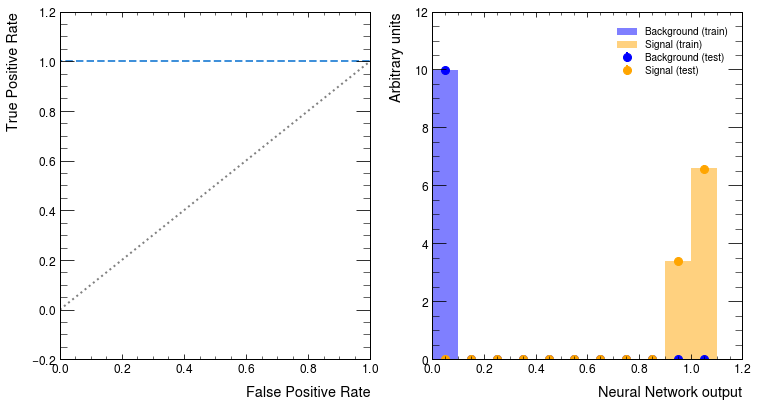

Accuracy Score: 0.9995
AUC Score: 0.999997
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13110
         1.0       1.00      1.00      1.00      3667

    accuracy                           1.00     16777
   macro avg       1.00      1.00      1.00     16777
weighted avg       1.00      1.00      1.00     16777

Confusion Matrix: 
[[13109     1]
 [    8  3659]]
Precision: 0.9997
Recall: 0.9978
F1-Score: 0.9988
Area under the Precision-Recall Curve: 0.998


In [41]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(fpr_nn_partonic_fm_0L, tpr_nn_partonic_fm_0L, linestyle="dashed", label="Neural Network")
ax[0].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
compare_train_test(NN_clf_partonic_fm_0L, X_train_scaled_partonic_fm_0L, y_train_partonic_fm_0L, X_test_scaled_partonic_fm_0L, y_test_partonic_fm_0L, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_partonic_fm_0L, y_pred_NN_partonic_fm_0L):.4g}")
print(f"AUC Score: {auc_score_partonic_fm_0L:.6g}")
print(classification_report(y_test_partonic_fm_0L,y_pred_NN_partonic_fm_0L))
print(f"Confusion Matrix: \n{cm_partonic_fm_0L}")
print(f"Precision: {precision_partonic_fm_0L:.4g}")
print(f"Recall: {recall_partonic_fm_0L:.4g}")
print(f"F1-Score: {f1_partonic_fm_0L:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_partonic_fm_0L:.4g}")

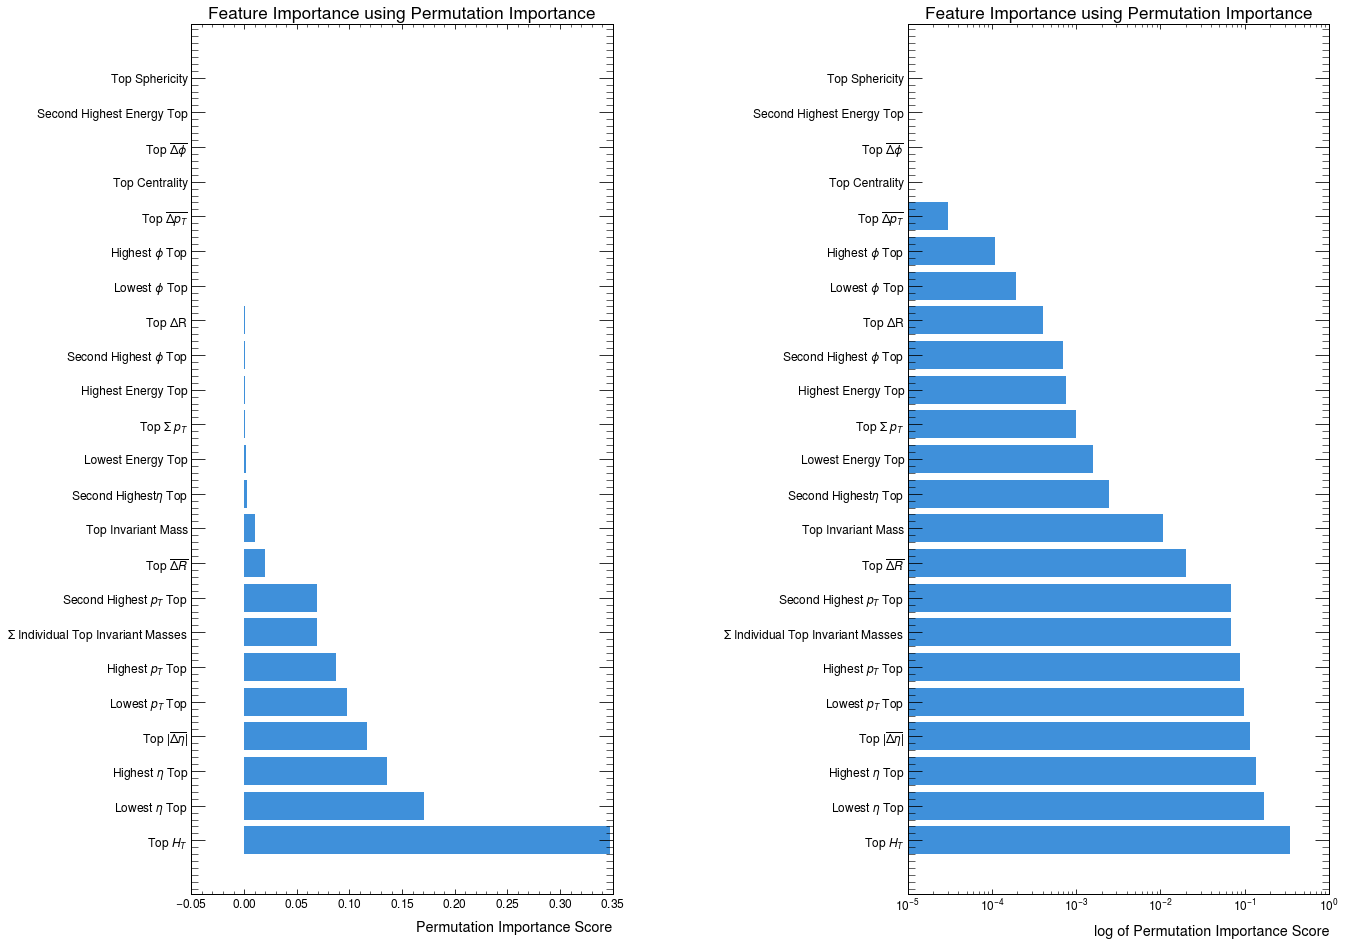

In [42]:
results_partonic_fm_0L = permutation_importance(NN_clf_partonic_fm_0L, X_test_tensor_partonic_fm_0L, y_test_tensor_partonic_fm_0L, n_repeats=30, random_state=42)
feature_names_partonic_fm_0L = variable_names_partonic_reduced_fm_0L

importance_scores_partonic_fm_0L = results_partonic_fm_0L.importances_mean

feature_importance_partonic_fm_0L = sorted(zip(importance_scores_partonic_fm_0L), reverse=True)

sorted_indices_partonic_fm_0L = np.argsort(importance_scores_partonic_fm_0L)[::-1]

sorted_importance_scores_partonic_fm_0L = importance_scores_partonic_fm_0L[sorted_indices_partonic_fm_0L]
sorted_feature_names_partonic_fm_0L = np.array(feature_names_partonic_fm_0L)[sorted_indices_partonic_fm_0L]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_partonic_fm_0L, sorted_importance_scores_partonic_fm_0L, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_partonic_fm_0L, sorted_importance_scores_partonic_fm_0L, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.7)
plt.show()

### TM 0L

In [74]:
X_partonic_tm_0L = trans_partonic_data_reduced_tm_0L
y_partonic_tm_0L = labels_partonic_tm_0L

X_train_partonic_tm_0L, X_test_partonic_tm_0L, y_train_partonic_tm_0L, y_test_partonic_tm_0L = train_test_split(X_partonic_tm_0L, y_partonic_tm_0L, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_partonic_tm_0L)

X_train_scaled_partonic_tm_0L = scaler.transform(X_train_partonic_tm_0L)
X_test_scaled_partonic_tm_0L = scaler.transform(X_test_partonic_tm_0L)
X_scaled_partonic_tm_0L = scaler.transform(X_partonic_tm_0L)

In [75]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_partonic_tm_0L[0,:])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
hidden_size3 = 64  # The number of nodes at the third hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [76]:
X_train_tensor_partonic_tm_0L = torch.as_tensor(X_train_scaled_partonic_tm_0L, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_partonic_tm_0L = torch.as_tensor(y_train_partonic_tm_0L, dtype=torch.long)  # make tensor from y_train
X_train_var_partonic_tm_0L, y_train_var_partonic_tm_0L = Variable(X_train_tensor_partonic_tm_0L), Variable(y_train_tensor_partonic_tm_0L)  # make variables from tensors

validation_length_partonic_tm_0L = int(len(X_train_var_partonic_tm_0L)/10)

X_valid_var_partonic_tm_0L, y_valid_var_partonic_tm_0L = (X_train_var_partonic_tm_0L[:validation_length_partonic_tm_0L],y_train_var_partonic_tm_0L[:validation_length_partonic_tm_0L],)  # get first 100 events for validation
X_train_nn_var_partonic_tm_0L, y_train_nn_var_partonic_tm_0L = (X_train_var_partonic_tm_0L[validation_length_partonic_tm_0L:],y_train_var_partonic_tm_0L[validation_length_partonic_tm_0L:],)  # get remaining events for training

train_data_partonic_tm_0L = Data.TensorDataset(X_train_nn_var_partonic_tm_0L, y_train_nn_var_partonic_tm_0L)  # create training dataset
valid_data_partonic_tm_0L = Data.TensorDataset(X_valid_var_partonic_tm_0L, y_valid_var_partonic_tm_0L)  # create validation dataset
train_loader_partonic_tm_0L = Data.DataLoader(dataset=train_data_partonic_tm_0L,batch_size=batch_size,shuffle=True,)
valid_loader_partonic_tm_0L = Data.DataLoader(dataset=valid_data_partonic_tm_0L,batch_size=batch_size,shuffle=True,)

In [77]:
NN_clf_partonic_tm_0L = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_partonic_tm_0L = torch.optim.Adam(NN_clf_partonic_tm_0L.parameters(), lr=learning_rate)
NN_clf_partonic_tm_0L.fit(train_loader_partonic_tm_0L,valid_loader_partonic_tm_0L,optimiser_partonic_tm_0L)

Epoch: 1, Train Loss: 0.540461
Validation Loss: 0.533354, Validation Accuracy: 0.761258
Epoch: 2, Train Loss: 0.536062
Validation Loss: 0.533122, Validation Accuracy: 0.761169
Epoch: 3, Train Loss: 0.535248
Validation Loss: 0.531821, Validation Accuracy: 0.761258
Epoch: 4, Train Loss: 0.534973
Validation Loss: 0.532969, Validation Accuracy: 0.761169
Epoch: 5, Train Loss: 0.534366
Validation Loss: 0.532194, Validation Accuracy: 0.761438
Epoch: 6, Train Loss: 0.534110
Validation Loss: 0.531880, Validation Accuracy: 0.761169
Epoch: 7, Train Loss: 0.533986
Validation Loss: 0.532058, Validation Accuracy: 0.761079
Epoch: 8, Train Loss: 0.533492
Validation Loss: 0.532062, Validation Accuracy: 0.761079
Epoch: 9, Train Loss: 0.533219
Validation Loss: 0.533494, Validation Accuracy: 0.760539
Epoch: 10, Train Loss: 0.533017
Validation Loss: 0.533055, Validation Accuracy: 0.761079
Epoch: 11, Train Loss: 0.532845
Validation Loss: 0.533051, Validation Accuracy: 0.761258
Epoch: 12, Train Loss: 0.53295

In [78]:
X_test_tensor_partonic_tm_0L = torch.as_tensor(X_test_scaled_partonic_tm_0L, dtype=torch.float)
y_test_tensor_partonic_tm_0L = torch.as_tensor(y_test_partonic_tm_0L, dtype=torch.long)

X_test_var_partonic_tm_0L, y_test_var_partonic_tm_0L = Variable(X_test_tensor_partonic_tm_0L), Variable(y_test_tensor_partonic_tm_0L)
out_partonic_tm_0L,prob_partonic_tm_0L = NN_clf_partonic_tm_0L(X_test_var_partonic_tm_0L)
y_pred_NN_partonic_tm_0L = (prob_partonic_tm_0L.cpu().detach().numpy().argmax(axis=1))

decisions_nn_partonic_tm_0L = (NN_clf_partonic_tm_0L(X_test_var_partonic_tm_0L)[1][:, 1].cpu().detach().numpy())

fpr_nn_partonic_tm_0L, tpr_nn_partonic_tm_0L, thresholds_nn_partonic_tm_0L = roc_curve(y_test_partonic_tm_0L, decisions_nn_partonic_tm_0L)

ams_nn_partonic_tm_0L = AMS(tpr_nn_partonic_tm_0L,fpr_nn_partonic_tm_0L,b_reg)

auc_score_partonic_tm_0L = roc_auc_score(y_test_partonic_tm_0L,decisions_nn_partonic_tm_0L)

cm_partonic_tm_0L = confusion_matrix(y_test_partonic_tm_0L, y_pred_NN_partonic_tm_0L)
precision_partonic_tm_0L = precision_score(y_test_partonic_tm_0L, y_pred_NN_partonic_tm_0L)
recall_partonic_tm_0L = recall_score(y_test_partonic_tm_0L, y_pred_NN_partonic_tm_0L)
f1_partonic_tm_0L = f1_score(y_test_partonic_tm_0L, y_pred_NN_partonic_tm_0L)
auc_pr_partonic_tm_0L = average_precision_score(y_test_partonic_tm_0L,y_pred_NN_partonic_tm_0L)

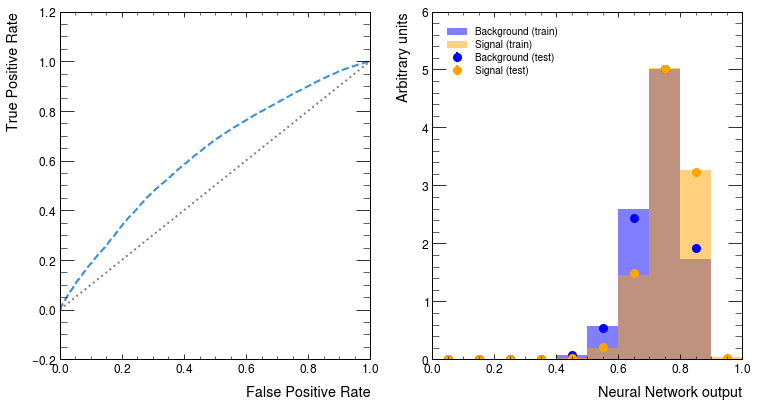

Accuracy Score: 0.7586
AUC Score: 0.623458
              precision    recall  f1-score   support

         0.0       0.54      0.01      0.01     13246
         1.0       0.76      1.00      0.86     41553

    accuracy                           0.76     54799
   macro avg       0.65      0.50      0.44     54799
weighted avg       0.71      0.76      0.66     54799

Confusion Matrix: 
[[   99 13147]
 [   83 41470]]
Precision: 0.7593
Recall: 0.998
F1-Score: 0.8624
Area under the Precision-Recall Curve: 0.7593


In [79]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(fpr_nn_partonic_tm_0L, tpr_nn_partonic_tm_0L, linestyle="dashed", label="Neural Network")
ax[0].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
compare_train_test(NN_clf_partonic_tm_0L, X_train_scaled_partonic_tm_0L, y_train_partonic_tm_0L, X_test_scaled_partonic_tm_0L, y_test_partonic_tm_0L, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_partonic_tm_0L, y_pred_NN_partonic_tm_0L):.4g}")
print(f"AUC Score: {auc_score_partonic_tm_0L:.6g}")
print(classification_report(y_test_partonic_tm_0L,y_pred_NN_partonic_tm_0L))
print(f"Confusion Matrix: \n{cm_partonic_tm_0L}")
print(f"Precision: {precision_partonic_tm_0L:.4g}")
print(f"Recall: {recall_partonic_tm_0L:.4g}")
print(f"F1-Score: {f1_partonic_tm_0L:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_partonic_tm_0L:.4g}")

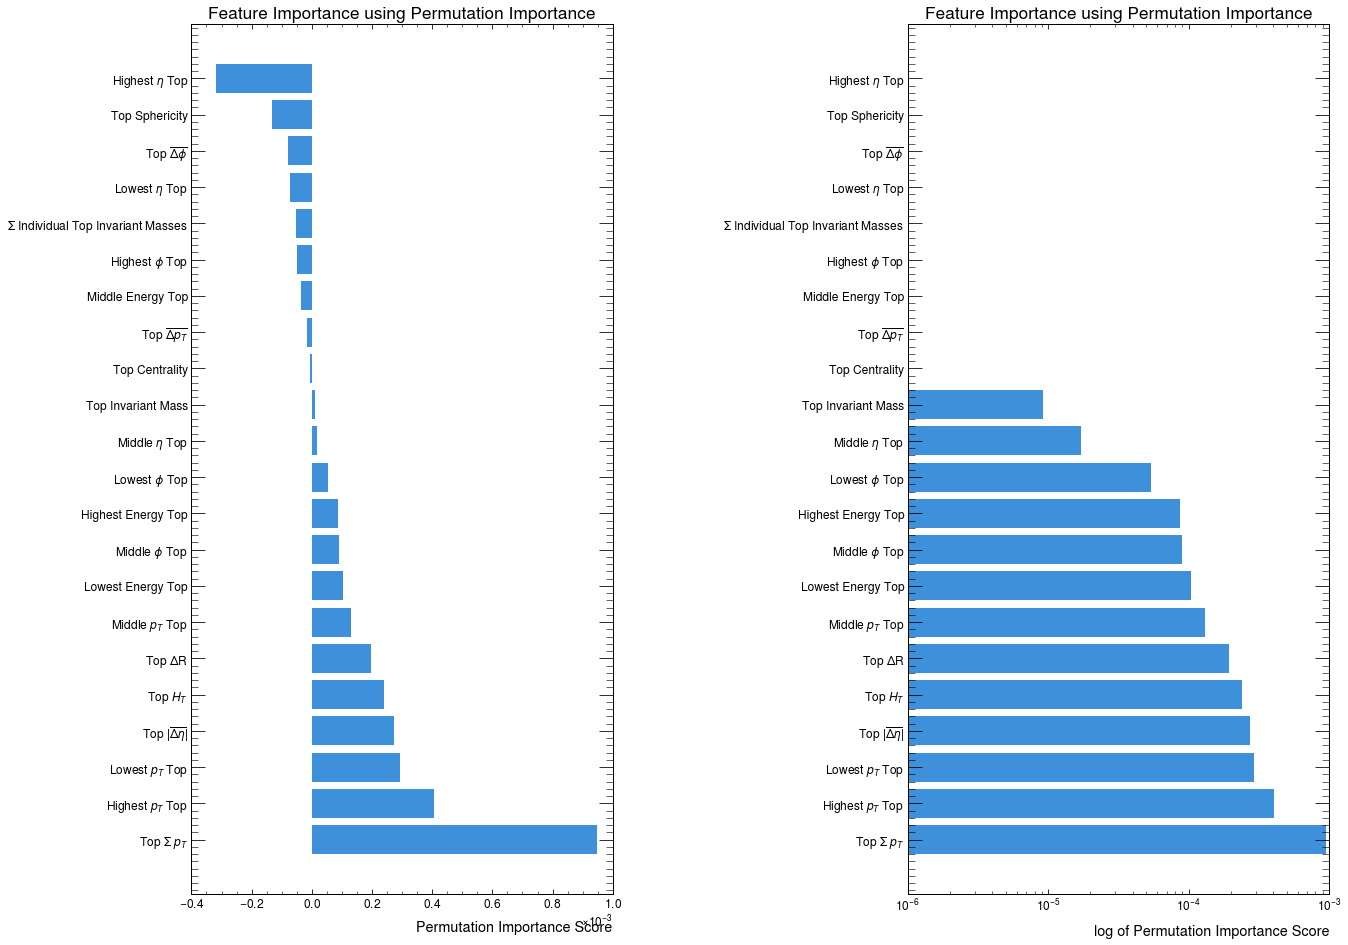

In [80]:
results_partonic_tm_0L = permutation_importance(NN_clf_partonic_tm_0L, X_test_tensor_partonic_tm_0L, y_test_tensor_partonic_tm_0L, n_repeats=30, random_state=42)
feature_names_partonic_tm_0L = variable_names_partonic_reduced_tm_0L

importance_scores_partonic_tm_0L = results_partonic_tm_0L.importances_mean

feature_importance_partonic_tm_0L = sorted(zip(importance_scores_partonic_tm_0L), reverse=True)

sorted_indices_partonic_tm_0L = np.argsort(importance_scores_partonic_tm_0L)[::-1]

sorted_importance_scores_partonic_tm_0L = importance_scores_partonic_tm_0L[sorted_indices_partonic_tm_0L]
sorted_feature_names_partonic_tm_0L = np.array(feature_names_partonic_tm_0L)[sorted_indices_partonic_tm_0L]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_partonic_tm_0L, sorted_importance_scores_partonic_tm_0L, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_partonic_tm_0L, sorted_importance_scores_partonic_tm_0L, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.7)
plt.show()

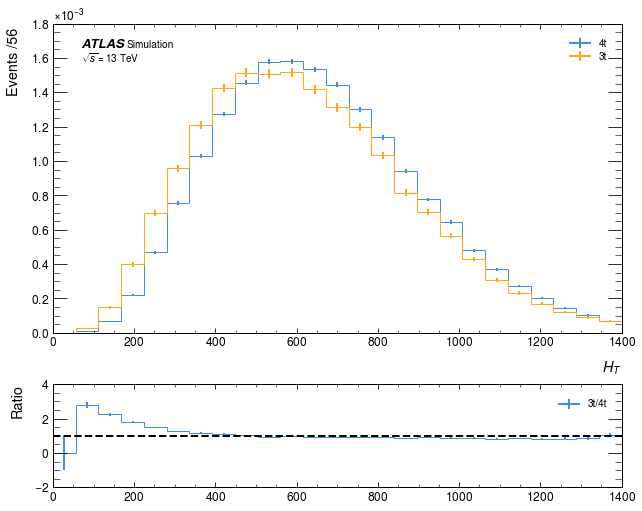

In [82]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([tm_reco_tops_4t_0L_H_t,tm_reco_tops_3t_0L_H_t], 25, ['4t','3t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='', set_range=(0,1400))
ax[0].set_xlabel(r'$H_T$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

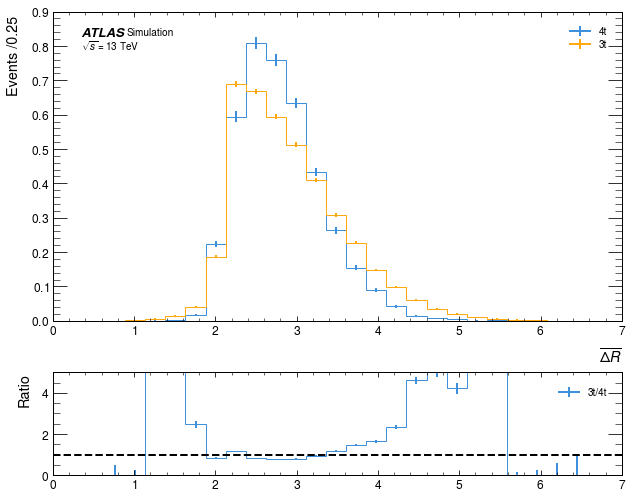

In [83]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([deltaR_4t_dm_0L,deltaR_3t_dm_0L], 25, ['4t','3t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'$\overline{\Delta R}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### DM 0L

In [84]:
X_partonic_dm_0L = trans_partonic_data_reduced_dm_0L
y_partonic_dm_0L = labels_partonic_dm_0L

X_train_partonic_dm_0L, X_test_partonic_dm_0L, y_train_partonic_dm_0L, y_test_partonic_dm_0L = train_test_split(X_partonic_dm_0L, y_partonic_dm_0L, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_partonic_dm_0L)
print(np.shape(X_partonic_dm_0L))
X_train_scaled_partonic_dm_0L = scaler.transform(X_train_partonic_dm_0L)
X_test_scaled_partonic_dm_0L = scaler.transform(X_test_partonic_dm_0L)
X_scaled_partonic_dm_0L = scaler.transform(X_partonic_dm_0L)

[840456, 14]


In [85]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_partonic_dm_0L[0,:])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
hidden_size3 = 64  # The number of nodes at the third hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [86]:
X_train_tensor_partonic_dm_0L = torch.as_tensor(X_train_scaled_partonic_dm_0L, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_partonic_dm_0L = torch.as_tensor(y_train_partonic_dm_0L, dtype=torch.long)  # make tensor from y_train
X_train_var_partonic_dm_0L, y_train_var_partonic_dm_0L = Variable(X_train_tensor_partonic_dm_0L), Variable(y_train_tensor_partonic_dm_0L)  # make variables from tensors

validation_length_partonic_dm_0L = int(len(X_train_var_partonic_dm_0L)/10)

X_valid_var_partonic_dm_0L, y_valid_var_partonic_dm_0L = (X_train_var_partonic_dm_0L[:validation_length_partonic_dm_0L],y_train_var_partonic_dm_0L[:validation_length_partonic_dm_0L],)  # get first 100 events for validation
X_train_nn_var_partonic_dm_0L, y_train_nn_var_partonic_dm_0L = (X_train_var_partonic_dm_0L[validation_length_partonic_dm_0L:],y_train_var_partonic_dm_0L[validation_length_partonic_dm_0L:],)  # get remaining events for training

train_data_partonic_dm_0L = Data.TensorDataset(X_train_nn_var_partonic_dm_0L, y_train_nn_var_partonic_dm_0L)  # create training dataset
valid_data_partonic_dm_0L = Data.TensorDataset(X_valid_var_partonic_dm_0L, y_valid_var_partonic_dm_0L)  # create validation dataset
train_loader_partonic_dm_0L = Data.DataLoader(dataset=train_data_partonic_dm_0L,batch_size=batch_size,shuffle=True,)
valid_loader_partonic_dm_0L = Data.DataLoader(dataset=valid_data_partonic_dm_0L,batch_size=batch_size,shuffle=True,)

In [87]:
NN_clf_partonic_dm_0L = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_partonic_dm_0L = torch.optim.Adam(NN_clf_partonic_dm_0L.parameters(), lr=learning_rate)
NN_clf_partonic_dm_0L.fit(train_loader_partonic_dm_0L,valid_loader_partonic_dm_0L,optimiser_partonic_dm_0L)

Epoch: 1, Train Loss: 0.662249
Validation Loss: 0.661473, Validation Accuracy: 0.611046
Epoch: 2, Train Loss: 0.661514
Validation Loss: 0.661350, Validation Accuracy: 0.611472
Epoch: 3, Train Loss: 0.661238
Validation Loss: 0.661990, Validation Accuracy: 0.610567
Epoch: 4, Train Loss: 0.661335
Validation Loss: 0.661350, Validation Accuracy: 0.610886
Epoch: 5, Train Loss: 0.661190
Validation Loss: 0.661489, Validation Accuracy: 0.612431
Epoch: 6, Train Loss: 0.661120
Validation Loss: 0.661968, Validation Accuracy: 0.611206
Epoch: 7, Train Loss: 0.661140
Validation Loss: 0.662031, Validation Accuracy: 0.610922
Epoch: 8, Train Loss: 0.661170
Validation Loss: 0.661306, Validation Accuracy: 0.611028
Epoch: 9, Train Loss: 0.661079
Validation Loss: 0.661660, Validation Accuracy: 0.610460
Epoch: 10, Train Loss: 0.661066
Validation Loss: 0.661284, Validation Accuracy: 0.610495
Epoch: 11, Train Loss: 0.660997
Validation Loss: 0.661285, Validation Accuracy: 0.611117
Epoch: 12, Train Loss: 0.66107

In [88]:
X_test_tensor_partonic_dm_0L = torch.as_tensor(X_test_scaled_partonic_dm_0L, dtype=torch.float)
y_test_tensor_partonic_dm_0L = torch.as_tensor(y_test_partonic_dm_0L, dtype=torch.long)

X_test_var_partonic_dm_0L, y_test_var_partonic_dm_0L = Variable(X_test_tensor_partonic_dm_0L), Variable(y_test_tensor_partonic_dm_0L)
out_partonic_dm_0L,prob_partonic_dm_0L = NN_clf_partonic_dm_0L(X_test_var_partonic_dm_0L)
y_pred_NN_partonic_dm_0L = (prob_partonic_dm_0L.cpu().detach().numpy().argmax(axis=1))

decisions_nn_partonic_dm_0L = (NN_clf_partonic_dm_0L(X_test_var_partonic_dm_0L)[1][:, 1].cpu().detach().numpy())

fpr_nn_partonic_dm_0L, tpr_nn_partonic_dm_0L, thresholds_nn_partonic_dm_0L = roc_curve(y_test_partonic_dm_0L, decisions_nn_partonic_dm_0L)

ams_nn_partonic_dm_0L = AMS(tpr_nn_partonic_dm_0L,fpr_nn_partonic_dm_0L,b_reg)

auc_score_partonic_dm_0L = roc_auc_score(y_test_partonic_dm_0L,decisions_nn_partonic_dm_0L)

cm_partonic_dm_0L = confusion_matrix(y_test_partonic_dm_0L, y_pred_NN_partonic_dm_0L)
precision_partonic_dm_0L = precision_score(y_test_partonic_dm_0L, y_pred_NN_partonic_dm_0L)
recall_partonic_dm_0L = recall_score(y_test_partonic_dm_0L, y_pred_NN_partonic_dm_0L)
f1_partonic_dm_0L = f1_score(y_test_partonic_dm_0L, y_pred_NN_partonic_dm_0L)
auc_pr_partonic_dm_0L = average_precision_score(y_test_partonic_dm_0L,y_pred_NN_partonic_dm_0L)

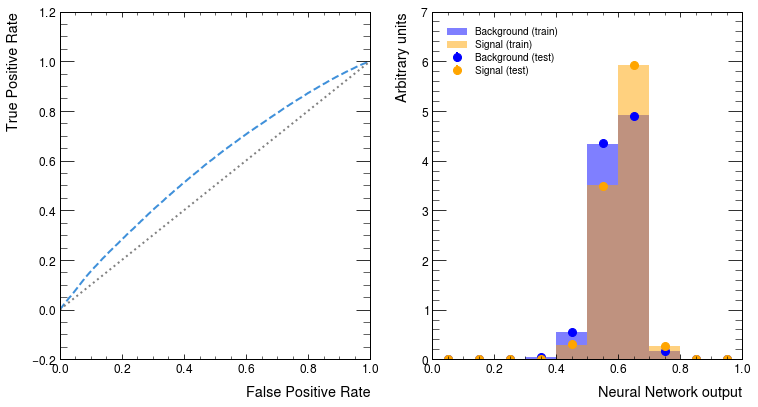

Accuracy Score: 0.6131
AUC Score: 0.578298
              precision    recall  f1-score   support

         0.0       0.54      0.06      0.11    108303
         1.0       0.62      0.97      0.75    169048

    accuracy                           0.61    277351
   macro avg       0.58      0.51      0.43    277351
weighted avg       0.59      0.61      0.50    277351

Confusion Matrix: 
[[  6354 101949]
 [  5354 163694]]
Precision: 0.6162
Recall: 0.9683
F1-Score: 0.7532
Area under the Precision-Recall Curve: 0.616


In [89]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(fpr_nn_partonic_dm_0L, tpr_nn_partonic_dm_0L, linestyle="dashed", label="Neural Network")
ax[0].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
compare_train_test(NN_clf_partonic_dm_0L, X_train_scaled_partonic_dm_0L, y_train_partonic_dm_0L, X_test_scaled_partonic_dm_0L, y_test_partonic_dm_0L, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_partonic_dm_0L, y_pred_NN_partonic_dm_0L):.4g}")
print(f"AUC Score: {auc_score_partonic_dm_0L:.6g}")
print(classification_report(y_test_partonic_dm_0L,y_pred_NN_partonic_dm_0L))
print(f"Confusion Matrix: \n{cm_partonic_dm_0L}")
print(f"Precision: {precision_partonic_dm_0L:.4g}")
print(f"Recall: {recall_partonic_dm_0L:.4g}")
print(f"F1-Score: {f1_partonic_dm_0L:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_partonic_dm_0L:.4g}")

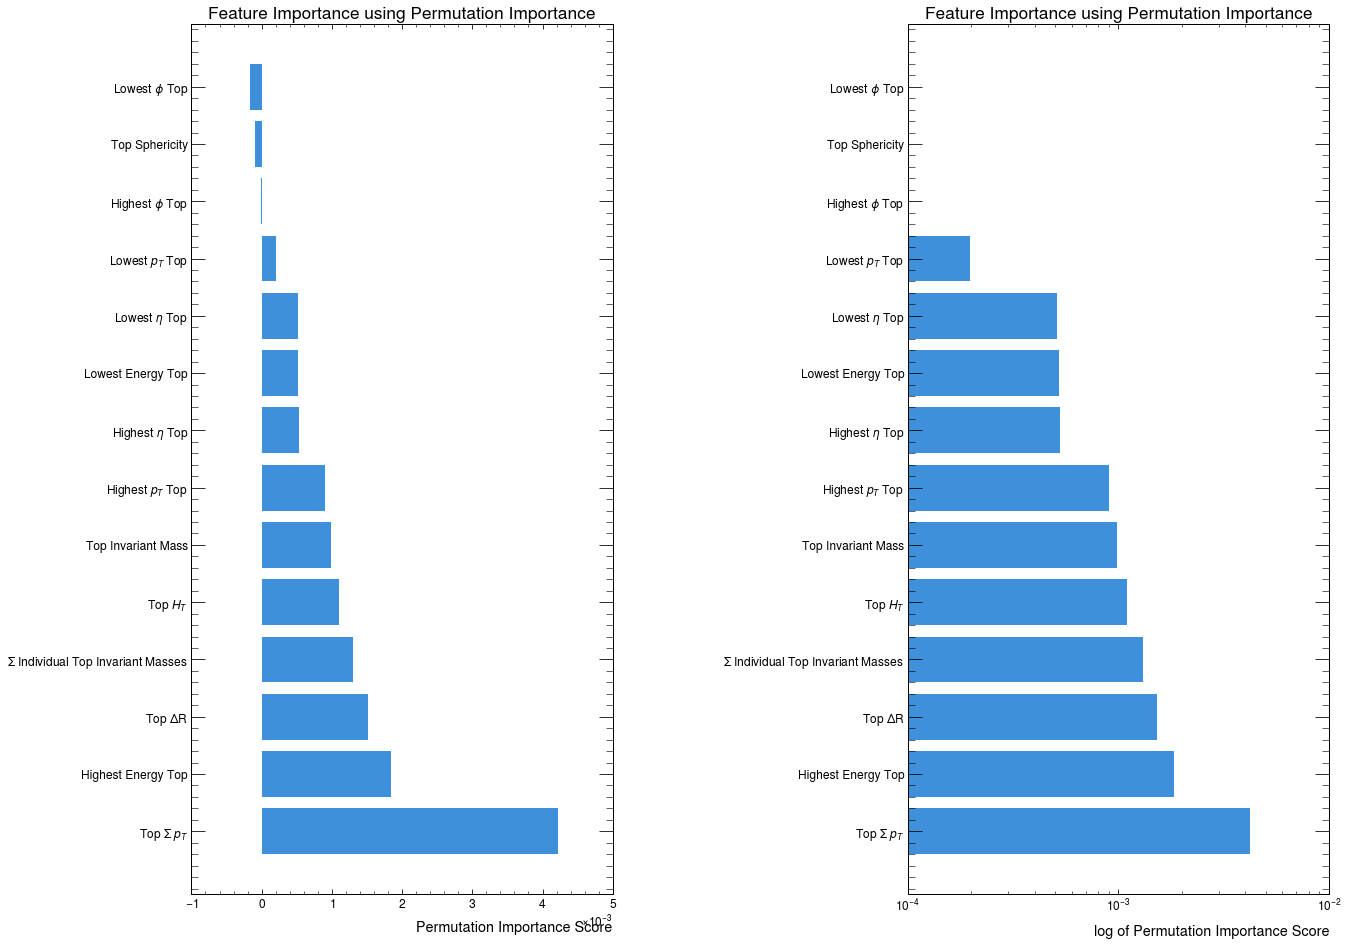

In [90]:
results_partonic_dm_0L = permutation_importance(NN_clf_partonic_dm_0L, X_test_tensor_partonic_dm_0L, y_test_tensor_partonic_dm_0L, n_repeats=30, random_state=42)
feature_names_partonic_dm_0L = variable_names_partonic_reduced_dm_0L

importance_scores_partonic_dm_0L = results_partonic_dm_0L.importances_mean

feature_importance_partonic_dm_0L = sorted(zip(importance_scores_partonic_dm_0L), reverse=True)

sorted_indices_partonic_dm_0L = np.argsort(importance_scores_partonic_dm_0L)[::-1]

sorted_importance_scores_partonic_dm_0L = importance_scores_partonic_dm_0L[sorted_indices_partonic_dm_0L]
sorted_feature_names_partonic_dm_0L = np.array(feature_names_partonic_dm_0L)[sorted_indices_partonic_dm_0L]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_partonic_dm_0L, sorted_importance_scores_partonic_dm_0L, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_partonic_dm_0L, sorted_importance_scores_partonic_dm_0L, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.7)
plt.show()

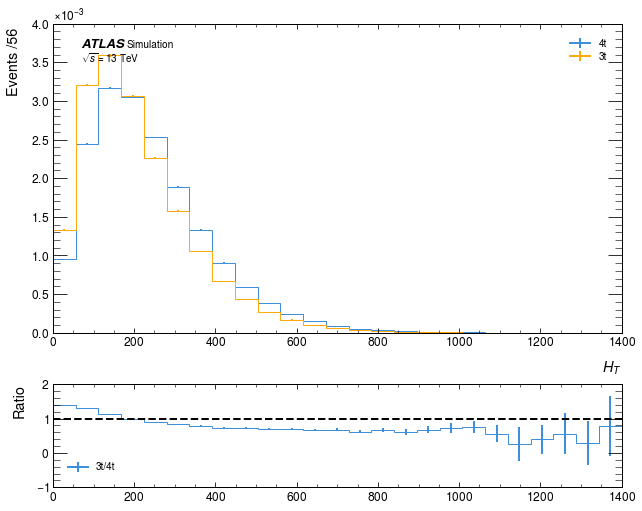

In [91]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([dm_reco_tops_4t_0L_sum_pt,dm_reco_tops_3t_0L_sum_pt], 25, ['4t','3t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='', set_range=(0,1400))
ax[0].set_xlabel(r'$H_T$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

### At least TM 0L

In [ ]:
X_partonic_al_tm_0L = trans_partonic_data_reduced_al_tm_0L
y_partonic_al_tm_0L = labels_partonic_al_tm_0L

X_train_partonic_al_tm_0L, X_test_partonic_al_tm_0L, y_train_partonic_al_tm_0L, y_test_partonic_al_tm_0L = train_test_split(X_partonic_al_tm_0L, y_partonic_al_tm_0L, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_partonic_al_tm_0L)

X_train_scaled_partonic_al_tm_0L = scaler.transform(X_train_partonic_al_tm_0L)
X_test_scaled_partonic_al_tm_0L = scaler.transform(X_test_partonic_al_tm_0L)
X_scaled_partonic_al_tm_0L = scaler.transform(X_partonic_al_tm_0L)

In [ ]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_partonic_al_tm_0L[0,:])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
hidden_size3 = 64  # The number of nodes at the third hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [ ]:
X_train_tensor_partonic_al_tm_0L = torch.as_tensor(X_train_scaled_partonic_al_tm_0L, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_partonic_al_tm_0L = torch.as_tensor(y_train_partonic_al_tm_0L, dtype=torch.long)  # make tensor from y_train
X_train_var_partonic_al_tm_0L, y_train_var_partonic_al_tm_0L = Variable(X_train_tensor_partonic_al_tm_0L), Variable(y_train_tensor_partonic_al_tm_0L)  # make variables from tensors

validation_length_partonic_al_tm_0L = int(len(X_train_var_partonic_al_tm_0L)/10)

X_valid_var_partonic_al_tm_0L, y_valid_var_partonic_al_tm_0L = (X_train_var_partonic_al_tm_0L[:validation_length_partonic_al_tm_0L],y_train_var_partonic_al_tm_0L[:validation_length_partonic_al_tm_0L],)  # get first 100 events for validation
X_train_nn_var_partonic_al_tm_0L, y_train_nn_var_partonic_al_tm_0L = (X_train_var_partonic_al_tm_0L[validation_length_partonic_al_tm_0L:],y_train_var_partonic_al_tm_0L[validation_length_partonic_al_tm_0L:],)  # get remaining events for training

train_data_partonic_al_tm_0L = Data.TensorDataset(X_train_nn_var_partonic_al_tm_0L, y_train_nn_var_partonic_al_tm_0L)  # create training dataset
valid_data_partonic_al_tm_0L = Data.TensorDataset(X_valid_var_partonic_al_tm_0L, y_valid_var_partonic_al_tm_0L)  # create validation dataset
train_loader_partonic_al_tm_0L = Data.DataLoader(dataset=train_data_partonic_al_tm_0L,batch_size=batch_size,shuffle=True,)
valid_loader_partonic_al_tm_0L = Data.DataLoader(dataset=valid_data_partonic_al_tm_0L,batch_size=batch_size,shuffle=True,)

In [ ]:
NN_clf_partonic_al_tm_0L = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_partonic_al_tm_0L = torch.optim.Adam(NN_clf_partonic_al_tm_0L.parameters(), lr=learning_rate)
NN_clf_partonic_al_tm_0L.fit(train_loader_partonic_al_tm_0L,valid_loader_partonic_al_tm_0L,optimiser_partonic_al_tm_0L)

Epoch: 1, Train Loss: 0.021640
Validation Loss: 0.001824, Validation Accuracy: 0.999409
Epoch: 2, Train Loss: 0.001726
Validation Loss: 0.001492, Validation Accuracy: 0.999578
Epoch: 3, Train Loss: 0.001451
Validation Loss: 0.001153, Validation Accuracy: 0.999578
Epoch: 4, Train Loss: 0.000812
Validation Loss: 0.000486, Validation Accuracy: 0.999747
Epoch: 5, Train Loss: 0.000503
Validation Loss: 0.000555, Validation Accuracy: 0.999916
Epoch: 6, Train Loss: 0.001398
Validation Loss: 0.000998, Validation Accuracy: 0.999747
Epoch: 7, Train Loss: 0.000863
Validation Loss: 0.000137, Validation Accuracy: 0.999916
Epoch: 8, Train Loss: 0.000677
Validation Loss: 0.000541, Validation Accuracy: 0.999916
Epoch: 9, Train Loss: 0.002245
Validation Loss: 0.000084, Validation Accuracy: 1.000000
Epoch: 10, Train Loss: 0.000274
Validation Loss: 0.000783, Validation Accuracy: 0.999747
Epoch: 11, Train Loss: 0.000663
Validation Loss: 0.000385, Validation Accuracy: 0.999831
Epoch: 12, Train Loss: 0.00045

In [ ]:
X_test_tensor_partonic_al_tm_0L = torch.as_tensor(X_test_scaled_partonic_al_tm_0L, dtype=torch.float)
y_test_tensor_partonic_al_tm_0L = torch.as_tensor(y_test_partonic_al_tm_0L, dtype=torch.long)

X_test_var_partonic_al_tm_0L, y_test_var_partonic_al_tm_0L = Variable(X_test_tensor_partonic_al_tm_0L), Variable(y_test_tensor_partonic_al_tm_0L)
out_partonic_al_tm_0L,prob_partonic_al_tm_0L = NN_clf_partonic_al_tm_0L(X_test_var_partonic_al_tm_0L)
y_pred_NN_partonic_al_tm_0L = (prob_partonic_al_tm_0L.cpu().detach().numpy().argmax(axis=1))

decisions_nn_partonic_al_tm_0L = (NN_clf_partonic_al_tm_0L(X_test_var_partonic_al_tm_0L)[1][:, 1].cpu().detach().numpy())

fpr_nn_partonic_al_tm_0L, tpr_nn_partonic_al_tm_0L, thresholds_nn_partonic_al_tm_0L = roc_curve(y_test_partonic_al_tm_0L, decisions_nn_partonic_al_tm_0L)

ams_nn_partonic_al_tm_0L = AMS(tpr_nn_partonic_al_tm_0L,fpr_nn_partonic_al_tm_0L,b_reg)

auc_score_partonic_al_tm_0L = roc_auc_score(y_test_partonic_al_tm_0L,decisions_nn_partonic_al_tm_0L)

cm_partonic_al_tm_0L = confusion_matrix(y_test_partonic_al_tm_0L, y_pred_NN_partonic_al_tm_0L)
precision_partonic_al_tm_0L = precision_score(y_test_partonic_al_tm_0L, y_pred_NN_partonic_al_tm_0L)
recall_partonic_al_tm_0L = recall_score(y_test_partonic_al_tm_0L, y_pred_NN_partonic_al_tm_0L)
f1_partonic_al_tm_0L = f1_score(y_test_partonic_al_tm_0L, y_pred_NN_partonic_al_tm_0L)
auc_pr_partonic_al_tm_0L = average_precision_score(y_test_partonic_al_tm_0L,y_pred_NN_partonic_al_tm_0L)

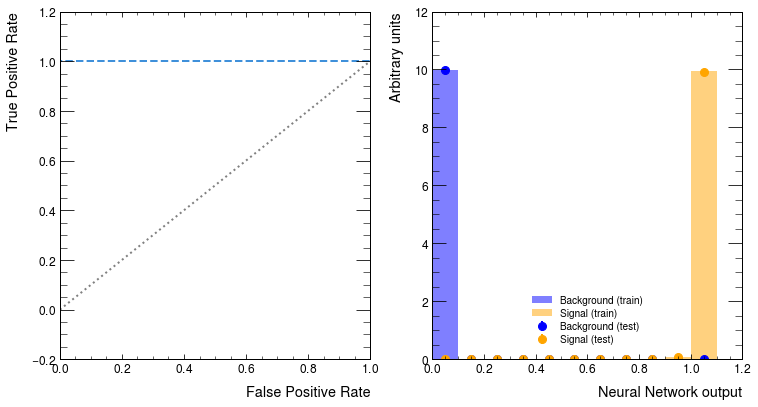

Accuracy Score: 0.9999
AUC Score: 1
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13240
         1.0       1.00      1.00      1.00     45138

    accuracy                           1.00     58378
   macro avg       1.00      1.00      1.00     58378
weighted avg       1.00      1.00      1.00     58378

Confusion Matrix: 
[[13240     0]
 [    7 45131]]
Precision: 1
Recall: 0.9998
F1-Score: 0.9999
Area under the Precision-Recall Curve: 1


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(fpr_nn_partonic_al_tm_0L, tpr_nn_partonic_al_tm_0L, linestyle="dashed", label="Neural Network")
ax[0].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
compare_train_test(NN_clf_partonic_al_tm_0L, X_train_scaled_partonic_al_tm_0L, y_train_partonic_al_tm_0L, X_test_scaled_partonic_al_tm_0L, y_test_partonic_al_tm_0L, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_partonic_al_tm_0L, y_pred_NN_partonic_al_tm_0L):.4g}")
print(f"AUC Score: {auc_score_partonic_al_tm_0L:.6g}")
print(classification_report(y_test_partonic_al_tm_0L,y_pred_NN_partonic_al_tm_0L))
print(f"Confusion Matrix: \n{cm_partonic_al_tm_0L}")
print(f"Precision: {precision_partonic_al_tm_0L:.4g}")
print(f"Recall: {recall_partonic_al_tm_0L:.4g}")
print(f"F1-Score: {f1_partonic_al_tm_0L:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_partonic_al_tm_0L:.4g}")

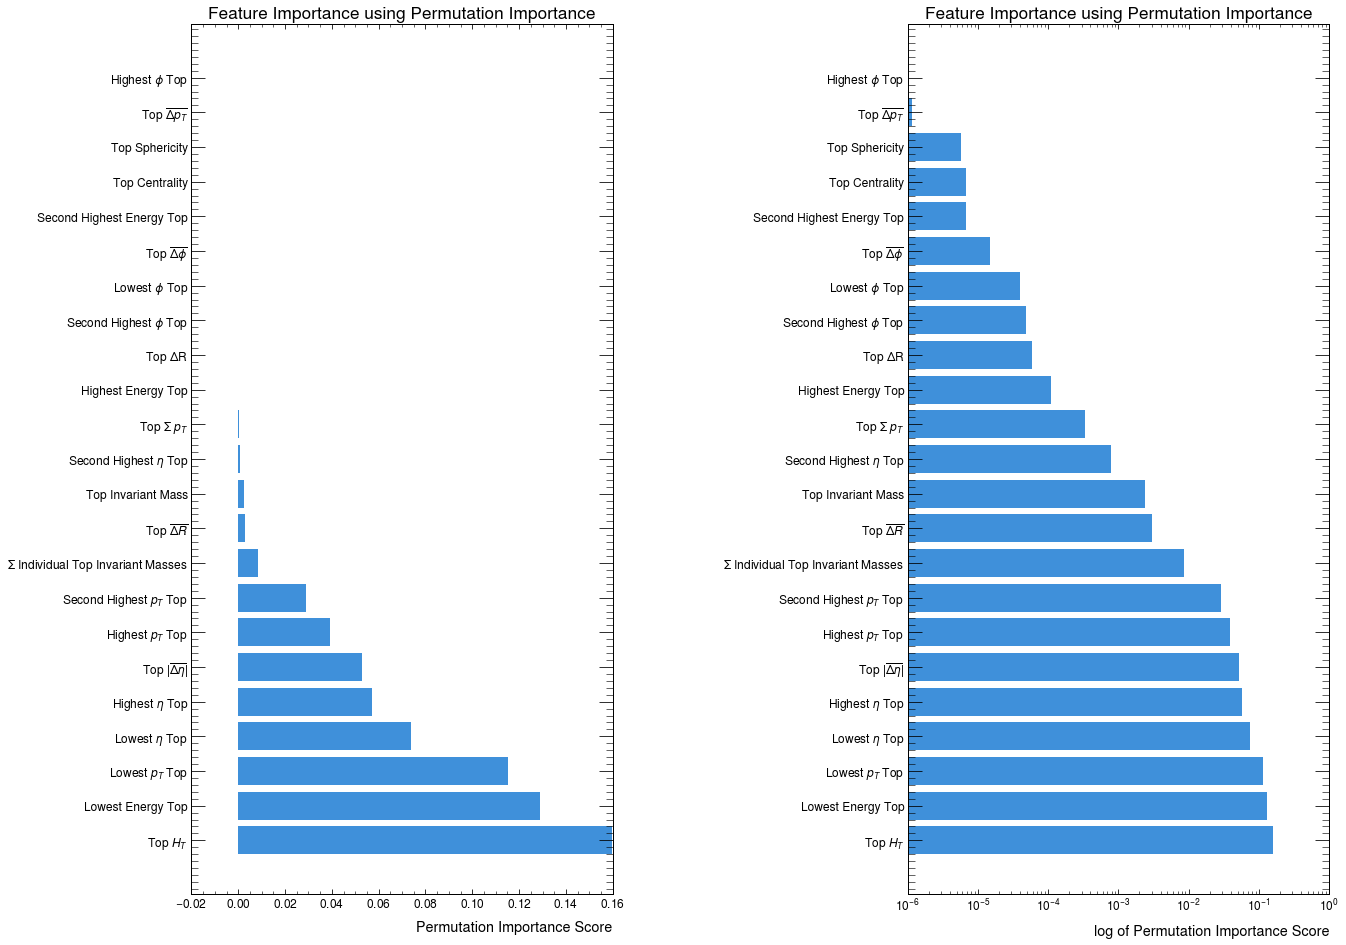

In [ ]:
results_partonic_al_tm_0L = permutation_importance(NN_clf_partonic_al_tm_0L, X_test_tensor_partonic_al_tm_0L, y_test_tensor_partonic_al_tm_0L, n_repeats=30, random_state=42)
feature_names_partonic_al_tm_0L = variable_names_partonic_reduced_al_tm_0L

importance_scores_partonic_al_tm_0L = results_partonic_al_tm_0L.importances_mean

feature_importance_partonic_al_tm_0L = sorted(zip(importance_scores_partonic_al_tm_0L), reverse=True)

sorted_indices_partonic_al_tm_0L = np.argsort(importance_scores_partonic_al_tm_0L)[::-1]

sorted_importance_scores_partonic_al_tm_0L = importance_scores_partonic_al_tm_0L[sorted_indices_partonic_al_tm_0L]
sorted_feature_names_partonic_al_tm_0L = np.array(feature_names_partonic_al_tm_0L)[sorted_indices_partonic_al_tm_0L]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_partonic_al_tm_0L, sorted_importance_scores_partonic_al_tm_0L, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_partonic_al_tm_0L, sorted_importance_scores_partonic_al_tm_0L, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.7)
plt.show()

### At least DM 0L

In [ ]:
X_partonic_al_dm_0L = trans_partonic_data_reduced_al_dm_0L
y_partonic_al_dm_0L = labels_partonic_al_dm_0L

X_train_partonic_al_dm_0L, X_test_partonic_al_dm_0L, y_train_partonic_al_dm_0L, y_test_partonic_al_dm_0L = train_test_split(X_partonic_al_dm_0L, y_partonic_al_dm_0L, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_partonic_al_dm_0L)

X_train_scaled_partonic_al_dm_0L = scaler.transform(X_train_partonic_al_dm_0L)
X_test_scaled_partonic_al_dm_0L = scaler.transform(X_test_partonic_al_dm_0L)
X_scaled_partonic_al_dm_0L = scaler.transform(X_partonic_al_dm_0L)

In [ ]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_partonic_al_dm_0L[0,:])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
hidden_size3 = 64  # The number of nodes at the third hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [ ]:
X_train_tensor_partonic_al_dm_0L = torch.as_tensor(X_train_scaled_partonic_al_dm_0L, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_partonic_al_dm_0L = torch.as_tensor(y_train_partonic_al_dm_0L, dtype=torch.long)  # make tensor from y_train
X_train_var_partonic_al_dm_0L, y_train_var_partonic_al_dm_0L = Variable(X_train_tensor_partonic_al_dm_0L), Variable(y_train_tensor_partonic_al_dm_0L)  # make variables from tensors

validation_length_partonic_al_dm_0L = int(len(X_train_var_partonic_al_dm_0L)/10)

X_valid_var_partonic_al_dm_0L, y_valid_var_partonic_al_dm_0L = (X_train_var_partonic_al_dm_0L[:validation_length_partonic_al_dm_0L],y_train_var_partonic_al_dm_0L[:validation_length_partonic_al_dm_0L],)  # get first 100 events for validation
X_train_nn_var_partonic_al_dm_0L, y_train_nn_var_partonic_al_dm_0L = (X_train_var_partonic_al_dm_0L[validation_length_partonic_al_dm_0L:],y_train_var_partonic_al_dm_0L[validation_length_partonic_al_dm_0L:],)  # get remaining events for training

train_data_partonic_al_dm_0L = Data.TensorDataset(X_train_nn_var_partonic_al_dm_0L, y_train_nn_var_partonic_al_dm_0L)  # create training dataset
valid_data_partonic_al_dm_0L = Data.TensorDataset(X_valid_var_partonic_al_dm_0L, y_valid_var_partonic_al_dm_0L)  # create validation dataset
train_loader_partonic_al_dm_0L = Data.DataLoader(dataset=train_data_partonic_al_dm_0L,batch_size=batch_size,shuffle=True,)
valid_loader_partonic_al_dm_0L = Data.DataLoader(dataset=valid_data_partonic_al_dm_0L,batch_size=batch_size,shuffle=True,)

In [ ]:
NN_clf_partonic_al_dm_0L = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_partonic_al_dm_0L = torch.optim.Adam(NN_clf_partonic_al_dm_0L.parameters(), lr=learning_rate)
NN_clf_partonic_al_dm_0L.fit(train_loader_partonic_al_dm_0L,valid_loader_partonic_al_dm_0L,optimiser_partonic_al_dm_0L)

Epoch: 1, Train Loss: 0.636106
Validation Loss: 0.634215, Validation Accuracy: 0.639893
Epoch: 2, Train Loss: 0.634779
Validation Loss: 0.635499, Validation Accuracy: 0.637809
Epoch: 3, Train Loss: 0.634559
Validation Loss: 0.634151, Validation Accuracy: 0.639541
Epoch: 4, Train Loss: 0.634492
Validation Loss: 0.634513, Validation Accuracy: 0.639922
Epoch: 5, Train Loss: 0.634412
Validation Loss: 0.633657, Validation Accuracy: 0.640391
Epoch: 6, Train Loss: 0.634441
Validation Loss: 0.634021, Validation Accuracy: 0.640098
Epoch: 7, Train Loss: 0.634364
Validation Loss: 0.633989, Validation Accuracy: 0.640171
Epoch: 8, Train Loss: 0.634338
Validation Loss: 0.634042, Validation Accuracy: 0.639687
Epoch: 9, Train Loss: 0.634256
Validation Loss: 0.634276, Validation Accuracy: 0.638910
Epoch: 10, Train Loss: 0.634204
Validation Loss: 0.634233, Validation Accuracy: 0.641272
Epoch: 11, Train Loss: 0.634227
Validation Loss: 0.633658, Validation Accuracy: 0.640802
Epoch: 12, Train Loss: 0.63402

In [ ]:
X_test_tensor_partonic_al_dm_0L = torch.as_tensor(X_test_scaled_partonic_al_dm_0L, dtype=torch.float)
y_test_tensor_partonic_al_dm_0L = torch.as_tensor(y_test_partonic_al_dm_0L, dtype=torch.long)

X_test_var_partonic_al_dm_0L, y_test_var_partonic_al_dm_0L = Variable(X_test_tensor_partonic_al_dm_0L), Variable(y_test_tensor_partonic_al_dm_0L)
out_partonic_al_dm_0L,prob_partonic_al_dm_0L = NN_clf_partonic_al_dm_0L(X_test_var_partonic_al_dm_0L)
y_pred_NN_partonic_al_dm_0L = (prob_partonic_al_dm_0L.cpu().detach().numpy().argmax(axis=1))

decisions_nn_partonic_al_dm_0L = (NN_clf_partonic_al_dm_0L(X_test_var_partonic_al_dm_0L)[1][:, 1].cpu().detach().numpy())

fpr_nn_partonic_al_dm_0L, tpr_nn_partonic_al_dm_0L, thresholds_nn_partonic_al_dm_0L = roc_curve(y_test_partonic_al_dm_0L, decisions_nn_partonic_al_dm_0L)

ams_nn_partonic_al_dm_0L = AMS(tpr_nn_partonic_al_dm_0L,fpr_nn_partonic_al_dm_0L,b_reg)

auc_score_partonic_al_dm_0L = roc_auc_score(y_test_partonic_al_dm_0L,decisions_nn_partonic_al_dm_0L)

cm_partonic_al_dm_0L = confusion_matrix(y_test_partonic_al_dm_0L, y_pred_NN_partonic_al_dm_0L)
precision_partonic_al_dm_0L = precision_score(y_test_partonic_al_dm_0L, y_pred_NN_partonic_al_dm_0L)
recall_partonic_al_dm_0L = recall_score(y_test_partonic_al_dm_0L, y_pred_NN_partonic_al_dm_0L)
f1_partonic_al_dm_0L = f1_score(y_test_partonic_al_dm_0L, y_pred_NN_partonic_al_dm_0L)
auc_pr_partonic_al_dm_0L = average_precision_score(y_test_partonic_al_dm_0L,y_pred_NN_partonic_al_dm_0L)

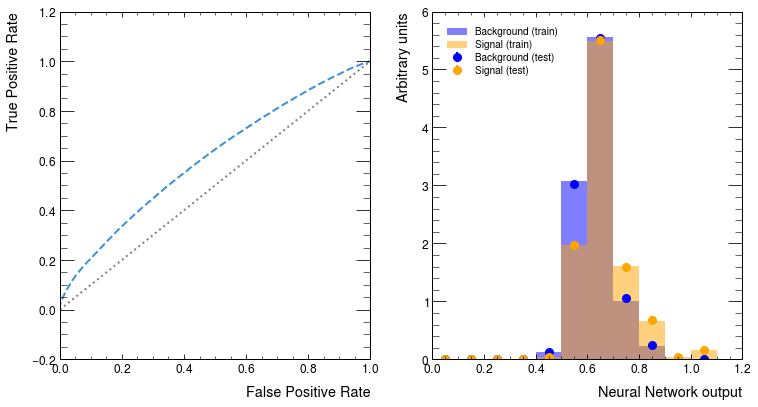

Accuracy Score: 0.6396
AUC Score: 0.608852
              precision    recall  f1-score   support

         0.0       0.59      0.01      0.02    121446
         1.0       0.64      1.00      0.78    214283

    accuracy                           0.64    335729
   macro avg       0.62      0.50      0.40    335729
weighted avg       0.62      0.64      0.51    335729

Confusion Matrix: 
[[  1465 119981]
 [  1012 213271]]
Precision: 0.64
Recall: 0.9953
F1-Score: 0.779
Area under the Precision-Recall Curve: 0.64


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(fpr_nn_partonic_al_dm_0L, tpr_nn_partonic_al_dm_0L, linestyle="dashed", label="Neural Network")
ax[0].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
compare_train_test(NN_clf_partonic_al_dm_0L, X_train_scaled_partonic_al_dm_0L, y_train_partonic_al_dm_0L, X_test_scaled_partonic_al_dm_0L, y_test_partonic_al_dm_0L, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_partonic_al_dm_0L, y_pred_NN_partonic_al_dm_0L):.4g}")
print(f"AUC Score: {auc_score_partonic_al_dm_0L:.6g}")
print(classification_report(y_test_partonic_al_dm_0L,y_pred_NN_partonic_al_dm_0L))
print(f"Confusion Matrix: \n{cm_partonic_al_dm_0L}")
print(f"Precision: {precision_partonic_al_dm_0L:.4g}")
print(f"Recall: {recall_partonic_al_dm_0L:.4g}")
print(f"F1-Score: {f1_partonic_al_dm_0L:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_partonic_al_dm_0L:.4g}")

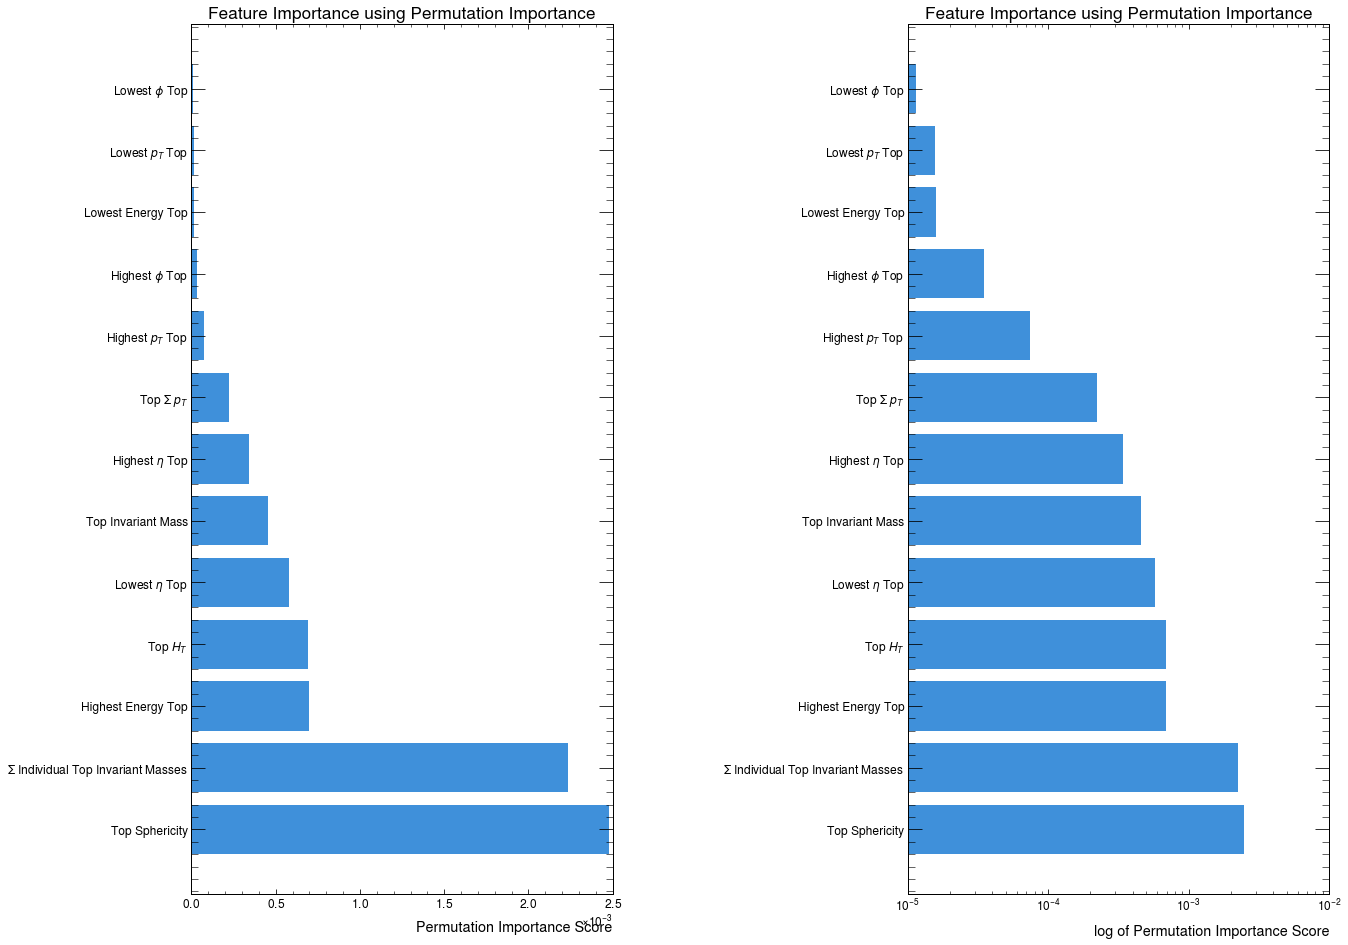

In [ ]:
results_partonic_al_dm_0L = permutation_importance(NN_clf_partonic_al_dm_0L, X_test_tensor_partonic_al_dm_0L, y_test_tensor_partonic_al_dm_0L, n_repeats=30, random_state=42)
feature_names_partonic_al_dm_0L = variable_names_partonic_reduced_al_dm_0L

importance_scores_partonic_al_dm_0L = results_partonic_al_dm_0L.importances_mean

feature_importance_partonic_al_dm_0L = sorted(zip(importance_scores_partonic_al_dm_0L), reverse=True)

sorted_indices_partonic_al_dm_0L = np.argsort(importance_scores_partonic_al_dm_0L)[::-1]

sorted_importance_scores_partonic_al_dm_0L = importance_scores_partonic_al_dm_0L[sorted_indices_partonic_al_dm_0L]
sorted_feature_names_partonic_al_dm_0L = np.array(feature_names_partonic_al_dm_0L)[sorted_indices_partonic_al_dm_0L]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_partonic_al_dm_0L, sorted_importance_scores_partonic_al_dm_0L, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_partonic_al_dm_0L, sorted_importance_scores_partonic_al_dm_0L, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.7)
plt.show()

In [ ]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([al_tm_reco_tops_4t_0L_H_t,al_tm_reco_tops_3t_0L_H_t], 25, ['4t','3t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'$H_T$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

NameError: name 'plt' is not defined